Analysis on Labour and Unemployment in Canada

Outline

A.  Data Loading and Preparation

B.  Research Questions
    1.  What are the differences in the distribution of unemployment rates in the past economic disturbances in Canada and Ontario?
    2.  How long does it take to recover from a recession as reflected by unemployment rates?
    3.  Can increased unemployment rates be predicted?
C.  Exploratory Analysis

D.  Analyses to answer Question 1:  
      Unemployment rates distribution according to:
      1.  Age
      2.  Sex
      3.  Yearly pattern
      4.  Industry

E.  Analyses to answer Question 2:
      Time patterns of disturbance and recovery of unemployment rates.

F.  Predicting Unemployment rates
      1.  Time series
      2.  FBProphet
      3.  Machine Learning methods
          a.  Linear Regression
          b.  Random Forest Regression
          c.  Decision Trees/ Ensemble

A.   Data Loading and Preparation

In [0]:
#Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import pandas as pd 
import urllib
import json
from pyspark.sql.functions import *
from pyspark.sql.functions import col, asc

In [0]:
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

In [0]:
#get data from statistics canada website
response = requests.get('https://www150.statcan.gc.ca/t1/wds/rest/getFullTableDownloadCSV/14100023/en')

In [0]:
urllib.request.urlretrieve(response.json()['object'], "/tmp/labor.zip")
#unload zip file next and save it on databricks

Out[3]: ('/tmp/labor.zip', <http.client.HTTPMessage at 0x7f34906f46a0>)

In [0]:
%sh
unzip /tmp/labor.zip


Archive: /tmp/labor.zip
 inflating: 14100023.csv 
 inflating: 14100023_MetaData.csv

In [0]:
dbutils.fs.mv("file:/databricks/driver/14100023.csv", "dbfs:/tmp/14100023.csv")  
dbutils.fs.mv("file:/databricks/driver/14100023_MetaData.csv", "dbfs:/tmp/14100023_MetaData.csv")  

Out[5]: True

In [0]:
# Load file into DataFrame
dfLabour = spark.read.format("csv").option("inferSchema", "true").option("header","true").load("dbfs:/tmp/14100023.csv")
dfmeta = spark.read.format("csv").option("inferSchema", "true").option("header","true").load("dbfs:/tmp/14100023_MetaData.csv")

In [0]:
# create tabular view
df=dfLabour
df.createOrReplaceTempView("labor")

In [0]:
df.printSchema()

root
-- REF_DATE: integer (nullable = true)
-- GEO: string (nullable = true)
-- DGUID: string (nullable = true)
-- Labour force characteristics: string (nullable = true)
-- North American Industry Classification System (NAICS): string (nullable = true)
-- Sex: string (nullable = true)
-- Age group: string (nullable = true)
-- UOM: string (nullable = true)
-- UOM_ID: integer (nullable = true)
-- SCALAR_FACTOR: string (nullable = true)
-- SCALAR_ID: integer (nullable = true)
-- VECTOR: string (nullable = true)
-- COORDINATE: string (nullable = true)
-- VALUE: double (nullable = true)
-- STATUS: string (nullable = true)
-- SYMBOL: string (nullable = true)
-- TERMINATED: string (nullable = true)
-- DECIMALS: integer (nullable = true)

In [0]:
#copy data to clean the data
Cleaned_df=dfLabour

In [0]:
#Drop unrelevent columns
Cleaned_df = Cleaned_df.drop('STATUS','SYMBOL','TERMINATED',
'DGUID','UOM_ID','SCALAR_ID','VECTOR','COORDINATE','DECIMALS')
#Rename column for better meaningful names
Cleaned_df = Cleaned_df.select(col('REF_DATE').alias('year'),
                   col('GEO').alias('Province'),
                   col('Labour force characteristics').alias('Labour_Force'),
                   col('North American Industry Classification System (NAICS)').alias('Industry'),
                   col('Sex'),
                   col('Age group').alias('Age'),
                   col('UOM').alias('Unit'),
                   col('SCALAR_FACTOR').alias('Scale'),
                   col('VALUE').alias('Value'))

In [0]:
#cleaned columns and view creation
Cleaned_df = Cleaned_df[['year', 'Province', 'Labour_Force', 'Industry', 'Sex', 'Age', 'Unit', 'Scale', 'Value']]
Cleaned_df.createOrReplaceTempView("tb_Cleaned_df") 
Cleaned_df

Out[12]: DataFrame[year: int, Province: string, Labour_Force: string, Industry: string, Sex: string, Age: string, Unit: string, Scale: string, Value: double]

In [0]:
#Check distinct Values for different columns below
Cleaned_df.select("Province").distinct().show()

+--------------------+
 Province|
+--------------------+
 Manitoba|
 Nova Scotia|
Newfoundland and ...|
 Alberta|
 New Brunswick|
 Saskatchewan|
Prince Edward Island|
 Ontario|
 British Columbia|
 Quebec|
 Canada|
+--------------------+

In [0]:
Cleaned_df.select("Industry").distinct().show()

+--------------------+
 Industry|
+--------------------+
Finance, insuranc...|
Accommodation and...|
Agriculture [111-...|
Goods-producing s...|
Transportation an...|
Professional, sci...|
 Utilities [22]|
Other services (e...|
Information, cult...|
Business, buildin...|
Unclassified indu...|
Wholesale and ret...|
Total, all indust...|
Health care and s...|
Forestry, fishing...|
 Construction [23]|
Public administra...|
Manufacturing [31...|
Educational servi...|
Services-producin...|
+--------------------+
only showing top 20 rows

In [0]:
Cleaned_df.select("Sex").distinct().show()

+----------+
 Sex|
+----------+
 Males|
 Females|
Both sexes|
+----------+

In [0]:
Cleaned_df.select("Age").distinct().show()

+-----------------+
 Age|
+-----------------+
15 years and over|
55 years and over|
 15 to 24 years|
 25 to 54 years|
+-----------------+

In [0]:
#very few null values in the value field which can be ignored for this analysis
Cleaned_df.where("Value is null").show()

+----+--------+--------------------+--------------------+----------+-----------------+-------+---------+-----+
year|Province| Labour_Force| Industry| Sex| Age| Unit| Scale|Value|
+----+--------+--------------------+--------------------+----------+-----------------+-------+---------+-----+
1976| Canada| Labour force|Forestry, fishing...| Females|55 years and over|Persons|thousands| null|
1976| Canada| Labour force| Utilities [22]| Females|55 years and over|Persons|thousands| null|
1976| Canada| Employment|Forestry, fishing...| Females|55 years and over|Persons|thousands| null|
1976| Canada| Employment| Utilities [22]| Females|55 years and over|Persons|thousands| null|
1976| Canada|Full-time employment|Forestry, fishing...| Females|55 years and over|Persons|thousands| null|
1976| Canada|Full-time employment| Utilities [22]| Females|55 years and over|Persons|thousands| null|
1976| Canada|Part-time employment|Forestry, fishing...|Both sexes|55 years and over|Persons|thousands| null|
1976| Canada|Part-time employment|Forestry, fishing...| Males| 25 to 54 years|Persons|thousands| null|
1976| Canada|Part-time employment|Forestry, fishing...| Males|55 years and over|Persons|thousands| null|
1976| Canada|Part-time employment|Forestry, fishing...| Females| 15 to 24 years|Persons|thousands| null|
1976| Canada|Part-time employment|Forestry, fishing...| Females|55 years and over|Persons|thousands| null|
1976| Canada|Part-time employment| Utilities [22]|Both sexes| 15 to 24 years|Persons|thousands| null|
1976| Canada|Part-time employment| Utilities [22]|Both sexes| 25 to 54 years|Persons|thousands| null|
1976| Canada|Part-time employment| Utilities [22]|Both sexes|55 years and over|Persons|thousands| null|
1976| Canada|Part-time employment| Utilities [22]| Males|15 years and over|Persons|thousands| null|
1976| Canada|Part-time employment| Utilities [22]| Males| 15 to 24 years|Persons|thousands| null|
1976| Canada|Part-time employment| Utilities [22]| Males| 25 to 54 years|Persons|thousands| null|
1976| Canada|Part-time employment| Utilities [22]| Males|55 years and over|Persons|thousands| null|
1976| Canada|Part-time employment| Utilities [22]| Females|15 years and over|Persons|thousands| null|
1976| Canada|Part-time employment| Utilities [22]| Females| 15 to 24 years|Persons|thousands| null|
+----+--------+--------------------+--------------------+----------+-----------------+-------+---------+-----+
only showing top 20 rows

In [0]:
Cleaned_df.na.fill(value=0,subset=["Value"]).show()

+----+--------+------------+--------------------+----------+-----------------+-------+---------+-------+
year|Province|Labour_Force| Industry| Sex| Age| Unit| Scale| Value|
+----+--------+------------+--------------------+----------+-----------------+-------+---------+-------+
1976| Canada|Labour force|Total, all indust...|Both sexes|15 years and over|Persons|thousands|10491.3|
1976| Canada|Labour force|Total, all indust...|Both sexes| 15 to 24 years|Persons|thousands| 2891.9|
1976| Canada|Labour force|Total, all indust...|Both sexes| 25 to 54 years|Persons|thousands| 6410.7|
1976| Canada|Labour force|Total, all indust...|Both sexes|55 years and over|Persons|thousands| 1188.7|
1976| Canada|Labour force|Total, all indust...| Males|15 years and over|Persons|thousands| 6549.6|
1976| Canada|Labour force|Total, all indust...| Males| 15 to 24 years|Persons|thousands| 1578.9|
1976| Canada|Labour force|Total, all indust...| Males| 25 to 54 years|Persons|thousands| 4139.7|
1976| Canada|Labour force|Total, all indust...| Males|55 years and over|Persons|thousands| 831.1|
1976| Canada|Labour force|Total, all indust...| Females|15 years and over|Persons|thousands| 3941.7|
1976| Canada|Labour force|Total, all indust...| Females| 15 to 24 years|Persons|thousands| 1313.1|
1976| Canada|Labour force|Total, all indust...| Females| 25 to 54 years|Persons|thousands| 2271.0|
1976| Canada|Labour force|Total, all indust...| Females|55 years and over|Persons|thousands| 357.6|
1976| Canada|Labour force|Goods-producing s...|Both sexes|15 years and over|Persons|thousands| 3628.4|
1976| Canada|Labour force|Goods-producing s...|Both sexes| 15 to 24 years|Persons|thousands| 889.2|
1976| Canada|Labour force|Goods-producing s...|Both sexes| 25 to 54 years|Persons|thousands| 2317.3|
1976| Canada|Labour force|Goods-producing s...|Both sexes|55 years and over|Persons|thousands| 421.9|
1976| Canada|Labour force|Goods-producing s...| Males|15 years and over|Persons|thousands| 2912.3|
1976| Canada|Labour force|Goods-producing s...| Males| 15 to 24 years|Persons|thousands| 683.9|
1976| Canada|Labour force|Goods-producing s...| Males| 25 to 54 years|Persons|thousands| 1865.6|
1976| Canada|Labour force|Goods-producing s...| Males|55 years and over|Persons|thousands| 362.7|
+----+--------+------------+--------------------+----------+-----------------+-------+---------+-------+
only showing top 20 rows

B.  Statement of Research Questions

    1.  What are the differences in the distribution of unemployment rates in the past economic disturbances in Canada and Ontario?
    2.  How long does it take to recover from a recession as reflected by unemployment rates?
    3.  Can increased unemployment rates be predicted?

C.  Exploratory Analyses

The over-all picture of the labour force for Canada

In [0]:
%sql
Select year,Labour_Force,Sum(Value) from tb_Cleaned_df 
where 
  Province='Canada' and
  --Labour_Force='Unemployment' and
  Industry='Total, all industries' and
  Sex='Both sexes' and
  Age='15 years and over' and
  Unit='Persons' 
group by year,Labour_Force;

year Labour_Force sum(Value) 1976 Employment 9747.5 1979 Employment 10668.6 1977 Employment 9917.1 1983 Labour force 12527.6 1981 Part-time employment 1673.7 1980 Part-time employment 1568.7 1976 Labour force 10491.3 1980 Employment 10984.0 1982 Part-time employment 1740.9 1983 Employment 11022.0 1979 Full-time employment 9201.8 1977 Unemployment 868.1 1981 Full-time employment 9631.3 1976 Full-time employment 8529.7 1977 Part-time employment 1290.6 1983 Unemployment 1505.6 1978 Full-time employment 8871.5 1979 Labour force 11536.7 1979 Part-time employment 1466.8 1978 Employment 10220.3 1983 Part-time employment 1848.9 1978 Unemployment 934.3 1981 Employment 11305.0 1978 Labour force 11154.6 1976 Unemployment 743.8 1977 Labour force 10785.2 1978 Part-time employment 1348.8 1977 Full-time employment 8626.5 1982 Full-time employment 9202.7 1982 Unemployment 1358.2 1982 Employment 10943.7 1980 Labour force 11879.4 1980 Unemployment 895.3 1981 Unemployment 930.8 1979 Unemployment 868.2 1976 Part-time employment 1217.8 1980 Full-time employment 9415.3 1981 Labour force 12235.8 1982 Labour force 12301.8 1983 Full-time employment 9173.1 1988 Employment 12709.6 1990 Part-time employment 2218.8 1989 Part-time employment 2161.2 1984 Employment 11301.7 1988 Unemployment 1069.5 1986 Employment 12008.5 1987 Employment 12333.0 1987 Unemployment 1193.0 1987 Full-time employment 10281.4 1986 Full-time employment 9977.3 1989 Employment 12996.2 1990 Unemployment 1158.3 1984 Full-time employment 9410.2 1985 Part-time employment 1985.4 1985 Labour force 13026.1 1984 Part-time employment 1891.5 1985 Full-time employment 9672.6 1986 Part-time employment 2031.2 1984 Labour force 12747.9 1985 Unemployment 1368.1 1986 Unemployment 1274.2 1989 Full-time employment 10835.0 1990 Labour force 14244.6 1984 Unemployment 1446.2 1990 Full-time employment 10867.6 1985 Employment 11658.0 1988 Full-time employment 10573.9 1989 Unemployment 1060.8 1990 Employment 13086.4 1986 Labour force 13282.7 1987 Labour force 13526.0 1989 Labour force 14057.0 1987 Part-time employment 2051.6 1988 Part-time employment 2135.7 1988 Labour force 13779.1 1994 Labour force 14573.7 1993 Unemployment 1642.3 1992 Labour force 14336.1 1994 Employment 13058.7 1991 Part-time employment 2331.7 1993 Labour force 14435.0 1994 Unemployment 1515.0 1995 Unemployment 1393.8 1995 Part-time employment 2496.9 1995 Full-time employment 10798.5 1993 Employment 12792.7 1995 Employment 13295.4 1991 Unemployment 1479.0 1995 Labour force 14689.2 1993 Part-time employment 2456.1 1991 Full-time employment 10525.7 1994 Part-time employment 2472.6 1994 Full-time employment 10586.1 1992 Employment 12730.9 1991 Labour force 14336.3 1991 Employment 12857.4 1993 Full-time employment 10336.6 1992 Full-time employment 10370.8 1992 Unemployment 1605.2 1992 Part-time employment 2360.1 2000 Employment 14760.1 1997 Labour force 15080.6 1998 Labour force 15314.8 1997 Unemployment 1372.4 1996 Labour force 14848.5 1996 Full-time employment 10860.1 2000 Part-time employment 2670.7 1999 Labour force 15583.7 2000 Unemployment 1081.8 1996 Employment 13420.1 1999 Full-time employment 11754.8 1998 Full-time employment 11406.5 1997 Part-time employment 2614.7 2000 Labour force 15841.9 1996 Part-time employment 2560.1 1997 Full-time employment 11093.5 1999 Employment 14402.0 1999 Unemployment 1181.7 1996 Unemployment 1428.4 1998 Employment 14047.0 1998 Part-time employment 2640.5 1997 Employment 13708.2 1999 Part-time employment 2647.2 2000 Full-time employment 12089.4 1998 Unemployment 1267.8 2005 Part-time employment 2968.2 2004 Full-time employment 12966.6 2005 Labour force 17292.1 2005 Full-time employment 13155.3 2002 Employment 15291.3 2001 Part-time employment 2702.9 2001 Full-time employment 12229.4 2002 Unemployment 1269.3 2001 Labour force 16094.1 2006 Employment 16375.0 2004 Labour force 17147.1 2002 Labour force 16560.7 2003 Full-time employment 12692.4 2006 Labour force 17482.3 2003 Part-time employment 2968.4 20

Below graph shows Unemployment and Unemployment rate in Canada

In [0]:

%sql
Select year,Labour_Force,avg(Value) from tb_Cleaned_df 
where 
  Province='Canada' and
  Labour_Force like 'Unemployment%' and
  Industry='Total, all industries' and
  Sex='Both sexes' and
  Age='15 years and over' 
  --Unit='Persons' 
group by year,Labour_Force;



year Labour_Force avg(Value) 1978 Unemployment rate 8.4 1977 Unemployment 868.1 1983 Unemployment 1505.6 1981 Unemployment rate 7.6 1978 Unemployment 934.3 1976 Unemployment 743.8 1983 Unemployment rate 12.0 1982 Unemployment 1358.2 1982 Unemployment rate 11.0 1980 Unemployment rate 7.5 1977 Unemployment rate 8.0 1980 Unemployment 895.3 1981 Unemployment 930.8 1979 Unemployment 868.2 1976 Unemployment rate 7.1 1979 Unemployment rate 7.5 1987 Unemployment rate 8.8 1984 Unemployment rate 11.3 1988 Unemployment 1069.5 1987 Unemployment 1193.0 1990 Unemployment 1158.3 1985 Unemployment rate 10.5 1988 Unemployment rate 7.8 1986 Unemployment rate 9.6 1985 Unemployment 1368.1 1986 Unemployment 1274.2 1989 Unemployment rate 7.5 1984 Unemployment 1446.2 1989 Unemployment 1060.8 1990 Unemployment rate 8.1 1995 Unemployment rate 9.5 1993 Unemployment 1642.3 1992 Unemployment rate 11.2 1994 Unemployment 1515.0 1993 Unemployment rate 11.4 1995 Unemployment 1393.8 1994 Unemployment rate 10.4 1991 Unemployment rate 10.3 1991 Unemployment 1479.0 1992 Unemployment 1605.2 2000 Unemployment rate 6.8 1997 Unemployment 1372.4 2000 Unemployment 1081.8 1999 Unemployment rate 7.6 1997 Unemployment rate 9.1 1998 Unemployment rate 8.3 1996 Unemployment rate 9.6 1999 Unemployment 1181.7 1996 Unemployment 1428.4 1998 Unemployment 1267.8 2003 Unemployment rate 7.6 2002 Unemployment rate 7.7 2004 Unemployment rate 7.2 2001 Unemployment rate 7.2 2002 Unemployment 1269.3 2003 Unemployment 1283.3 2001 Unemployment 1161.8 2005 Unemployment rate 6.8 2004 Unemployment 1232.1 2005 Unemployment 1168.6 2008 Unemployment 1117.9 2009 Unemployment rate 8.4 2006 Unemployment 1107.3 2007 Unemployment 1080.9 2010 Unemployment 1492.7 2011 Unemployment 1403.0 2010 Unemployment rate 8.1 2006 Unemployment rate 6.3 2008 Unemployment rate 6.2 2007 Unemployment rate 6.1 2011 Unemployment rate 7.6 2009 Unemployment 1526.8 2015 Unemployment rate 6.9 2013 Unemployment rate 7.1 2012 Unemployment rate 7.3 2013 Unemployment 1347.5 2012 Unemployment 1374.5 2014 Unemployment rate 6.9 2014 Unemployment 1320.3 2016 Unemployment 1358.7 2016 Unemployment rate 7.1 2015 Unemployment 1326.7 2017 Unemployment rate 6.4 2019 Unemployment rate 5.7 2018 Unemployment 1164.0 2018 Unemployment rate 5.9 2020 Unemployment rate 9.5 2020 Unemployment 1897.4 2017 Unemployment 1249.2 2019 Unemployment 1154.2

Unemployment rate in Canada over time

In [0]:
%sql
Select year,Labour_Force,avg(Value) from tb_Cleaned_df 
where 
  Province='Canada' and
  Labour_Force like '%Unemployment%rate%' and
  Industry='Total, all industries' and
  Sex='Both sexes' and
  Age='15 years and over' and
  Unit!='Persons' 
group by year,Labour_Force;



year Labour_Force avg(Value) 1978 Unemployment rate 8.4 1981 Unemployment rate 7.6 1983 Unemployment rate 12.0 1982 Unemployment rate 11.0 1980 Unemployment rate 7.5 1977 Unemployment rate 8.0 1976 Unemployment rate 7.1 1979 Unemployment rate 7.5 1987 Unemployment rate 8.8 1984 Unemployment rate 11.3 1985 Unemployment rate 10.5 1988 Unemployment rate 7.8 1986 Unemployment rate 9.6 1989 Unemployment rate 7.5 1990 Unemployment rate 8.1 1995 Unemployment rate 9.5 1992 Unemployment rate 11.2 1993 Unemployment rate 11.4 1994 Unemployment rate 10.4 1991 Unemployment rate 10.3 2000 Unemployment rate 6.8 1999 Unemployment rate 7.6 1997 Unemployment rate 9.1 1998 Unemployment rate 8.3 1996 Unemployment rate 9.6 2003 Unemployment rate 7.6 2002 Unemployment rate 7.7 2004 Unemployment rate 7.2 2001 Unemployment rate 7.2 2005 Unemployment rate 6.8 2009 Unemployment rate 8.4 2010 Unemployment rate 8.1 2006 Unemployment rate 6.3 2008 Unemployment rate 6.2 2007 Unemployment rate 6.1 2011 Unemployment rate 7.6 2015 Unemployment rate 6.9 2013 Unemployment rate 7.1 2012 Unemployment rate 7.3 2014 Unemployment rate 6.9 2016 Unemployment rate 7.1 2017 Unemployment rate 6.4 2019 Unemployment rate 5.7 2018 Unemployment rate 5.9 2020 Unemployment rate 9.5

In [0]:
labourForce = Cleaned_df.select(col('year'), 
                               col('Province'),  
                               col('Sex'), 
                               col('Age'), 
                               col('Labour_Force'),
                               col('Industry'), 
                               col('Unit'),
                               col('Value')).filter(Cleaned_df['Province'] == ('Canada')).filter(Cleaned_df['Sex'] != ('Both sexes')).filter(Cleaned_df['Age'] == ('15 years and over')).filter(Cleaned_df['Labour_Force'] == ('Labour force')).filter(Cleaned_df['Industry'] == ('Total, all industries'))
display(labourForce)

year Province Sex Age Labour_Force Industry Unit Value 1976 Canada Males 15 years and over Labour force Total, all industries Persons 6549.6 1976 Canada Females 15 years and over Labour force Total, all industries Persons 3941.7 1977 Canada Males 15 years and over Labour force Total, all industries Persons 6679.4 1977 Canada Females 15 years and over Labour force Total, all industries Persons 4105.8 1978 Canada Males 15 years and over Labour force Total, all industries Persons 6838.3 1978 Canada Females 15 years and over Labour force Total, all industries Persons 4316.3 1979 Canada Males 15 years and over Labour force Total, all industries Persons 7002.7 1979 Canada Females 15 years and over Labour force Total, all industries Persons 4534.0 1980 Canada Males 15 years and over Labour force Total, all industries Persons 7136.2 1980 Canada Females 15 years and over Labour force Total, all industries Persons 4743.2 1981 Canada Males 15 years and over Labour force Total, all industries Persons 7269.2 1981 Canada Females 15 years and over Labour force Total, all industries Persons 4966.7 1982 Canada Males 15 years and over Labour force Total, all industries Persons 7245.7 1982 Canada Females 15 years and over Labour force Total, all industries Persons 5056.2 1983 Canada Males 15 years and over Labour force Total, all industries Persons 7319.8 1983 Canada Females 15 years and over Labour force Total, all industries Persons 5207.8 1984 Canada Males 15 years and over Labour force Total, all industries Persons 7392.8 1984 Canada Females 15 years and over Labour force Total, all industries Persons 5355.1 1985 Canada Males 15 years and over Labour force Total, all industries Persons 7485.3 1985 Canada Females 15 years and over Labour force Total, all industries Persons 5540.7 1986 Canada Males 15 years and over Labour force Total, all industries Persons 7589.0 1986 Canada Females 15 years and over Labour force Total, all industries Persons 5693.7 1987 Canada Males 15 years and over Labour force Total, all industries Persons 7680.2 1987 Canada Females 15 years and over Labour force Total, all industries Persons 5845.8 1988 Canada Males 15 years and over Labour force Total, all industries Persons 7754.3 1988 Canada Females 15 years and over Labour force Total, all industries Persons 6024.8 1989 Canada Males 15 years and over Labour force Total, all industries Persons 7872.4 1989 Canada Females 15 years and over Labour force Total, all industries Persons 6184.6 1990 Canada Males 15 years and over Labour force Total, all industries Persons 7924.1 1990 Canada Females 15 years and over Labour force Total, all industries Persons 6320.6 1991 Canada Males 15 years and over Labour force Total, all industries Persons 7924.6 1991 Canada Females 15 years and over Labour force Total, all industries Persons 6411.8 1992 Canada Males 15 years and over Labour force Total, all industries Persons 7911.2 1992 Canada Females 15 years and over Labour force Total, all industries Persons 6425.0 1993 Canada Males 15 years and over Labour force Total, all industries Persons 7943.2 1993 Canada Females 15 years and over Labour force Total, all industries Persons 6491.9 1994 Canada Males 15 years and over Labour force Total, all industries Persons 8014.3 1994 Canada Females 15 years and over Labour force Total, all industries Persons 6559.4 1995 Canada Males 15 years and over Labour force Total, all industries Persons 8049.5 1995 Canada Females 15 years and over Labour force Total, all industries Persons 6639.8 1996 Canada Males 15 years and over Labour force Total, all industries Persons 8122.8 1996 Canada Females 15 years and over Labour force Total, all industries Persons 6725.7 1997 Canada Males 15 years and over Labour force Total, all industries Persons 8235.9 1997 Canada Females 15 years and over Labour force Total, all industries Persons 6844.6 1998 Canada Males 15 years and over Labour force Total, all industries Persons 8326.4 1998 Canada Females 15 years an

In [0]:
part_time = Cleaned_df.select(col('year'), 
                               col('Province'),  
                               col('Sex'), 
                               col('Age'), 
                               col('Labour_Force'),
                               col('Industry'), 
                               col('Unit'),
                               col('Value')).filter(Cleaned_df['Province'] == ('Canada')).filter(Cleaned_df['Sex'] != ('Both sexes')).filter(Cleaned_df['Age'] != ('15 years and over')).filter(Cleaned_df['Labour_Force'] == ('Part-time employment')).filter(Cleaned_df['Industry'] == ('Total, all industries'))
display(part_time)

year Province Sex Age Labour_Force Industry Unit Value 1976 Canada Males 15 to 24 years Part-time employment Total, all industries Persons 245.9 1976 Canada Males 25 to 54 years Part-time employment Total, all industries Persons 58.8 1976 Canada Males 55 years and over Part-time employment Total, all industries Persons 59.0 1976 Canada Females 15 to 24 years Part-time employment Total, all industries Persons 287.8 1976 Canada Females 25 to 54 years Part-time employment Total, all industries Persons 473.8 1976 Canada Females 55 years and over Part-time employment Total, all industries Persons 92.7 1977 Canada Males 15 to 24 years Part-time employment Total, all industries Persons 256.9 1977 Canada Males 25 to 54 years Part-time employment Total, all industries Persons 70.0 1977 Canada Males 55 years and over Part-time employment Total, all industries Persons 57.6 1977 Canada Females 15 to 24 years Part-time employment Total, all industries Persons 302.1 1977 Canada Females 25 to 54 years Part-time employment Total, all industries Persons 506.2 1977 Canada Females 55 years and over Part-time employment Total, all industries Persons 98.0 1978 Canada Males 15 to 24 years Part-time employment Total, all industries Persons 263.2 1978 Canada Males 25 to 54 years Part-time employment Total, all industries Persons 71.3 1978 Canada Males 55 years and over Part-time employment Total, all industries Persons 61.5 1978 Canada Females 15 to 24 years Part-time employment Total, all industries Persons 317.2 1978 Canada Females 25 to 54 years Part-time employment Total, all industries Persons 536.4 1978 Canada Females 55 years and over Part-time employment Total, all industries Persons 99.2 1979 Canada Males 15 to 24 years Part-time employment Total, all industries Persons 284.5 1979 Canada Males 25 to 54 years Part-time employment Total, all industries Persons 73.6 1979 Canada Males 55 years and over Part-time employment Total, all industries Persons 68.4 1979 Canada Females 15 to 24 years Part-time employment Total, all industries Persons 352.1 1979 Canada Females 25 to 54 years Part-time employment Total, all industries Persons 579.0 1979 Canada Females 55 years and over Part-time employment Total, all industries Persons 109.3 1980 Canada Males 15 to 24 years Part-time employment Total, all industries Persons 300.6 1980 Canada Males 25 to 54 years Part-time employment Total, all industries Persons 83.5 1980 Canada Males 55 years and over Part-time employment Total, all industries Persons 67.7 1980 Canada Females 15 to 24 years Part-time employment Total, all industries Persons 367.9 1980 Canada Females 25 to 54 years Part-time employment Total, all industries Persons 632.0 1980 Canada Females 55 years and over Part-time employment Total, all industries Persons 117.2 1981 Canada Males 15 to 24 years Part-time employment Total, all industries Persons 324.0 1981 Canada Males 25 to 54 years Part-time employment Total, all industries Persons 93.4 1981 Canada Males 55 years and over Part-time employment Total, all industries Persons 68.9 1981 Canada Females 15 to 24 years Part-time employment Total, all industries Persons 389.4 1981 Canada Females 25 to 54 years Part-time employment Total, all industries Persons 678.0 1981 Canada Females 55 years and over Part-time employment Total, all industries Persons 120.0 1982 Canada Males 15 to 24 years Part-time employment Total, all industries Persons 327.6 1982 Canada Males 25 to 54 years Part-time employment Total, all industries Persons 111.5 1982 Canada Males 55 years and over Part-time employment Total, all industries Persons 72.6 1982 Canada Females 15 to 24 years Part-time employment Total, all industries Persons 403.4 1982 Canada Females 25 to 54 years Part-time employment Total, all industries Persons 697.1 1982 Canada Females 55 years and over Part-time employment Total, all industries Persons 128.8 1983 Canada Males 15 to 24 years Part-time employment Total, all industries Persons 344.8 1983 Ca

In [0]:
%sql
SELECT `year`, `Labour_Force`, `Sex`, AVG(`Value`)
FROM tb_Cleaned_df
WHERE `Province` LIKE 'Canada'
And `Labour_Force` Like 'Employment'
GROUP BY year, `Labour_Force`, Sex
Order by year 

year Labour_Force Sex avg(Value) 1976 Employment Males 483.88684210526316 1976 Employment Females 293.3378378378378 1976 Employment Both sexes 769.5447368421055 1977 Employment Females 302.3459459459461 1977 Employment Both sexes 782.9302631578948 1977 Employment Males 488.51578947368444 1978 Employment Both sexes 806.8605263157895 1978 Employment Females 316.5337837837838 1978 Employment Males 498.63289473684216 1979 Employment Both sexes 842.2539473684213 1979 Employment Females 331.18399999999997 1979 Employment Males 515.428947368421 1980 Employment Males 523.885526315789 1980 Employment Females 347.8306666666666 1980 Employment Both sexes 867.1631578947367 1981 Employment Both sexes 892.5026315789471 1981 Employment Females 364.5146666666666 1981 Employment Males 532.7697368421053 1982 Employment Females 361.0279999999999 1982 Employment Both sexes 863.9763157894735 1982 Employment Males 507.69078947368433 1983 Employment Females 368.43733333333324 1983 Employment Males 506.5592105263159 1983 Employment Both sexes 870.1578947368421 1984 Employment Females 379.9533333333333 1984 Employment Both sexes 892.2381578947367 1984 Employment Males 517.2815789473683 1985 Employment Females 396.4026666666668 1985 Employment Both sexes 920.3631578947366 1985 Employment Males 529.1749999999998 1986 Employment Males 542.3907894736844 1986 Employment Both sexes 948.0381578947367 1986 Employment Females 411.0453333333334 1987 Employment Males 431.65446428571425 1987 Employment Females 334.58130841121505 1987 Employment Both sexes 751.3383928571427 1988 Employment Females 351.764150943396 1988 Employment Both sexes 774.7392857142855 1988 Employment Males 441.77499999999975 1989 Employment Both sexes 791.2392857142852 1989 Employment Males 448.46339285714265 1989 Employment Females 358.7476635514018 1990 Employment Females 365.08037383177566 1990 Employment Males 446.6607142857145 1990 Employment Both sexes 795.4633928571427 1991 Employment Males 432.94375 1991 Employment Females 366.59999999999997 1991 Employment Both sexes 779.9526785714288 1992 Employment Both sexes 770.8232142857141 1992 Employment Males 426.0633928571427 1992 Employment Females 360.8345794392524 1993 Employment Females 358.74166666666656 1993 Employment Males 427.1919642857144 1993 Employment Both sexes 773.1428571428575 1994 Employment Both sexes 788.9026785714285 1994 Employment Males 435.84999999999997 1994 Employment Females 366.1064814814815 1995 Employment Both sexes 803.7187500000003 1995 Employment Males 443.70267857142863 1995 Employment Females 373.3277777777778 1996 Employment Both sexes 811.319642857143 1996 Employment Males 447.30535714285736 1996 Employment Females 384.572641509434 1997 Employment Males 457.04732142857154 1997 Employment Both sexes 829.0892857142859 1997 Employment Females 393.0613207547166 1998 Employment Females 408.5285714285715 1998 Employment Males 465.49196428571406 1998 Employment Both sexes 848.5419642857142 1999 Employment Both sexes 870.3660714285714 1999 Employment Females 412.3457943925232 1999 Employment Males 476.3892857142856 2000 Employment Both sexes 892.0366071428565 2000 Employment Males 487.5883928571429 2000 Employment Females 423.3037383177567 2001 Employment Females 422.7605504587156 2001 Employment Males 490.9473214285714 2001 Employment Both sexes 902.3964285714288 2002 Employment Both sexes 923.6937500000003 2002 Employment Males 499.7875000000001 2002 Employment Females 439.5824074074073 2003 Employment Females 456.07850467289705 2003 Employment Males 509.2008928571428 2003 Employment Both sexes 944.9589285714284 2004 Employment Females 459.6388888888891 2004 Employment Both sexes 960.3455357142855 2004 Employment Males 517.0982142857143 2005 Employment Males 523.1125000000001 2005 Employment Both sexes 972.0741071428573 2005 Employment Females 465.5638888888888 2006 Employment Males 533.7414414414417 2006 Employment Both sexes 985.9133928571433 2006 Employment Females 478.23177570093475 2007 Employment Both se

In [0]:
%sql
--Part-time employment by sex
SELECT `year`, `Province`, Sex, AVG(`Value`)
FROM tb_Cleaned_df
WHERE `Province` LIKE 'Canada'
And `Labour_Force` Like 'Part-time employment'
and Sex not like 'Both sexes'
and Age like '15 years and over'
GROUP BY year, `Province`, Sex
Order by year 

year Province Sex avg(Value) 1976 Canada Females 142.3166666666667 1976 Canada Males 60.56666666666667 1977 Canada Males 64.02222222222221 1977 Canada Females 151.00555555555556 1978 Canada Females 158.7555555555556 1978 Canada Males 65.93888888888887 1979 Canada Males 71.07222222222224 1979 Canada Females 173.31666666666663 1980 Canada Males 75.23888888888891 1980 Canada Females 186.14999999999998 1981 Canada Females 197.87222222222218 1981 Canada Males 80.99999999999999 1982 Canada Males 85.25000000000001 1982 Canada Females 204.8555555555555 1983 Canada Males 93.45555555555555 1983 Canada Females 214.58333333333334 1984 Canada Males 96.98333333333332 1984 Canada Females 218.20555555555558 1985 Canada Females 232.62222222222215 1985 Canada Males 98.19999999999997 1986 Canada Males 102.01666666666667 1986 Canada Females 224.0421052631579 1987 Canada Males 75.41111111111111 1987 Canada Females 184.71923076923076 1988 Canada Males 77.78148148148149 1988 Canada Females 193.7846153846154 1989 Canada Males 79.58148148148149 1989 Canada Females 194.8153846153846 1990 Canada Males 83.15185185185184 1990 Canada Females 198.33846153846156 1991 Canada Males 88.84814814814816 1991 Canada Females 199.25185185185177 1992 Canada Females 199.6185185185185 1992 Canada Males 90.99629629629626 1993 Canada Males 96.50740740740741 1993 Canada Females 205.76296296296292 1994 Canada Males 95.5148148148148 1994 Canada Females 208.79259259259263 1995 Canada Females 210.50370370370376 1995 Canada Males 96.26296296296296 1996 Canada Males 97.71851851851851 1996 Canada Females 216.8592592592593 1997 Canada Males 100.73846153846155 1997 Canada Females 223.48888888888882 1998 Canada Females 224.43703703703702 1998 Canada Males 102.53076923076922 1999 Canada Males 99.63333333333331 1999 Canada Females 233.67692307692306 2000 Canada Females 217.26071428571436 2000 Canada Males 105.72692307692311 2001 Canada Females 227.81481481481484 2001 Canada Males 108.11923076923078 2002 Canada Males 114.96538461538458 2002 Canada Females 241.02222222222224 2003 Canada Females 259.8115384615385 2003 Canada Males 118.39230769230774 2004 Canada Males 113.98888888888892 2004 Canada Females 247.7222222222222 2005 Canada Females 257.9346153846153 2005 Canada Males 119.98461538461538 2006 Canada Females 256.0692307692308 2006 Canada Males 122.67692307692307 2007 Canada Females 262.526923076923 2007 Canada Males 126.64615384615387 2008 Canada Females 267.53076923076924 2008 Canada Males 131.26153846153846 2009 Canada Females 274.1192307692308 2009 Canada Males 134.66153846153844 2010 Canada Females 291.79200000000003 2010 Canada Males 137.68846153846155 2011 Canada Females 288.3440000000001 2011 Canada Males 142.21153846153845 2012 Canada Males 139.15384615384613 2012 Canada Females 287.788 2013 Canada Males 143.7576923076923 2013 Canada Females 279.8230769230769 2014 Canada Males 146.41153846153844 2014 Canada Females 283.76153846153846 2015 Canada Males 144.9346153846154 2015 Canada Females 290.088 2016 Canada Males 151.79999999999995 2016 Canada Females 282.2230769230769 2017 Canada Females 285.7653846153846 2017 Canada Males 157.98076923076917 2018 Canada Females 285.31153846153853 2018 Canada Males 154.12307692307692 2019 Canada Males 165.7307692307692 2019 Canada Females 301.67599999999993 2020 Canada Females 250.9148148148148 2020 Canada Males 156.5

In [0]:
labour = Cleaned_df.filter((Cleaned_df['Industry']=='Total, all industries') & (Cleaned_df['Age']=='15 years and over') & (Cleaned_df['Labour_Force']  == 'Labour force' ) & (Cleaned_df['Unit']=='Persons' ))
display(labour.groupBy('Province', 'Sex').avg('Value'))

Province Sex avg(Value) Manitoba Females 261.2888888888889 British Columbia Both sexes 1985.0044444444447 Manitoba Both sexes 580.2666666666667 Saskatchewan Males 286.31111111111113 Nova Scotia Both sexes 438.7977777777778 Newfoundland and Labrador Both sexes 241.26222222222225 New Brunswick Both sexes 350.43555555555554 British Columbia Females 902.9422222222222 Saskatchewan Females 223.73999999999998 Quebec Females 1655.7644444444447 Canada Males 8573.259999999998 Canada Both sexes 15634.6 Quebec Both sexes 3725.4400000000005 British Columbia Males 1082.0666666666668 Prince Edward Island Males 36.995555555555555 New Brunswick Males 191.94000000000003 New Brunswick Females 158.48888888888888 Alberta Males 945.34 Newfoundland and Labrador Males 134.84 Nova Scotia Males 237.30888888888887 Alberta Females 751.8022222222222 Newfoundland and Labrador Females 106.41999999999999 Prince Edward Island Females 31.895555555555553 Ontario Both sexes 6037.322222222222 Saskatchewan Both sexes 510.05333333333334 Quebec Males 2069.6755555555555 Canada Females 7061.353333333333 Nova Scotia Females 201.48444444444448 Ontario Females 2767.5288888888895 Manitoba Males 318.9844444444445 Ontario Males 3269.788888888889 Prince Edward Island Both sexes 68.88666666666666 Alberta Both sexes 1697.1377777777775

In [0]:
labour = Cleaned_df.filter((Cleaned_df['Industry']=='Total, all industries') & (Cleaned_df['Labour_Force']  == 'Labour force' ) & (Cleaned_df['Unit']=='Persons' )& (Cleaned_df['Sex']=='Both sexes'))
display(labour.groupBy( 'Province', 'Age').avg('Value'))

Province Age avg(Value) Ontario 15 to 24 years 1084.6866666666667 Alberta 25 to 54 years 1153.1466666666668 Manitoba 25 to 54 years 381.1977777777778 New Brunswick 25 to 54 years 237.5622222222222 Saskatchewan 55 years and over 81.82888888888888 Nova Scotia 15 years and over 438.7977777777778 Canada 55 years and over 2133.7044444444446 British Columbia 55 years and over 283.5866666666667 New Brunswick 15 to 24 years 65.74000000000001 Ontario 15 years and over 6037.322222222222 Ontario 55 years and over 841.5444444444445 Prince Edward Island 15 to 24 years 13.542222222222222 New Brunswick 55 years and over 47.14 Nova Scotia 15 to 24 years 83.82444444444444 New Brunswick 15 years and over 350.43555555555554 Manitoba 15 years and over 580.2666666666667 Canada 15 to 24 years 2839.895555555556 Newfoundland and Labrador 25 to 54 years 167.5933333333333 Quebec 15 to 24 years 663.7088888888889 Alberta 15 years and over 1697.1377777777775 Newfoundland and Labrador 15 years and over 241.26222222222225 Quebec 55 years and over 474.84444444444443 Canada 15 years and over 15634.6 Quebec 15 years and over 3725.4400000000005 Prince Edward Island 25 to 54 years 44.733333333333334 Saskatchewan 15 years and over 510.05333333333334 Prince Edward Island 55 years and over 10.604444444444445 Nova Scotia 55 years and over 59.33333333333334 Ontario 25 to 54 years 4111.084444444444 Alberta 55 years and over 222.38666666666666 Alberta 15 to 24 years 321.60888888888894 Canada 25 to 54 years 10661.002222222221 Manitoba 15 to 24 years 115.71333333333334 British Columbia 25 to 54 years 1355.7044444444446 British Columbia 15 to 24 years 345.71999999999997 Newfoundland and Labrador 55 years and over 29.066666666666666 Newfoundland and Labrador 15 to 24 years 44.60888888888889 Saskatchewan 15 to 24 years 100.7488888888889 Saskatchewan 25 to 54 years 327.47333333333336 Manitoba 55 years and over 83.36222222222223 British Columbia 15 years and over 1985.0044444444447 Nova Scotia 25 to 54 years 295.6355555555556 Quebec 25 to 54 years 2586.8844444444444 Prince Edward Island 15 years and over 68.88666666666666

In [0]:
labour = Cleaned_df.filter((Cleaned_df['Industry']!='Total, all industries') & (Cleaned_df['Labour_Force']  == 'Labour force' ) & (Cleaned_df['Unit']=='Persons' )& (Cleaned_df['Sex']=='Both sexes')& (Cleaned_df['Age']=='15 years and over'))
display(labour.groupBy( 'Province', 'Industry').avg('Value'))

Province Industry avg(Value) British Columbia Business, building and other support services [55, 56] 69.00222222222223 New Brunswick Transportation and warehousing [48-49] 18.90222222222222 Quebec Professional, scientific and technical services [54] 196.17777777777778 Alberta Business, building and other support services [55, 56] 54.00222222222222 Canada Finance, insurance, real estate, rental and leasing [52, 53] 917.4444444444445 British Columbia Utilities [22] 12.086666666666666 British Columbia Public administration [91] 95.72222222222223 Quebec Information, culture and recreation [51, 71] 146.14666666666665 Alberta Transportation and warehousing [48-49] 93.29111111111109 Ontario Accommodation and food services [72] 349.79777777777775 Ontario Information, culture and recreation [51, 71] 265.7088888888889 Canada Wholesale and retail trade [41, 44-45] 2380.6377777777775 New Brunswick Services-producing sector 251.8377777777778 Newfoundland and Labrador Manufacturing [31-33] 20.444444444444443 Ontario Goods-producing sector 1555.3088888888888 Canada Services-producing sector 11247.49111111111 Prince Edward Island Forestry, fishing, mining, quarrying, oil and gas [21, 113-114, 1153, 2100] 3.2288888888888887 British Columbia Agriculture [111-112, 1100, 1151-1152] 32.06666666666667 British Columbia Unclassified industries 46.86000000000001 Canada Construction [23] 1046.7622222222221 Canada Educational services [61] 1012.5444444444445 New Brunswick Information, culture and recreation [51, 71] 11.50888888888889 Canada Unclassified industries 384.35555555555555 British Columbia Educational services [61] 127.46 British Columbia Information, culture and recreation [51, 71] 93.30888888888889 Ontario Transportation and warehousing [48-49] 276.9622222222222 Newfoundland and Labrador Utilities [22] 2.5844444444444448 Manitoba Services-producing sector 422.07777777777784 Nova Scotia Educational services [61] 31.91111111111111 Prince Edward Island Public administration [91] 6.233333333333333 Quebec Other services (except public administration) [81] 170.64444444444447 Alberta Utilities [22] 14.668888888888889 British Columbia Services-producing sector 1493.76 Newfoundland and Labrador Finance, insurance, real estate, rental and leasing [52, 53] 7.566666666666666 Canada Transportation and warehousing [48-49] 775.208888888889 Ontario Services-producing sector 4332.984444444445 Quebec Services-producing sector 2662.4666666666662 Newfoundland and Labrador Goods-producing sector 63.062222222222225 New Brunswick Goods-producing sector 90.06888888888888 New Brunswick Unclassified industries 8.52888888888889 Canada Information, culture and recreation [51, 71] 646.1777777777778 Ontario Wholesale and retail trade [41, 44-45] 895.8155555555555 Newfoundland and Labrador Professional, scientific and technical services [54] 6.837777777777777 New Brunswick Public administration [91] 23.764444444444447 Newfoundland and Labrador Services-producing sector 168.9311111111111 British Columbia Wholesale and retail trade [41, 44-45] 308.8644444444444 Quebec Agriculture [111-112, 1100, 1151-1152] 68.0 New Brunswick Utilities [22] 3.9488888888888893 Nova Scotia Information, culture and recreation [51, 71] 16.795555555555556 New Brunswick Accommodation and food services [72] 21.39111111111111 Ontario Health care and social assistance [62] 573.6977777777778 Manitoba Goods-producing sector 147.85999999999999 Prince Edward Island Services-producing sector 47.824444444444445 Ontario Manufacturing [31-33] 972.1533333333334 Alberta Agriculture [111-112, 1100, 1151-1152] 73.82444444444444 Ontario Agriculture [111-112, 1100, 1151-1152] 105.39111111111112 Alberta Finance, insurance, real estate, rental and leasing [52, 53] 84.88222222222223 Quebec Goods-producing sector 951.2644444444446 Quebec Business, building and other support services [55, 56] 115.11555555555553 Ontario Finance, insurance, real estate, rental and leasing [52, 53] 411.38 Newfoundland and Labrador Forestr

In [0]:
labour = Cleaned_df.filter((Cleaned_df['Industry']!='Total, all industries')  & (Cleaned_df['Unit']=='Persons' )& (Cleaned_df['Sex']=='Both sexes')& (Cleaned_df['Age']=='15 years and over'))
#& (Cleaned_df['Labour_Force']  == 'Labour force' )
display(labour.groupBy('Province', 'Labour_Force' ).avg('Value'))

Province Labour_Force avg(Value) Canada Part-time employment 238.48944494995447 Prince Edward Island Employment 5.624701561065198 Saskatchewan Full-time employment 36.06580406654344 New Brunswick Full-time employment 24.225358422939063 Newfoundland and Labrador Full-time employment 16.05910313901345 Prince Edward Island Part-time employment 1.2375464684014872 New Brunswick Unemployment 3.4126633165829143 Canada Full-time employment 1096.0304659498206 Saskatchewan Part-time employment 9.581262939958592 Ontario Part-time employment 108.431746031746 Alberta Employment 150.65092421441776 Manitoba Labour force 51.19070175438596 Ontario Employment 536.2669741697417 Alberta Labour force 153.13096716947643 Saskatchewan Labour force 45.064481842338346 British Columbia Full-time employment 134.88875899280572 Alberta Full-time employment 125.01090573012938 Quebec Employment 317.7414324569356 Newfoundland and Labrador Employment 18.64914798206278 Nova Scotia Labour force 38.19552110249785 Quebec Unemployment 27.5555659494855 Ontario Unemployment 35.0968045112782 New Brunswick Employment 28.679211469534053 Prince Edward Island Full-time employment 4.711152073732719 British Columbia Employment 168.19865470852017 Nova Scotia Employment 36.21801075268816 Alberta Part-time employment 27.713799999999996 Alberta Unemployment 10.128924731182796 Ontario Labour force 546.5790636042403 Saskatchewan Employment 44.55802583025828 Saskatchewan Unemployment 2.710825294748124 New Brunswick Labour force 30.530146425495264 Nova Scotia Unemployment 3.752119460500964 Manitoba Employment 50.69577981651377 Newfoundland and Labrador Part-time employment 3.818970189701897 Newfoundland and Labrador Unemployment 3.546227417640808 Quebec Part-time employment 61.186463798530944 Quebec Labour force 328.4381158167675 Manitoba Part-time employment 11.280669546436284 British Columbia Part-time employment 37.655778894472355 Ontario Full-time employment 442.04690674053546 Prince Edward Island Labour force 6.038307155322862 Manitoba Full-time employment 41.20321987120515 New Brunswick Part-time employment 5.419319429198683 Newfoundland and Labrador Labour force 20.829457364341085 Prince Edward Island Unemployment 0.892857142857143 British Columbia Labour force 172.98596037898363 British Columbia Unemployment 12.766827852998066 Nova Scotia Full-time employment 29.723924731182798 Nova Scotia Part-time employment 7.385378323108385 Canada Unemployment 92.19112833763998 Manitoba Unemployment 3.2502662406815763 Quebec Full-time employment 264.80426110607436 Canada Labour force 1371.5103359173127 Canada Employment 1330.9051075268815

In [0]:
%sql
--Employed in health care by province
SELECT `year`, `Province`, Industry, AVG(`Value`)
FROM tb_Cleaned_df
WHERE `Province` not LIKE 'Canada'
And `Labour_Force` Like 'Employment'
and Sex like 'Both sexes'
and Age like '15 years and over'
and  Industry like 'Health care and social assistance [62]' 
GROUP BY year, `Province`, Industry
Order by year 

year Province Industry avg(Value) 1976 Nova Scotia Health care and social assistance [62] 26.9 1976 New Brunswick Health care and social assistance [62] 18.9 1976 Prince Edward Island Health care and social assistance [62] 4.3 1976 Newfoundland and Labrador Health care and social assistance [62] 17.3 1976 Ontario Health care and social assistance [62] 303.1 1976 Alberta Health care and social assistance [62] 63.7 1976 Manitoba Health care and social assistance [62] 40.5 1976 Quebec Health care and social assistance [62] 207.6 1976 British Columbia Health care and social assistance [62] 79.8 1976 Saskatchewan Health care and social assistance [62] 31.5 1977 Quebec Health care and social assistance [62] 214.8 1977 Nova Scotia Health care and social assistance [62] 27.0 1977 Newfoundland and Labrador Health care and social assistance [62] 19.0 1977 Ontario Health care and social assistance [62] 296.0 1977 New Brunswick Health care and social assistance [62] 19.3 1977 Manitoba Health care and social assistance [62] 44.1 1977 Saskatchewan Health care and social assistance [62] 35.0 1977 Prince Edward Island Health care and social assistance [62] 4.1 1977 British Columbia Health care and social assistance [62] 87.9 1977 Alberta Health care and social assistance [62] 63.9 1978 Prince Edward Island Health care and social assistance [62] 4.6 1978 Nova Scotia Health care and social assistance [62] 26.0 1978 Ontario Health care and social assistance [62] 292.7 1978 Alberta Health care and social assistance [62] 69.5 1978 Newfoundland and Labrador Health care and social assistance [62] 19.0 1978 British Columbia Health care and social assistance [62] 95.6 1978 Saskatchewan Health care and social assistance [62] 36.6 1978 Quebec Health care and social assistance [62] 222.8 1978 Manitoba Health care and social assistance [62] 42.6 1978 New Brunswick Health care and social assistance [62] 22.4 1979 Manitoba Health care and social assistance [62] 43.1 1979 New Brunswick Health care and social assistance [62] 23.5 1979 Ontario Health care and social assistance [62] 308.5 1979 Nova Scotia Health care and social assistance [62] 28.0 1979 Prince Edward Island Health care and social assistance [62] 5.0 1979 British Columbia Health care and social assistance [62] 98.8 1979 Saskatchewan Health care and social assistance [62] 35.4 1979 Quebec Health care and social assistance [62] 234.5 1979 Alberta Health care and social assistance [62] 72.1 1979 Newfoundland and Labrador Health care and social assistance [62] 18.0 1980 Quebec Health care and social assistance [62] 253.6 1980 Alberta Health care and social assistance [62] 78.9 1980 Manitoba Health care and social assistance [62] 44.6 1980 Nova Scotia Health care and social assistance [62] 30.5 1980 Ontario Health care and social assistance [62] 317.2 1980 Newfoundland and Labrador Health care and social assistance [62] 18.6 1980 British Columbia Health care and social assistance [62] 102.3 1980 Prince Edward Island Health care and social assistance [62] 5.2 1980 Saskatchewan Health care and social assistance [62] 34.9 1980 New Brunswick Health care and social assistance [62] 23.8 1981 British Columbia Health care and social assistance [62] 104.7 1981 Newfoundland and Labrador Health care and social assistance [62] 18.9 1981 Quebec Health care and social assistance [62] 261.1 1981 New Brunswick Health care and social assistance [62] 22.7 1981 Prince Edward Island Health care and social assistance [62] 4.8 1981 Ontario Health care and social assistance [62] 337.4 1981 Manitoba Health care and social assistance [62] 45.7 1981 Nova Scotia Health care and social assistance [62] 31.6 1981 Saskatchewan Health care and social assistance [62] 38.0 1981 Alberta Health care and social assistance [62] 84.1 1982 Quebec Health care and social assistance [62] 256.3 1982 Manitoba Health care and social assistance [62] 47.1 1982 Newfoundland and Labrador Health care and social assistance [62] 20.7 1982 Prince Edward

In [0]:
%sql
--Employed in educational services by province
SELECT `year`, `Province`, Industry, AVG(`Value`)
FROM tb_Cleaned_df
WHERE `Province` not LIKE 'Canada'
And `Labour_Force` Like 'Employment'
and Sex like 'Both sexes'
and Age like '15 years and over'
and  Industry like 'Educational services [61]' 
GROUP BY year, `Province`, Industry
Order by year 

year Province Industry avg(Value) 1976 Alberta Educational services [61] 60.8 1976 Manitoba Educational services [61] 29.1 1976 British Columbia Educational services [61] 73.8 1976 New Brunswick Educational services [61] 16.1 1976 Quebec Educational services [61] 182.0 1976 Prince Edward Island Educational services [61] 3.6 1976 Newfoundland and Labrador Educational services [61] 13.9 1976 Nova Scotia Educational services [61] 23.0 1976 Ontario Educational services [61] 249.1 1976 Saskatchewan Educational services [61] 25.2 1977 Alberta Educational services [61] 66.0 1977 Ontario Educational services [61] 254.5 1977 New Brunswick Educational services [61] 17.5 1977 Saskatchewan Educational services [61] 28.8 1977 Prince Edward Island Educational services [61] 3.3 1977 Nova Scotia Educational services [61] 23.5 1977 British Columbia Educational services [61] 71.8 1977 Manitoba Educational services [61] 26.6 1977 Newfoundland and Labrador Educational services [61] 13.7 1977 Quebec Educational services [61] 190.2 1978 Newfoundland and Labrador Educational services [61] 14.6 1978 New Brunswick Educational services [61] 18.6 1978 Nova Scotia Educational services [61] 24.7 1978 British Columbia Educational services [61] 73.3 1978 Saskatchewan Educational services [61] 27.0 1978 Alberta Educational services [61] 61.8 1978 Prince Edward Island Educational services [61] 3.2 1978 Quebec Educational services [61] 184.0 1978 Manitoba Educational services [61] 27.8 1978 Ontario Educational services [61] 255.8 1979 Quebec Educational services [61] 190.5 1979 Prince Edward Island Educational services [61] 3.0 1979 Saskatchewan Educational services [61] 26.8 1979 Nova Scotia Educational services [61] 24.4 1979 Newfoundland and Labrador Educational services [61] 16.2 1979 Ontario Educational services [61] 253.4 1979 Alberta Educational services [61] 61.3 1979 British Columbia Educational services [61] 72.2 1979 Manitoba Educational services [61] 28.2 1979 New Brunswick Educational services [61] 18.1 1980 Manitoba Educational services [61] 29.2 1980 British Columbia Educational services [61] 73.6 1980 Saskatchewan Educational services [61] 27.2 1980 Ontario Educational services [61] 255.0 1980 Prince Edward Island Educational services [61] 3.1 1980 Newfoundland and Labrador Educational services [61] 16.4 1980 Nova Scotia Educational services [61] 24.5 1980 New Brunswick Educational services [61] 18.6 1980 Alberta Educational services [61] 59.6 1980 Quebec Educational services [61] 187.8 1981 British Columbia Educational services [61] 74.2 1981 Newfoundland and Labrador Educational services [61] 16.6 1981 Saskatchewan Educational services [61] 27.3 1981 Ontario Educational services [61] 245.8 1981 Quebec Educational services [61] 192.8 1981 New Brunswick Educational services [61] 18.8 1981 Alberta Educational services [61] 59.7 1981 Nova Scotia Educational services [61] 25.4 1981 Manitoba Educational services [61] 30.6 1981 Prince Edward Island Educational services [61] 3.1 1982 New Brunswick Educational services [61] 18.5 1982 Saskatchewan Educational services [61] 25.7 1982 Manitoba Educational services [61] 31.2 1982 Ontario Educational services [61] 243.8 1982 Prince Edward Island Educational services [61] 3.3 1982 Alberta Educational services [61] 65.0 1982 Newfoundland and Labrador Educational services [61] 17.5 1982 British Columbia Educational services [61] 72.3 1982 Quebec Educational services [61] 187.0 1982 Nova Scotia Educational services [61] 25.9 1983 Prince Edward Island Educational services [61] 3.5 1983 Nova Scotia Educational services [61] 28.1 1983 Newfoundland and Labrador Educational services [61] 18.2 1983 Ontario Educational services [61] 268.8 1983 Quebec Educational services [61] 184.8 1983 Manitoba Educational services [61] 32.0 1983 Alberta Educational services [61] 71.2 1983 Saskatchewan Educational services [61] 27.1 1983 British Columbia Educational services [61] 76.2 1983 New Brunswick Educational services [61] 18.

In [0]:
%sql
--Employed in finance & retail estate by province
SELECT `year`, `Province`, Industry, AVG(`Value`)
FROM tb_Cleaned_df
WHERE `Province` not LIKE 'Canada'
And `Labour_Force` Like 'Employment'
and Sex like 'Both sexes'
and Age like '15 years and over'
and  Industry like 'Finance, insurance, real estate, rental and leasing [52, 53]' 
GROUP BY year, `Province`, Industry
Order by year 

year Province Industry avg(Value) 1976 Alberta Finance, insurance, real estate, rental and leasing [52, 53] 45.3 1976 New Brunswick Finance, insurance, real estate, rental and leasing [52, 53] 9.9 1976 Saskatchewan Finance, insurance, real estate, rental and leasing [52, 53] 13.9 1976 Newfoundland and Labrador Finance, insurance, real estate, rental and leasing [52, 53] 4.8 1976 Ontario Finance, insurance, real estate, rental and leasing [52, 53] 225.4 1976 Quebec Finance, insurance, real estate, rental and leasing [52, 53] 124.1 1976 Prince Edward Island Finance, insurance, real estate, rental and leasing [52, 53] 1.2 1976 Nova Scotia Finance, insurance, real estate, rental and leasing [52, 53] 13.1 1976 British Columbia Finance, insurance, real estate, rental and leasing [52, 53] 66.1 1976 Manitoba Finance, insurance, real estate, rental and leasing [52, 53] 22.3 1977 Saskatchewan Finance, insurance, real estate, rental and leasing [52, 53] 17.0 1977 Nova Scotia Finance, insurance, real estate, rental and leasing [52, 53] 14.0 1977 New Brunswick Finance, insurance, real estate, rental and leasing [52, 53] 10.7 1977 Quebec Finance, insurance, real estate, rental and leasing [52, 53] 144.2 1977 Alberta Finance, insurance, real estate, rental and leasing [52, 53] 52.9 1977 Manitoba Finance, insurance, real estate, rental and leasing [52, 53] 24.8 1977 British Columbia Finance, insurance, real estate, rental and leasing [52, 53] 68.2 1977 Newfoundland and Labrador Finance, insurance, real estate, rental and leasing [52, 53] 5.8 1977 Ontario Finance, insurance, real estate, rental and leasing [52, 53] 235.7 1977 Prince Edward Island Finance, insurance, real estate, rental and leasing [52, 53] 1.5 1978 Newfoundland and Labrador Finance, insurance, real estate, rental and leasing [52, 53] 6.3 1978 Prince Edward Island Finance, insurance, real estate, rental and leasing [52, 53] 1.6 1978 Ontario Finance, insurance, real estate, rental and leasing [52, 53] 248.1 1978 British Columbia Finance, insurance, real estate, rental and leasing [52, 53] 73.8 1978 Quebec Finance, insurance, real estate, rental and leasing [52, 53] 152.3 1978 Manitoba Finance, insurance, real estate, rental and leasing [52, 53] 24.8 1978 Alberta Finance, insurance, real estate, rental and leasing [52, 53] 53.6 1978 New Brunswick Finance, insurance, real estate, rental and leasing [52, 53] 10.2 1978 Nova Scotia Finance, insurance, real estate, rental and leasing [52, 53] 15.3 1978 Saskatchewan Finance, insurance, real estate, rental and leasing [52, 53] 18.5 1979 British Columbia Finance, insurance, real estate, rental and leasing [52, 53] 76.6 1979 Newfoundland and Labrador Finance, insurance, real estate, rental and leasing [52, 53] 6.2 1979 Ontario Finance, insurance, real estate, rental and leasing [52, 53] 262.2 1979 Prince Edward Island Finance, insurance, real estate, rental and leasing [52, 53] 1.8 1979 New Brunswick Finance, insurance, real estate, rental and leasing [52, 53] 10.4 1979 Quebec Finance, insurance, real estate, rental and leasing [52, 53] 145.4 1979 Manitoba Finance, insurance, real estate, rental and leasing [52, 53] 23.5 1979 Nova Scotia Finance, insurance, real estate, rental and leasing [52, 53] 17.7 1979 Saskatchewan Finance, insurance, real estate, rental and leasing [52, 53] 18.6 1979 Alberta Finance, insurance, real estate, rental and leasing [52, 53] 58.3 1980 Manitoba Finance, insurance, real estate, rental and leasing [52, 53] 24.8 1980 Saskatchewan Finance, insurance, real estate, rental and leasing [52, 53] 19.6 1980 Ontario Finance, insurance, real estate, rental and leasing [52, 53] 273.4 1980 Prince Edward Island Finance, insurance, real estate, rental and leasing [52, 53] 1.5 1980 Alberta Finance, insurance, real estate, rental and leasing [52, 53] 63.6 1980 Newfoundland and Labrador Finance, insurance, real estate, rental and leasing [52, 53] 6.5 1980 Quebec Finance, insurance, real estate, rental and leasing [52, 53] 155.

In [0]:
%sql
--Employed in technical & proessional services by province
SELECT `year`, `Province`, Industry, AVG(`Value`)
FROM tb_Cleaned_df
WHERE `Province` not LIKE 'Canada'
And `Labour_Force` Like 'Employment'
and Sex like 'Both sexes'
and Age like '15 years and over'
and  Industry like 'Professional, scientific and technical services [54]' 
GROUP BY year, `Province`, Industry
Order by year 

year Province Industry avg(Value) 1976 Alberta Professional, scientific and technical services [54] 24.6 1976 Manitoba Professional, scientific and technical services [54] 7.3 1976 Quebec Professional, scientific and technical services [54] 66.3 1976 New Brunswick Professional, scientific and technical services [54] 4.5 1976 Ontario Professional, scientific and technical services [54] 101.9 1976 Saskatchewan Professional, scientific and technical services [54] 8.1 1976 Nova Scotia Professional, scientific and technical services [54] 5.7 1976 Newfoundland and Labrador Professional, scientific and technical services [54] 2.3 1976 Prince Edward Island Professional, scientific and technical services [54] 0.7 1976 British Columbia Professional, scientific and technical services [54] 31.2 1977 Prince Edward Island Professional, scientific and technical services [54] 0.7 1977 Alberta Professional, scientific and technical services [54] 28.8 1977 New Brunswick Professional, scientific and technical services [54] 3.3 1977 Quebec Professional, scientific and technical services [54] 66.3 1977 British Columbia Professional, scientific and technical services [54] 35.0 1977 Saskatchewan Professional, scientific and technical services [54] 5.2 1977 Manitoba Professional, scientific and technical services [54] 9.4 1977 Nova Scotia Professional, scientific and technical services [54] 6.1 1977 Newfoundland and Labrador Professional, scientific and technical services [54] 2.9 1977 Ontario Professional, scientific and technical services [54] 118.6 1978 Nova Scotia Professional, scientific and technical services [54] 6.6 1978 Saskatchewan Professional, scientific and technical services [54] 4.9 1978 Prince Edward Island Professional, scientific and technical services [54] 0.5 1978 Alberta Professional, scientific and technical services [54] 35.3 1978 Quebec Professional, scientific and technical services [54] 69.6 1978 Newfoundland and Labrador Professional, scientific and technical services [54] 3.3 1978 Ontario Professional, scientific and technical services [54] 125.3 1978 Manitoba Professional, scientific and technical services [54] 9.9 1978 New Brunswick Professional, scientific and technical services [54] 3.7 1978 British Columbia Professional, scientific and technical services [54] 34.8 1979 Manitoba Professional, scientific and technical services [54] 12.4 1979 Quebec Professional, scientific and technical services [54] 76.5 1979 New Brunswick Professional, scientific and technical services [54] 5.0 1979 Prince Edward Island Professional, scientific and technical services [54] 0.9 1979 British Columbia Professional, scientific and technical services [54] 41.2 1979 Alberta Professional, scientific and technical services [54] 36.9 1979 Nova Scotia Professional, scientific and technical services [54] 7.5 1979 Saskatchewan Professional, scientific and technical services [54] 6.3 1979 Ontario Professional, scientific and technical services [54] 141.4 1979 Newfoundland and Labrador Professional, scientific and technical services [54] 3.2 1980 Quebec Professional, scientific and technical services [54] 73.8 1980 Alberta Professional, scientific and technical services [54] 43.7 1980 Newfoundland and Labrador Professional, scientific and technical services [54] 3.3 1980 Ontario Professional, scientific and technical services [54] 146.6 1980 Nova Scotia Professional, scientific and technical services [54] 7.8 1980 Prince Edward Island Professional, scientific and technical services [54] 0.8 1980 British Columbia Professional, scientific and technical services [54] 48.5 1980 Manitoba Professional, scientific and technical services [54] 13.3 1980 Saskatchewan Professional, scientific and technical services [54] 7.7 1980 New Brunswick Professional, scientific and technical services [54] 5.5 1981 Ontario Professional, scientific and technical services [54] 162.0 1981 Manitoba Professional, scientific and technical services [54] 12.4 1981 New Brunswick P

In [0]:
%sql
--Employed in mining & oil and gas extraction by province
SELECT `year`, `Province`, Industry, AVG(`Value`)
FROM tb_Cleaned_df
WHERE `Province` not LIKE 'Canada'
And `Labour_Force` Like 'Employment'
and Sex like 'Both sexes'
and Age like '15 years and over'
and  Industry like 'Mining, quarrying, and oil and gas extraction [21, 2100]' 
GROUP BY year, `Province`, Industry
Order by year 

year Province Industry avg(Value) 1987 Newfoundland and Labrador Mining, quarrying, and oil and gas extraction [21, 2100] 3.5 1987 British Columbia Mining, quarrying, and oil and gas extraction [21, 2100] 19.4 1987 Quebec Mining, quarrying, and oil and gas extraction [21, 2100] 17.3 1987 Manitoba Mining, quarrying, and oil and gas extraction [21, 2100] 6.8 1987 Nova Scotia Mining, quarrying, and oil and gas extraction [21, 2100] 6.1 1987 Saskatchewan Mining, quarrying, and oil and gas extraction [21, 2100] 10.9 1987 New Brunswick Mining, quarrying, and oil and gas extraction [21, 2100] 3.9 1987 Ontario Mining, quarrying, and oil and gas extraction [21, 2100] 47.6 1987 Prince Edward Island Mining, quarrying, and oil and gas extraction [21, 2100] null 1987 Alberta Mining, quarrying, and oil and gas extraction [21, 2100] 68.9 1988 Manitoba Mining, quarrying, and oil and gas extraction [21, 2100] 7.6 1988 Nova Scotia Mining, quarrying, and oil and gas extraction [21, 2100] 6.5 1988 Newfoundland and Labrador Mining, quarrying, and oil and gas extraction [21, 2100] 4.3 1988 Prince Edward Island Mining, quarrying, and oil and gas extraction [21, 2100] null 1988 Ontario Mining, quarrying, and oil and gas extraction [21, 2100] 47.4 1988 British Columbia Mining, quarrying, and oil and gas extraction [21, 2100] 18.6 1988 New Brunswick Mining, quarrying, and oil and gas extraction [21, 2100] 3.9 1988 Alberta Mining, quarrying, and oil and gas extraction [21, 2100] 73.0 1988 Quebec Mining, quarrying, and oil and gas extraction [21, 2100] 22.4 1988 Saskatchewan Mining, quarrying, and oil and gas extraction [21, 2100] 10.8 1989 Manitoba Mining, quarrying, and oil and gas extraction [21, 2100] 7.4 1989 British Columbia Mining, quarrying, and oil and gas extraction [21, 2100] 21.5 1989 Quebec Mining, quarrying, and oil and gas extraction [21, 2100] 22.8 1989 Alberta Mining, quarrying, and oil and gas extraction [21, 2100] 69.7 1989 New Brunswick Mining, quarrying, and oil and gas extraction [21, 2100] 4.5 1989 Newfoundland and Labrador Mining, quarrying, and oil and gas extraction [21, 2100] 4.8 1989 Ontario Mining, quarrying, and oil and gas extraction [21, 2100] 49.5 1989 Saskatchewan Mining, quarrying, and oil and gas extraction [21, 2100] 11.3 1989 Nova Scotia Mining, quarrying, and oil and gas extraction [21, 2100] 4.7 1989 Prince Edward Island Mining, quarrying, and oil and gas extraction [21, 2100] 0.2 1990 New Brunswick Mining, quarrying, and oil and gas extraction [21, 2100] 3.8 1990 Manitoba Mining, quarrying, and oil and gas extraction [21, 2100] 6.4 1990 Nova Scotia Mining, quarrying, and oil and gas extraction [21, 2100] 6.1 1990 Ontario Mining, quarrying, and oil and gas extraction [21, 2100] 44.3 1990 Alberta Mining, quarrying, and oil and gas extraction [21, 2100] 71.2 1990 British Columbia Mining, quarrying, and oil and gas extraction [21, 2100] 18.9 1990 Newfoundland and Labrador Mining, quarrying, and oil and gas extraction [21, 2100] 4.5 1990 Quebec Mining, quarrying, and oil and gas extraction [21, 2100] 25.6 1990 Prince Edward Island Mining, quarrying, and oil and gas extraction [21, 2100] 0.2 1990 Saskatchewan Mining, quarrying, and oil and gas extraction [21, 2100] 11.1 1991 Nova Scotia Mining, quarrying, and oil and gas extraction [21, 2100] 5.3 1991 Newfoundland and Labrador Mining, quarrying, and oil and gas extraction [21, 2100] 3.8 1991 Prince Edward Island Mining, quarrying, and oil and gas extraction [21, 2100] null 1991 New Brunswick Mining, quarrying, and oil and gas extraction [21, 2100] 4.4 1991 Ontario Mining, quarrying, and oil and gas extraction [21, 2100] 40.0 1991 Alberta Mining, quarrying, and oil and gas extraction [21, 2100] 72.9 1991 British Columbia Mining, quarrying, and oil and gas extraction [21, 2100] 17.9 1991 Saskatchewan Mining, quarrying, and oil and gas extraction [21, 2100] 11.2 1991 Manitoba Mining, quarrying, and oil and gas extraction [21, 2100] 6.5 1991 Quebec Mining, quarrying, and oi

In [0]:
%sql
--Employed in construction by province
SELECT `year`, `Province`, Industry, AVG(`Value`)
FROM tb_Cleaned_df
WHERE `Province` not LIKE 'Canada'
And `Labour_Force` Like 'Employment'
and Sex like 'Both sexes'
and Age like '15 years and over'
and  Industry like 'Construction [23]' 
GROUP BY year, `Province`, Industry
Order by year 

year Province Industry avg(Value) 1976 Prince Edward Island Construction [23] 4.2 1976 New Brunswick Construction [23] 22.8 1976 Newfoundland and Labrador Construction [23] 14.7 1976 Saskatchewan Construction [23] 25.5 1976 Ontario Construction [23] 243.5 1976 Alberta Construction [23] 78.8 1976 Quebec Construction [23] 155.9 1976 British Columbia Construction [23] 85.6 1976 Nova Scotia Construction [23] 23.3 1976 Manitoba Construction [23] 27.2 1977 Ontario Construction [23] 236.2 1977 Alberta Construction [23] 85.6 1977 Quebec Construction [23] 158.8 1977 New Brunswick Construction [23] 19.8 1977 British Columbia Construction [23] 91.2 1977 Prince Edward Island Construction [23] 4.6 1977 Newfoundland and Labrador Construction [23] 14.3 1977 Manitoba Construction [23] 24.8 1977 Nova Scotia Construction [23] 22.3 1977 Saskatchewan Construction [23] 31.0 1978 Saskatchewan Construction [23] 27.9 1978 Nova Scotia Construction [23] 23.3 1978 New Brunswick Construction [23] 19.7 1978 Manitoba Construction [23] 27.3 1978 Quebec Construction [23] 146.1 1978 Prince Edward Island Construction [23] 4.4 1978 Newfoundland and Labrador Construction [23] 14.2 1978 Alberta Construction [23] 103.4 1978 British Columbia Construction [23] 89.1 1978 Ontario Construction [23] 229.7 1979 Quebec Construction [23] 131.6 1979 Prince Edward Island Construction [23] 4.3 1979 Saskatchewan Construction [23] 28.1 1979 Ontario Construction [23] 235.7 1979 Manitoba Construction [23] 25.7 1979 Newfoundland and Labrador Construction [23] 14.8 1979 New Brunswick Construction [23] 20.9 1979 Nova Scotia Construction [23] 24.0 1979 British Columbia Construction [23] 91.1 1979 Alberta Construction [23] 118.2 1980 Newfoundland and Labrador Construction [23] 14.1 1980 Saskatchewan Construction [23] 28.9 1980 Ontario Construction [23] 221.1 1980 New Brunswick Construction [23] 19.3 1980 British Columbia Construction [23] 95.0 1980 Nova Scotia Construction [23] 22.9 1980 Prince Edward Island Construction [23] 4.0 1980 Quebec Construction [23] 126.4 1980 Manitoba Construction [23] 25.0 1980 Alberta Construction [23] 117.7 1981 Saskatchewan Construction [23] 29.8 1981 Ontario Construction [23] 233.3 1981 Manitoba Construction [23] 24.1 1981 New Brunswick Construction [23] 16.4 1981 Nova Scotia Construction [23] 22.1 1981 Prince Edward Island Construction [23] 3.8 1981 Newfoundland and Labrador Construction [23] 13.1 1981 Alberta Construction [23] 126.5 1981 British Columbia Construction [23] 110.2 1981 Quebec Construction [23] 127.9 1982 Quebec Construction [23] 121.5 1982 Nova Scotia Construction [23] 20.7 1982 Manitoba Construction [23] 20.8 1982 British Columbia Construction [23] 91.2 1982 Ontario Construction [23] 213.0 1982 Newfoundland and Labrador Construction [23] 11.7 1982 Saskatchewan Construction [23] 26.3 1982 Alberta Construction [23] 118.5 1982 New Brunswick Construction [23] 16.7 1982 Prince Edward Island Construction [23] 3.4 1983 New Brunswick Construction [23] 16.7 1983 Newfoundland and Labrador Construction [23] 12.7 1983 Quebec Construction [23] 128.2 1983 Saskatchewan Construction [23] 27.2 1983 Manitoba Construction [23] 19.6 1983 Nova Scotia Construction [23] 20.1 1983 British Columbia Construction [23] 83.0 1983 Ontario Construction [23] 210.9 1983 Alberta Construction [23] 104.2 1983 Prince Edward Island Construction [23] 3.6 1984 Ontario Construction [23] 224.7 1984 Alberta Construction [23] 75.3 1984 Saskatchewan Construction [23] 26.4 1984 British Columbia Construction [23] 74.8 1984 Manitoba Construction [23] 24.6 1984 Newfoundland and Labrador Construction [23] 12.9 1984 Prince Edward Island Construction [23] 3.5 1984 New Brunswick Construction [23] 15.3 1984 Nova Scotia Construction [23] 21.9 1984 Quebec Construction [23] 128.0 1985 Alberta Construction [23] 74.3 1985 Ontario Construction [23] 247.7 1985 New Brunswick Construction [23] 16.5 1985 Quebec Construction [23] 141.7 1985 Nova Scotia Construction [23] 22.8 1985 Manitoba Constructi

In [0]:
%sql
--Employed in agriculture by province
SELECT `year`, `Province`, Industry, AVG(`Value`)
FROM tb_Cleaned_df
WHERE `Province` not LIKE 'Canada'
And `Labour_Force` Like 'Employment'
and Sex like 'Both sexes'
and Age like '15 years and over'
and  Industry like 'Agriculture [111-112, 1100, 1151-1152]' 
GROUP BY year, `Province`, Industry
Order by year 

year Province Industry avg(Value) 1976 Ontario Agriculture [111-112, 1100, 1151-1152] 111.6 1976 Alberta Agriculture [111-112, 1100, 1151-1152] 110.8 1976 Nova Scotia Agriculture [111-112, 1100, 1151-1152] 7.8 1976 British Columbia Agriculture [111-112, 1100, 1151-1152] 17.6 1976 Prince Edward Island Agriculture [111-112, 1100, 1151-1152] 5.7 1976 Saskatchewan Agriculture [111-112, 1100, 1151-1152] 96.6 1976 Newfoundland and Labrador Agriculture [111-112, 1100, 1151-1152] 1.1 1976 New Brunswick Agriculture [111-112, 1100, 1151-1152] 5.8 1976 Manitoba Agriculture [111-112, 1100, 1151-1152] 36.1 1976 Quebec Agriculture [111-112, 1100, 1151-1152] 70.8 1977 British Columbia Agriculture [111-112, 1100, 1151-1152] 20.7 1977 Newfoundland and Labrador Agriculture [111-112, 1100, 1151-1152] 1.5 1977 Manitoba Agriculture [111-112, 1100, 1151-1152] 41.9 1977 New Brunswick Agriculture [111-112, 1100, 1151-1152] 4.9 1977 Saskatchewan Agriculture [111-112, 1100, 1151-1152] 95.9 1977 Ontario Agriculture [111-112, 1100, 1151-1152] 116.5 1977 Quebec Agriculture [111-112, 1100, 1151-1152] 64.3 1977 Nova Scotia Agriculture [111-112, 1100, 1151-1152] 7.2 1977 Prince Edward Island Agriculture [111-112, 1100, 1151-1152] 5.6 1977 Alberta Agriculture [111-112, 1100, 1151-1152] 93.4 1978 British Columbia Agriculture [111-112, 1100, 1151-1152] 20.9 1978 Ontario Agriculture [111-112, 1100, 1151-1152] 115.9 1978 Nova Scotia Agriculture [111-112, 1100, 1151-1152] 7.5 1978 Prince Edward Island Agriculture [111-112, 1100, 1151-1152] 4.7 1978 New Brunswick Agriculture [111-112, 1100, 1151-1152] 4.2 1978 Manitoba Agriculture [111-112, 1100, 1151-1152] 41.1 1978 Newfoundland and Labrador Agriculture [111-112, 1100, 1151-1152] 0.8 1978 Saskatchewan Agriculture [111-112, 1100, 1151-1152] 97.7 1978 Alberta Agriculture [111-112, 1100, 1151-1152] 80.8 1978 Quebec Agriculture [111-112, 1100, 1151-1152] 60.4 1979 Newfoundland and Labrador Agriculture [111-112, 1100, 1151-1152] 0.6 1979 Prince Edward Island Agriculture [111-112, 1100, 1151-1152] 4.7 1979 Manitoba Agriculture [111-112, 1100, 1151-1152] 42.9 1979 New Brunswick Agriculture [111-112, 1100, 1151-1152] 5.1 1979 Quebec Agriculture [111-112, 1100, 1151-1152] 60.5 1979 Ontario Agriculture [111-112, 1100, 1151-1152] 130.4 1979 Nova Scotia Agriculture [111-112, 1100, 1151-1152] 7.1 1979 British Columbia Agriculture [111-112, 1100, 1151-1152] 21.3 1979 Alberta Agriculture [111-112, 1100, 1151-1152] 77.3 1979 Saskatchewan Agriculture [111-112, 1100, 1151-1152] 97.3 1980 Prince Edward Island Agriculture [111-112, 1100, 1151-1152] 4.7 1980 Saskatchewan Agriculture [111-112, 1100, 1151-1152] 90.7 1980 Newfoundland and Labrador Agriculture [111-112, 1100, 1151-1152] 0.8 1980 Alberta Agriculture [111-112, 1100, 1151-1152] 77.8 1980 British Columbia Agriculture [111-112, 1100, 1151-1152] 18.9 1980 Quebec Agriculture [111-112, 1100, 1151-1152] 62.6 1980 Nova Scotia Agriculture [111-112, 1100, 1151-1152] 6.8 1980 Ontario Agriculture [111-112, 1100, 1151-1152] 126.0 1980 New Brunswick Agriculture [111-112, 1100, 1151-1152] 5.9 1980 Manitoba Agriculture [111-112, 1100, 1151-1152] 42.7 1981 Quebec Agriculture [111-112, 1100, 1151-1152] 63.4 1981 Ontario Agriculture [111-112, 1100, 1151-1152] 127.0 1981 Manitoba Agriculture [111-112, 1100, 1151-1152] 42.8 1981 Saskatchewan Agriculture [111-112, 1100, 1151-1152] 86.2 1981 Alberta Agriculture [111-112, 1100, 1151-1152] 78.4 1981 Newfoundland and Labrador Agriculture [111-112, 1100, 1151-1152] 1.0 1981 Nova Scotia Agriculture [111-112, 1100, 1151-1152] 6.9 1981 Prince Edward Island Agriculture [111-112, 1100, 1151-1152] 5.7 1981 New Brunswick Agriculture [111-112, 1100, 1151-1152] 5.7 1981 British Columbia Agriculture [111-112, 1100, 1151-1152] 20.5 1982 Ontario Agriculture [111-112, 1100, 1151-1152] 124.8 1982 Newfoundland and Labrador Agriculture [111-112, 1100, 1151-1152] 1.2 1982 Quebec Agriculture [111-112, 1100, 1151-1152] 67.1 1982 Alberta Agriculture [111-112, 1100, 1151

In [0]:
%sql
--Employed in agriculture by sex
SELECT `year`, `Province`, Sex, Industry, AVG(`Value`)
FROM tb_Cleaned_df
WHERE `Province` LIKE 'Canada'
And `Labour_Force` Like 'Employment'
and Sex not like 'Both sexes'
and Age like '15 years and over'
and  Industry like 'Agriculture [111-112, 1100, 1151-1152]' 
GROUP BY year, `Province`, Sex, Industry
Order by year 

year Province Sex Industry avg(Value) 1976 Canada Females Agriculture [111-112, 1100, 1151-1152] 110.9 1976 Canada Males Agriculture [111-112, 1100, 1151-1152] 352.9 1977 Canada Males Agriculture [111-112, 1100, 1151-1152] 340.2 1977 Canada Females Agriculture [111-112, 1100, 1151-1152] 111.6 1978 Canada Females Agriculture [111-112, 1100, 1151-1152] 104.2 1978 Canada Males Agriculture [111-112, 1100, 1151-1152] 329.7 1979 Canada Males Agriculture [111-112, 1100, 1151-1152] 339.3 1979 Canada Females Agriculture [111-112, 1100, 1151-1152] 108.0 1980 Canada Males Agriculture [111-112, 1100, 1151-1152] 327.0 1980 Canada Females Agriculture [111-112, 1100, 1151-1152] 110.0 1981 Canada Females Agriculture [111-112, 1100, 1151-1152] 114.1 1981 Canada Males Agriculture [111-112, 1100, 1151-1152] 323.5 1982 Canada Females Agriculture [111-112, 1100, 1151-1152] 119.8 1982 Canada Males Agriculture [111-112, 1100, 1151-1152] 322.2 1983 Canada Males Agriculture [111-112, 1100, 1151-1152] 326.5 1983 Canada Females Agriculture [111-112, 1100, 1151-1152] 125.0 1984 Canada Males Agriculture [111-112, 1100, 1151-1152] 316.8 1984 Canada Females Agriculture [111-112, 1100, 1151-1152] 121.6 1985 Canada Females Agriculture [111-112, 1100, 1151-1152] 126.3 1985 Canada Males Agriculture [111-112, 1100, 1151-1152] 322.9 1986 Canada Females Agriculture [111-112, 1100, 1151-1152] 135.8 1986 Canada Males Agriculture [111-112, 1100, 1151-1152] 330.7 1987 Canada Males Agriculture [111-112, 1100, 1151-1152] 333.8 1987 Canada Females Agriculture [111-112, 1100, 1151-1152] 130.7 1988 Canada Females Agriculture [111-112, 1100, 1151-1152] 131.6 1988 Canada Males Agriculture [111-112, 1100, 1151-1152] 319.0 1989 Canada Males Agriculture [111-112, 1100, 1151-1152] 309.7 1989 Canada Females Agriculture [111-112, 1100, 1151-1152] 133.2 1990 Canada Males Agriculture [111-112, 1100, 1151-1152] 305.6 1990 Canada Females Agriculture [111-112, 1100, 1151-1152] 133.4 1991 Canada Females Agriculture [111-112, 1100, 1151-1152] 138.5 1991 Canada Males Agriculture [111-112, 1100, 1151-1152] 310.4 1992 Canada Males Agriculture [111-112, 1100, 1151-1152] 306.9 1992 Canada Females Agriculture [111-112, 1100, 1151-1152] 132.5 1993 Canada Males Agriculture [111-112, 1100, 1151-1152] 307.7 1993 Canada Females Agriculture [111-112, 1100, 1151-1152] 137.8 1994 Canada Males Agriculture [111-112, 1100, 1151-1152] 301.0 1994 Canada Females Agriculture [111-112, 1100, 1151-1152] 136.2 1995 Canada Females Agriculture [111-112, 1100, 1151-1152] 128.2 1995 Canada Males Agriculture [111-112, 1100, 1151-1152] 291.1 1996 Canada Males Agriculture [111-112, 1100, 1151-1152] 289.7 1996 Canada Females Agriculture [111-112, 1100, 1151-1152] 127.9 1997 Canada Males Agriculture [111-112, 1100, 1151-1152] 285.0 1997 Canada Females Agriculture [111-112, 1100, 1151-1152] 127.3 1998 Canada Males Agriculture [111-112, 1100, 1151-1152] 287.3 1998 Canada Females Agriculture [111-112, 1100, 1151-1152] 132.8 1999 Canada Males Agriculture [111-112, 1100, 1151-1152] 275.6 1999 Canada Females Agriculture [111-112, 1100, 1151-1152] 128.5 2000 Canada Males Agriculture [111-112, 1100, 1151-1152] 258.9 2000 Canada Females Agriculture [111-112, 1100, 1151-1152] 112.4 2001 Canada Females Agriculture [111-112, 1100, 1151-1152] 93.0 2001 Canada Males Agriculture [111-112, 1100, 1151-1152] 229.6 2002 Canada Males Agriculture [111-112, 1100, 1151-1152] 226.6 2002 Canada Females Agriculture [111-112, 1100, 1151-1152] 97.1 2003 Canada Males Agriculture [111-112, 1100, 1151-1152] 233.0 2003 Canada Females Agriculture [111-112, 1100, 1151-1152] 97.0 2004 Canada Males Agriculture [111-112, 1100, 1151-1152] 225.9 2004 Canada Females Agriculture [111-112, 1100, 1151-1152] 96.0 2005 Canada Males Agriculture [111-112, 1100, 1151-1152] 239.7 2005 Canada Females Agriculture [111-112, 1100, 1151-1152] 102.4 2006 Canada Males Agriculture [111-112, 1100, 1151-1152] 235.7 2006 Canada Females Agriculture [111-112, 1100, 1151-1152] 104.

In [0]:
%sql
--Employed in technical and scientific services by sex
SELECT `year`, `Province`, Sex, Industry, AVG(`Value`)
FROM tb_Cleaned_df
WHERE `Province` LIKE 'Canada'
And `Labour_Force` Like 'Employment'
and Sex not like 'Both sexes'
and Age like '15 years and over'
and  Industry like 'Professional, scientific and technical services [54]' 
GROUP BY year, `Province`, Sex, Industry
Order by year 

year Province Sex Industry avg(Value) 1976 Canada Females Professional, scientific and technical services [54] 94.0 1976 Canada Males Professional, scientific and technical services [54] 158.6 1977 Canada Females Professional, scientific and technical services [54] 105.0 1977 Canada Males Professional, scientific and technical services [54] 171.3 1978 Canada Females Professional, scientific and technical services [54] 120.0 1978 Canada Males Professional, scientific and technical services [54] 174.0 1979 Canada Males Professional, scientific and technical services [54] 197.2 1979 Canada Females Professional, scientific and technical services [54] 134.0 1980 Canada Females Professional, scientific and technical services [54] 143.9 1980 Canada Males Professional, scientific and technical services [54] 207.1 1981 Canada Males Professional, scientific and technical services [54] 224.4 1981 Canada Females Professional, scientific and technical services [54] 169.0 1982 Canada Males Professional, scientific and technical services [54] 226.5 1982 Canada Females Professional, scientific and technical services [54] 160.9 1983 Canada Males Professional, scientific and technical services [54] 215.9 1983 Canada Females Professional, scientific and technical services [54] 166.8 1984 Canada Females Professional, scientific and technical services [54] 175.6 1984 Canada Males Professional, scientific and technical services [54] 229.7 1985 Canada Females Professional, scientific and technical services [54] 192.0 1985 Canada Males Professional, scientific and technical services [54] 250.6 1986 Canada Males Professional, scientific and technical services [54] 254.9 1986 Canada Females Professional, scientific and technical services [54] 201.4 1987 Canada Males Professional, scientific and technical services [54] 272.8 1987 Canada Females Professional, scientific and technical services [54] 216.8 1988 Canada Females Professional, scientific and technical services [54] 246.3 1988 Canada Males Professional, scientific and technical services [54] 290.3 1989 Canada Females Professional, scientific and technical services [54] 259.0 1989 Canada Males Professional, scientific and technical services [54] 302.7 1990 Canada Females Professional, scientific and technical services [54] 255.8 1990 Canada Males Professional, scientific and technical services [54] 321.6 1991 Canada Females Professional, scientific and technical services [54] 264.2 1991 Canada Males Professional, scientific and technical services [54] 339.5 1992 Canada Females Professional, scientific and technical services [54] 258.5 1992 Canada Males Professional, scientific and technical services [54] 331.4 1993 Canada Females Professional, scientific and technical services [54] 269.0 1993 Canada Males Professional, scientific and technical services [54] 346.8 1994 Canada Males Professional, scientific and technical services [54] 356.0 1994 Canada Females Professional, scientific and technical services [54] 286.4 1995 Canada Females Professional, scientific and technical services [54] 301.0 1995 Canada Males Professional, scientific and technical services [54] 372.9 1996 Canada Females Professional, scientific and technical services [54] 303.4 1996 Canada Males Professional, scientific and technical services [54] 405.8 1997 Canada Females Professional, scientific and technical services [54] 335.6 1997 Canada Males Professional, scientific and technical services [54] 444.1 1998 Canada Males Professional, scientific and technical services [54] 476.5 1998 Canada Females Professional, scientific and technical services [54] 372.8 1999 Canada Females Professional, scientific and technical services [54] 384.9 1999 Canada Males Professional, scientific and technical services [54] 518.5 2000 Canada Males Professional, scientific and technical services [54] 533.2 2000 Canada Females Professional, scientific and technical services [54] 402.5 2001 Canada Males Professional, scientific and technical servic

In [0]:
%sql
--Employed in educational services by sex
SELECT `year`, `Province`, Sex, Industry, AVG(`Value`)
FROM tb_Cleaned_df
WHERE `Province` LIKE 'Canada'
And `Labour_Force` Like 'Employment'
and Sex not like 'Both sexes'
and Age like '15 years and over'
and  Industry like 'Educational services [61]' 
GROUP BY year, `Province`, Sex, Industry
Order by year 

year Province Sex Industry avg(Value) 1976 Canada Females Educational services [61] 361.4 1976 Canada Males Educational services [61] 315.3 1977 Canada Males Educational services [61] 324.9 1977 Canada Females Educational services [61] 371.0 1978 Canada Females Educational services [61] 368.5 1978 Canada Males Educational services [61] 322.3 1979 Canada Females Educational services [61] 373.7 1979 Canada Males Educational services [61] 320.4 1980 Canada Females Educational services [61] 376.2 1980 Canada Males Educational services [61] 318.8 1981 Canada Males Educational services [61] 319.5 1981 Canada Females Educational services [61] 374.8 1982 Canada Males Educational services [61] 307.8 1982 Canada Females Educational services [61] 382.3 1983 Canada Females Educational services [61] 401.6 1983 Canada Males Educational services [61] 326.9 1984 Canada Females Educational services [61] 403.7 1984 Canada Males Educational services [61] 315.8 1985 Canada Males Educational services [61] 314.1 1985 Canada Females Educational services [61] 413.0 1986 Canada Males Educational services [61] 321.3 1986 Canada Females Educational services [61] 432.9 1987 Canada Males Educational services [61] 327.7 1987 Canada Females Educational services [61] 448.8 1988 Canada Males Educational services [61] 338.1 1988 Canada Females Educational services [61] 479.1 1989 Canada Females Educational services [61] 492.0 1989 Canada Males Educational services [61] 338.2 1990 Canada Females Educational services [61] 502.2 1990 Canada Males Educational services [61] 341.0 1991 Canada Females Educational services [61] 520.9 1991 Canada Males Educational services [61] 338.1 1992 Canada Females Educational services [61] 539.2 1992 Canada Males Educational services [61] 347.3 1993 Canada Males Educational services [61] 343.4 1993 Canada Females Educational services [61] 562.1 1994 Canada Females Educational services [61] 560.1 1994 Canada Males Educational services [61] 367.1 1995 Canada Females Educational services [61] 568.7 1995 Canada Males Educational services [61] 359.6 1996 Canada Females Educational services [61] 557.6 1996 Canada Males Educational services [61] 355.2 1997 Canada Males Educational services [61] 344.2 1997 Canada Females Educational services [61] 569.5 1998 Canada Females Educational services [61] 588.4 1998 Canada Males Educational services [61] 342.1 1999 Canada Males Educational services [61] 350.1 1999 Canada Females Educational services [61] 621.3 2000 Canada Females Educational services [61] 626.6 2000 Canada Males Educational services [61] 343.5 2001 Canada Males Educational services [61] 338.6 2001 Canada Females Educational services [61] 635.6 2002 Canada Males Educational services [61] 342.0 2002 Canada Females Educational services [61] 659.2 2003 Canada Males Educational services [61] 365.8 2003 Canada Females Educational services [61] 659.9 2004 Canada Males Educational services [61] 353.4 2004 Canada Females Educational services [61] 680.6 2005 Canada Females Educational services [61] 724.3 2005 Canada Males Educational services [61] 378.1 2006 Canada Males Educational services [61] 408.5 2006 Canada Females Educational services [61] 742.3 2007 Canada Males Educational services [61] 412.8 2007 Canada Females Educational services [61] 760.6 2008 Canada Females Educational services [61] 767.6 2008 Canada Males Educational services [61] 397.8 2009 Canada Males Educational services [61] 383.8 2009 Canada Females Educational services [61] 773.6 2010 Canada Males Educational services [61] 387.3 2010 Canada Females Educational services [61] 782.7 2011 Canada Males Educational services [61] 398.5 2011 Canada Females Educational services [61] 770.6 2012 Canada Females Educational services [61] 797.7 2012 Canada Males Educational services [61] 409.5 2013 Canada Males Educational services [61] 405.9 2013 Canada Females Educational services [61] 814.2 2014 Canada Males Educational services [61] 392.0 2014 Canada Females Educational serv

In [0]:
%sql
--Employed in finance and real estate by sex
SELECT `year`, `Province`, Sex, Industry, AVG(`Value`)
FROM tb_Cleaned_df
WHERE `Province` LIKE 'Canada'
And `Labour_Force` Like 'Employment'
and Sex not like 'Both sexes'
and Age like '15 years and over'
and  Industry like 'Finance, insurance, real estate, rental and leasing [52, 53]' 
GROUP BY year, `Province`, Sex, Industry
Order by year 

year Province Sex Industry avg(Value) 1976 Canada Females Finance, insurance, real estate, rental and leasing [52, 53] 298.8 1976 Canada Males Finance, insurance, real estate, rental and leasing [52, 53] 227.2 1977 Canada Males Finance, insurance, real estate, rental and leasing [52, 53] 249.0 1977 Canada Females Finance, insurance, real estate, rental and leasing [52, 53] 325.7 1978 Canada Males Finance, insurance, real estate, rental and leasing [52, 53] 253.5 1978 Canada Females Finance, insurance, real estate, rental and leasing [52, 53] 350.9 1979 Canada Males Finance, insurance, real estate, rental and leasing [52, 53] 257.4 1979 Canada Females Finance, insurance, real estate, rental and leasing [52, 53] 363.5 1980 Canada Males Finance, insurance, real estate, rental and leasing [52, 53] 275.7 1980 Canada Females Finance, insurance, real estate, rental and leasing [52, 53] 384.3 1981 Canada Males Finance, insurance, real estate, rental and leasing [52, 53] 267.7 1981 Canada Females Finance, insurance, real estate, rental and leasing [52, 53] 406.3 1982 Canada Males Finance, insurance, real estate, rental and leasing [52, 53] 273.9 1982 Canada Females Finance, insurance, real estate, rental and leasing [52, 53] 406.8 1983 Canada Females Finance, insurance, real estate, rental and leasing [52, 53] 393.7 1983 Canada Males Finance, insurance, real estate, rental and leasing [52, 53] 285.0 1984 Canada Males Finance, insurance, real estate, rental and leasing [52, 53] 299.5 1984 Canada Females Finance, insurance, real estate, rental and leasing [52, 53] 419.5 1985 Canada Males Finance, insurance, real estate, rental and leasing [52, 53] 288.6 1985 Canada Females Finance, insurance, real estate, rental and leasing [52, 53] 417.4 1986 Canada Males Finance, insurance, real estate, rental and leasing [52, 53] 298.8 1986 Canada Females Finance, insurance, real estate, rental and leasing [52, 53] 424.7 1987 Canada Males Finance, insurance, real estate, rental and leasing [52, 53] 311.9 1987 Canada Females Finance, insurance, real estate, rental and leasing [52, 53] 453.9 1988 Canada Females Finance, insurance, real estate, rental and leasing [52, 53] 475.6 1988 Canada Males Finance, insurance, real estate, rental and leasing [52, 53] 320.1 1989 Canada Males Finance, insurance, real estate, rental and leasing [52, 53] 328.3 1989 Canada Females Finance, insurance, real estate, rental and leasing [52, 53] 496.0 1990 Canada Males Finance, insurance, real estate, rental and leasing [52, 53] 343.1 1990 Canada Females Finance, insurance, real estate, rental and leasing [52, 53] 512.8 1991 Canada Males Finance, insurance, real estate, rental and leasing [52, 53] 350.3 1991 Canada Females Finance, insurance, real estate, rental and leasing [52, 53] 503.6 1992 Canada Females Finance, insurance, real estate, rental and leasing [52, 53] 494.2 1992 Canada Males Finance, insurance, real estate, rental and leasing [52, 53] 346.3 1993 Canada Males Finance, insurance, real estate, rental and leasing [52, 53] 344.0 1993 Canada Females Finance, insurance, real estate, rental and leasing [52, 53] 495.8 1994 Canada Females Finance, insurance, real estate, rental and leasing [52, 53] 504.6 1994 Canada Males Finance, insurance, real estate, rental and leasing [52, 53] 328.2 1995 Canada Females Finance, insurance, real estate, rental and leasing [52, 53] 495.2 1995 Canada Males Finance, insurance, real estate, rental and leasing [52, 53] 350.9 1996 Canada Females Finance, insurance, real estate, rental and leasing [52, 53] 516.3 1996 Canada Males Finance, insurance, real estate, rental and leasing [52, 53] 344.8 1997 Canada Females Finance, insurance, real estate, rental and leasing [52, 53] 525.2 1997 Canada Males Finance, insurance, real estate, rental and leasing [52, 53] 340.4 1998 Canada Females Finance, insurance, real estate, rental and leasing [52, 53] 502.9 1998 Canada Males Finance, insurance, real estate, rental and leasing [52, 53] 344.0 1999 C

In [0]:
%sql
--Employed in health care by sex
SELECT `year`, `Province`, Sex, Industry, AVG(`Value`)
FROM tb_Cleaned_df
WHERE `Province` LIKE 'Canada'
And `Labour_Force` Like 'Employment'
and Sex not like 'Both sexes'
and Age like '15 years and over'
and  Industry like 'Health care and social assistance [62]' 
GROUP BY year, `Province`, Sex, Industry
Order by year 

year Province Sex Industry avg(Value) 1976 Canada Females Health care and social assistance [62] 601.2 1976 Canada Males Health care and social assistance [62] 192.3 1977 Canada Females Health care and social assistance [62] 621.4 1977 Canada Males Health care and social assistance [62] 189.9 1978 Canada Males Health care and social assistance [62] 188.7 1978 Canada Females Health care and social assistance [62] 643.1 1979 Canada Females Health care and social assistance [62] 668.7 1979 Canada Males Health care and social assistance [62] 198.1 1980 Canada Females Health care and social assistance [62] 702.1 1980 Canada Males Health care and social assistance [62] 207.6 1981 Canada Males Health care and social assistance [62] 215.2 1981 Canada Females Health care and social assistance [62] 733.6 1982 Canada Females Health care and social assistance [62] 752.9 1982 Canada Males Health care and social assistance [62] 216.6 1983 Canada Females Health care and social assistance [62] 779.8 1983 Canada Males Health care and social assistance [62] 221.1 1984 Canada Males Health care and social assistance [62] 224.0 1984 Canada Females Health care and social assistance [62] 800.6 1985 Canada Males Health care and social assistance [62] 237.3 1985 Canada Females Health care and social assistance [62] 835.8 1986 Canada Females Health care and social assistance [62] 871.0 1986 Canada Males Health care and social assistance [62] 231.0 1987 Canada Males Health care and social assistance [62] 235.0 1987 Canada Females Health care and social assistance [62] 917.1 1988 Canada Females Health care and social assistance [62] 944.6 1988 Canada Males Health care and social assistance [62] 244.2 1989 Canada Males Health care and social assistance [62] 242.8 1989 Canada Females Health care and social assistance [62] 987.6 1990 Canada Males Health care and social assistance [62] 244.3 1990 Canada Females Health care and social assistance [62] 1040.0 1991 Canada Females Health care and social assistance [62] 1048.6 1991 Canada Males Health care and social assistance [62] 261.5 1992 Canada Males Health care and social assistance [62] 260.2 1992 Canada Females Health care and social assistance [62] 1066.7 1993 Canada Females Health care and social assistance [62] 1075.2 1993 Canada Males Health care and social assistance [62] 273.3 1994 Canada Females Health care and social assistance [62] 1097.9 1994 Canada Males Health care and social assistance [62] 266.4 1995 Canada Females Health care and social assistance [62] 1115.8 1995 Canada Males Health care and social assistance [62] 272.8 1996 Canada Females Health care and social assistance [62] 1127.5 1996 Canada Males Health care and social assistance [62] 265.3 1997 Canada Males Health care and social assistance [62] 263.0 1997 Canada Females Health care and social assistance [62] 1121.6 1998 Canada Females Health care and social assistance [62] 1156.1 1998 Canada Males Health care and social assistance [62] 269.0 1999 Canada Males Health care and social assistance [62] 270.4 1999 Canada Females Health care and social assistance [62] 1166.5 2000 Canada Males Health care and social assistance [62] 287.6 2000 Canada Females Health care and social assistance [62] 1229.2 2001 Canada Females Health care and social assistance [62] 1266.3 2001 Canada Males Health care and social assistance [62] 279.2 2002 Canada Males Health care and social assistance [62] 287.0 2002 Canada Females Health care and social assistance [62] 1327.0 2003 Canada Females Health care and social assistance [62] 1379.5 2003 Canada Males Health care and social assistance [62] 298.4 2004 Canada Males Health care and social assistance [62] 314.9 2004 Canada Females Health care and social assistance [62] 1408.3 2005 Canada Males Health care and social assistance [62] 308.6 2005 Canada Females Health care and social assistance [62] 1414.8 2006 Canada Males Health care and social assistance [62] 311.4 2006 Canada Females Health care and social 

In [0]:
%sql
--Employed in accommodation sectors by sex
SELECT `year`, `Province`, Sex, Industry, AVG(`Value`)
FROM tb_Cleaned_df
WHERE `Province` LIKE 'Canada'
And `Labour_Force` Like 'Employment'
and Sex not like 'Both sexes'
and Age like '15 years and over'
and  Industry like 'Accommodation and food services [72]' 
GROUP BY year, `Province`, Sex, Industry
Order by year 

year Province Sex Industry avg(Value) 1976 Canada Females Accommodation and food services [72] 244.7 1976 Canada Males Accommodation and food services [72] 168.6 1977 Canada Females Accommodation and food services [72] 270.8 1977 Canada Males Accommodation and food services [72] 190.3 1978 Canada Females Accommodation and food services [72] 295.3 1978 Canada Males Accommodation and food services [72] 194.5 1979 Canada Females Accommodation and food services [72] 320.0 1979 Canada Males Accommodation and food services [72] 215.9 1980 Canada Males Accommodation and food services [72] 239.1 1980 Canada Females Accommodation and food services [72] 350.2 1981 Canada Males Accommodation and food services [72] 249.4 1981 Canada Females Accommodation and food services [72] 364.3 1982 Canada Females Accommodation and food services [72] 356.3 1982 Canada Males Accommodation and food services [72] 252.1 1983 Canada Males Accommodation and food services [72] 257.7 1983 Canada Females Accommodation and food services [72] 358.5 1984 Canada Males Accommodation and food services [72] 264.6 1984 Canada Females Accommodation and food services [72] 368.4 1985 Canada Females Accommodation and food services [72] 382.0 1985 Canada Males Accommodation and food services [72] 271.1 1986 Canada Females Accommodation and food services [72] 389.5 1986 Canada Males Accommodation and food services [72] 291.2 1987 Canada Females Accommodation and food services [72] 407.5 1987 Canada Males Accommodation and food services [72] 309.2 1988 Canada Males Accommodation and food services [72] 318.3 1988 Canada Females Accommodation and food services [72] 410.5 1989 Canada Females Accommodation and food services [72] 429.9 1989 Canada Males Accommodation and food services [72] 318.7 1990 Canada Males Accommodation and food services [72] 322.5 1990 Canada Females Accommodation and food services [72] 451.0 1991 Canada Females Accommodation and food services [72] 438.6 1991 Canada Males Accommodation and food services [72] 320.0 1992 Canada Females Accommodation and food services [72] 448.0 1992 Canada Males Accommodation and food services [72] 321.6 1993 Canada Males Accommodation and food services [72] 335.7 1993 Canada Females Accommodation and food services [72] 436.4 1994 Canada Males Accommodation and food services [72] 349.3 1994 Canada Females Accommodation and food services [72] 449.8 1995 Canada Females Accommodation and food services [72] 465.4 1995 Canada Males Accommodation and food services [72] 350.6 1996 Canada Males Accommodation and food services [72] 359.1 1996 Canada Females Accommodation and food services [72] 487.1 1997 Canada Females Accommodation and food services [72] 512.2 1997 Canada Males Accommodation and food services [72] 353.5 1998 Canada Females Accommodation and food services [72] 527.7 1998 Canada Males Accommodation and food services [72] 380.3 1999 Canada Males Accommodation and food services [72] 369.0 1999 Canada Females Accommodation and food services [72] 544.6 2000 Canada Females Accommodation and food services [72] 558.2 2000 Canada Males Accommodation and food services [72] 382.8 2001 Canada Males Accommodation and food services [72] 383.6 2001 Canada Females Accommodation and food services [72] 564.5 2002 Canada Females Accommodation and food services [72] 594.7 2002 Canada Males Accommodation and food services [72] 390.3 2003 Canada Males Accommodation and food services [72] 406.7 2003 Canada Females Accommodation and food services [72] 595.6 2004 Canada Males Accommodation and food services [72] 400.1 2004 Canada Females Accommodation and food services [72] 606.7 2005 Canada Males Accommodation and food services [72] 401.9 2005 Canada Females Accommodation and food services [72] 599.3 2006 Canada Males Accommodation and food services [72] 399.9 2006 Canada Females Accommodation and food services [72] 607.3 2007 Canada Females Accommodation and food services [72] 631.7 2007 Canada Males Accommodation and food services [72] 

D.  Unemployment Rates Distribution based on study variables (Age, Sex, Years, Geolocation)

Below graph displays unemployment rates based on Age group

In [0]:
%sql
Select year,Labour_Force,Age,avg(Value) as Value 
from tb_Cleaned_df 
where 
  Province='Canada' and
  Labour_Force like '%Unemployment%rate%' and
  Industry='Total, all industries' and
  Sex='Both sexes' and
  Age!='15 years and over' and
  Unit!='Persons' 
group by year,Labour_Force,Age;

year Labour_Force Age Value 1983 Unemployment rate 55 years and over 7.6 1982 Unemployment rate 25 to 54 years 8.9 1979 Unemployment rate 15 to 24 years 12.7 1980 Unemployment rate 15 to 24 years 12.8 1976 Unemployment rate 15 to 24 years 12.4 1982 Unemployment rate 55 years and over 6.5 1979 Unemployment rate 25 to 54 years 5.8 1980 Unemployment rate 25 to 54 years 5.8 1978 Unemployment rate 25 to 54 years 6.4 1978 Unemployment rate 15 to 24 years 14 1977 Unemployment rate 15 to 24 years 13.8 1977 Unemployment rate 25 to 54 years 6 1979 Unemployment rate 55 years and over 4.4 1976 Unemployment rate 25 to 54 years 5.3 1983 Unemployment rate 25 to 54 years 10 1980 Unemployment rate 55 years and over 4.3 1976 Unemployment rate 55 years and over 3.9 1981 Unemployment rate 15 to 24 years 12.8 1981 Unemployment rate 25 to 54 years 6 1978 Unemployment rate 55 years and over 5.1 1981 Unemployment rate 55 years and over 4.2 1983 Unemployment rate 15 to 24 years 19.2 1977 Unemployment rate 55 years and over 4.8 1982 Unemployment rate 15 to 24 years 18.2 1990 Unemployment rate 25 to 54 years 7.3 1988 Unemployment rate 15 to 24 years 11.5 1988 Unemployment rate 25 to 54 years 6.9 1987 Unemployment rate 25 to 54 years 7.7 1989 Unemployment rate 55 years and over 5.7 1986 Unemployment rate 25 to 54 years 8.3 1984 Unemployment rate 15 to 24 years 17.4 1986 Unemployment rate 15 to 24 years 14.7 1984 Unemployment rate 55 years and over 7.3 1987 Unemployment rate 15 to 24 years 13.2 1990 Unemployment rate 15 to 24 years 12.3 1990 Unemployment rate 55 years and over 5.5 1989 Unemployment rate 25 to 54 years 6.8 1985 Unemployment rate 55 years and over 7.6 1985 Unemployment rate 15 to 24 years 15.8 1985 Unemployment rate 25 to 54 years 9.1 1989 Unemployment rate 15 to 24 years 10.9 1988 Unemployment rate 55 years and over 5.8 1987 Unemployment rate 55 years and over 6.5 1986 Unemployment rate 55 years and over 6.8 1984 Unemployment rate 25 to 54 years 9.8 1994 Unemployment rate 15 to 24 years 15.9 1993 Unemployment rate 15 to 24 years 17.2 1995 Unemployment rate 15 to 24 years 14.8 1995 Unemployment rate 25 to 54 years 8.5 1991 Unemployment rate 25 to 54 years 9.2 1992 Unemployment rate 55 years and over 8.6 1992 Unemployment rate 25 to 54 years 10 1995 Unemployment rate 55 years and over 7.7 1994 Unemployment rate 55 years and over 8.6 1994 Unemployment rate 25 to 54 years 9.4 1993 Unemployment rate 55 years and over 9.3 1992 Unemployment rate 15 to 24 years 17.2 1993 Unemployment rate 25 to 54 years 10.3 1991 Unemployment rate 15 to 24 years 15.8 1991 Unemployment rate 55 years and over 7.6 1999 Unemployment rate 55 years and over 5.5 1998 Unemployment rate 55 years and over 6.2 2000 Unemployment rate 25 to 54 years 5.7 1996 Unemployment rate 55 years and over 7.2 1996 Unemployment rate 25 to 54 years 8.6 1997 Unemployment rate 55 years and over 6.9 2000 Unemployment rate 55 years and over 5.1 1999 Unemployment rate 25 to 54 years 6.4 1996 Unemployment rate 15 to 24 years 15.4 1997 Unemployment rate 15 to 24 years 16.3 2000 Unemployment rate 15 to 24 years 12.7 1997 Unemployment rate 25 to 54 years 7.8 1999 Unemployment rate 15 to 24 years 14.1 1998 Unemployment rate 25 to 54 years 7.1 1998 Unemployment rate 15 to 24 years 15.1 2004 Unemployment rate 25 to 54 years 6 2003 Unemployment rate 25 to 54 years 6.4 2002 Unemployment rate 25 to 54 years 6.6 2002 Unemployment rate 15 to 24 years 13.6 2005 Unemployment rate 25 to 54 years 5.8 2001 Unemployment rate 25 to 54 years 6.2 2005 Unemployment rate 55 years and over 5.1 2004 Unemployment rate 55 years and over 5.6 2001 Unemployment rate 55 years and over 5.5 2005 Unemployment rate 15 to 24 years 12.4 2001 Unemployment rate 15 to 24 years 12.9 2003 Unemployment rate 15 to 24 years 13.6 2002 Unemployment rate 55 years and over 5.8 2004 Unemployment rate 15 to 24 years 13.4 2003 Unemployment rate 55 years and over 5.9 2009 Unemployment rate 55 years and over 6.7 2006 Unemployment rate 15 to 24 year

In [0]:
%sql
Select year,Labour_Force,Age,avg(Value) as Value 
from tb_Cleaned_df 
where 
  Province='Ontario' and
  Labour_Force like '%Unemployment%rate%' and
  Industry='Total, all industries' and
  Sex='Both sexes' and
  Age!='15 years and over' and
  Unit!='Persons' 
group by year,Labour_Force,Age;
-- Ontario age distribution mirrors that of Canada

year Labour_Force Age Value 1983 Unemployment rate 55 years and over 7 1982 Unemployment rate 25 to 54 years 7.8 1979 Unemployment rate 15 to 24 years 11.6 1980 Unemployment rate 15 to 24 years 12.2 1976 Unemployment rate 15 to 24 years 10.9 1982 Unemployment rate 55 years and over 6 1979 Unemployment rate 25 to 54 years 5 1980 Unemployment rate 25 to 54 years 5.1 1978 Unemployment rate 25 to 54 years 5.4 1978 Unemployment rate 15 to 24 years 12.8 1977 Unemployment rate 15 to 24 years 12.4 1977 Unemployment rate 25 to 54 years 5.1 1979 Unemployment rate 55 years and over 3.8 1976 Unemployment rate 25 to 54 years 4.7 1983 Unemployment rate 25 to 54 years 8.4 1980 Unemployment rate 55 years and over 4.1 1976 Unemployment rate 55 years and over 3.3 1981 Unemployment rate 15 to 24 years 11.9 1981 Unemployment rate 25 to 54 years 4.9 1978 Unemployment rate 55 years and over 4.3 1981 Unemployment rate 55 years and over 3.8 1983 Unemployment rate 15 to 24 years 17.3 1977 Unemployment rate 55 years and over 4.2 1982 Unemployment rate 15 to 24 years 16.7 1988 Unemployment rate 15 to 24 years 7.9 1988 Unemployment rate 25 to 54 years 4.3 1987 Unemployment rate 25 to 54 years 5.2 1989 Unemployment rate 55 years and over 3.5 1986 Unemployment rate 25 to 54 years 5.8 1984 Unemployment rate 15 to 24 years 14.3 1986 Unemployment rate 15 to 24 years 11.2 1984 Unemployment rate 55 years and over 6 1987 Unemployment rate 15 to 24 years 9.5 1989 Unemployment rate 25 to 54 years 4.4 1985 Unemployment rate 55 years and over 5.8 1985 Unemployment rate 15 to 24 years 12.5 1985 Unemployment rate 25 to 54 years 6.6 1989 Unemployment rate 15 to 24 years 7.7 1988 Unemployment rate 55 years and over 3.7 1987 Unemployment rate 55 years and over 4.7 1986 Unemployment rate 55 years and over 5.1 1984 Unemployment rate 25 to 54 years 7.5 1994 Unemployment rate 15 to 24 years 15.7 1990 Unemployment rate 25 to 54 years 5.5 1993 Unemployment rate 15 to 24 years 17.7 1991 Unemployment rate 25 to 54 years 8.5 1992 Unemployment rate 55 years and over 8.2 1990 Unemployment rate 15 to 24 years 10 1992 Unemployment rate 25 to 54 years 9.4 1990 Unemployment rate 55 years and over 3.7 1994 Unemployment rate 55 years and over 7.6 1994 Unemployment rate 25 to 54 years 8.5 1993 Unemployment rate 55 years and over 8 1992 Unemployment rate 15 to 24 years 17.7 1993 Unemployment rate 25 to 54 years 9.7 1991 Unemployment rate 15 to 24 years 15.1 1991 Unemployment rate 55 years and over 6.8 1999 Unemployment rate 55 years and over 4.1 1998 Unemployment rate 55 years and over 5.1 2000 Unemployment rate 25 to 54 years 4.6 1996 Unemployment rate 55 years and over 6.3 1996 Unemployment rate 25 to 54 years 8.1 1997 Unemployment rate 55 years and over 6 2000 Unemployment rate 55 years and over 4.2 1999 Unemployment rate 25 to 54 years 5.2 1995 Unemployment rate 15 to 24 years 14.7 1996 Unemployment rate 15 to 24 years 14.9 1997 Unemployment rate 15 to 24 years 16.5 2000 Unemployment rate 15 to 24 years 11.8 1995 Unemployment rate 25 to 54 years 7.7 1997 Unemployment rate 25 to 54 years 7 1999 Unemployment rate 15 to 24 years 13.2 1995 Unemployment rate 55 years and over 6.8 1998 Unemployment rate 25 to 54 years 5.9 1998 Unemployment rate 15 to 24 years 14.5 2004 Unemployment rate 25 to 54 years 5.4 2003 Unemployment rate 25 to 54 years 5.7 2002 Unemployment rate 25 to 54 years 5.9 2002 Unemployment rate 15 to 24 years 13.9 2005 Unemployment rate 25 to 54 years 5.4 2001 Unemployment rate 25 to 54 years 5.2 2005 Unemployment rate 55 years and over 4.5 2004 Unemployment rate 55 years and over 5 2001 Unemployment rate 55 years and over 4.3 2005 Unemployment rate 15 to 24 years 13.9 2001 Unemployment rate 15 to 24 years 12.5 2003 Unemployment rate 15 to 24 years 14.4 2002 Unemployment rate 55 years and over 4.7 2004 Unemployment rate 15 to 24 years 14.1 2003 Unemployment rate 55 years and over 4.4 2009 Unemployment rate 55 years and over 6.7 2006 Unemployment rate 15 to 24 years 12.9 2007 

In [0]:
%sql
Select year,Labour_Force,Age,avg(Value) as Value 
from tb_Cleaned_df 
where 
  Province='Canada' and
  Labour_Force like '%Unemployment%rate%' and
  Industry='Total, all industries' and
  Sex='Both sexes' and
  Age!='15 years and over' and
  Unit!='Persons' 
group by year,Labour_Force,Age;

year Labour_Force Age Value 1983 Unemployment rate 55 years and over 7.6 1982 Unemployment rate 25 to 54 years 8.9 1979 Unemployment rate 15 to 24 years 12.7 1980 Unemployment rate 15 to 24 years 12.8 1976 Unemployment rate 15 to 24 years 12.4 1982 Unemployment rate 55 years and over 6.5 1979 Unemployment rate 25 to 54 years 5.8 1980 Unemployment rate 25 to 54 years 5.8 1978 Unemployment rate 25 to 54 years 6.4 1978 Unemployment rate 15 to 24 years 14.0 1977 Unemployment rate 15 to 24 years 13.8 1977 Unemployment rate 25 to 54 years 6.0 1979 Unemployment rate 55 years and over 4.4 1976 Unemployment rate 25 to 54 years 5.3 1983 Unemployment rate 25 to 54 years 10.0 1980 Unemployment rate 55 years and over 4.3 1976 Unemployment rate 55 years and over 3.9 1981 Unemployment rate 15 to 24 years 12.8 1981 Unemployment rate 25 to 54 years 6.0 1978 Unemployment rate 55 years and over 5.1 1981 Unemployment rate 55 years and over 4.2 1983 Unemployment rate 15 to 24 years 19.2 1977 Unemployment rate 55 years and over 4.8 1982 Unemployment rate 15 to 24 years 18.2 1990 Unemployment rate 25 to 54 years 7.3 1988 Unemployment rate 15 to 24 years 11.5 1988 Unemployment rate 25 to 54 years 6.9 1987 Unemployment rate 25 to 54 years 7.7 1989 Unemployment rate 55 years and over 5.7 1986 Unemployment rate 25 to 54 years 8.3 1984 Unemployment rate 15 to 24 years 17.4 1986 Unemployment rate 15 to 24 years 14.7 1984 Unemployment rate 55 years and over 7.3 1987 Unemployment rate 15 to 24 years 13.2 1990 Unemployment rate 15 to 24 years 12.3 1990 Unemployment rate 55 years and over 5.5 1989 Unemployment rate 25 to 54 years 6.8 1985 Unemployment rate 55 years and over 7.6 1985 Unemployment rate 15 to 24 years 15.8 1985 Unemployment rate 25 to 54 years 9.1 1989 Unemployment rate 15 to 24 years 10.9 1988 Unemployment rate 55 years and over 5.8 1987 Unemployment rate 55 years and over 6.5 1986 Unemployment rate 55 years and over 6.8 1984 Unemployment rate 25 to 54 years 9.8 1994 Unemployment rate 15 to 24 years 15.9 1993 Unemployment rate 15 to 24 years 17.2 1995 Unemployment rate 15 to 24 years 14.8 1995 Unemployment rate 25 to 54 years 8.5 1991 Unemployment rate 25 to 54 years 9.2 1992 Unemployment rate 55 years and over 8.6 1992 Unemployment rate 25 to 54 years 10.0 1995 Unemployment rate 55 years and over 7.7 1994 Unemployment rate 55 years and over 8.6 1994 Unemployment rate 25 to 54 years 9.4 1993 Unemployment rate 55 years and over 9.3 1992 Unemployment rate 15 to 24 years 17.2 1993 Unemployment rate 25 to 54 years 10.3 1991 Unemployment rate 15 to 24 years 15.8 1991 Unemployment rate 55 years and over 7.6 1999 Unemployment rate 55 years and over 5.5 1998 Unemployment rate 55 years and over 6.2 2000 Unemployment rate 25 to 54 years 5.7 1996 Unemployment rate 55 years and over 7.2 1996 Unemployment rate 25 to 54 years 8.6 1997 Unemployment rate 55 years and over 6.9 2000 Unemployment rate 55 years and over 5.1 1999 Unemployment rate 25 to 54 years 6.4 1996 Unemployment rate 15 to 24 years 15.4 1997 Unemployment rate 15 to 24 years 16.3 2000 Unemployment rate 15 to 24 years 12.7 1997 Unemployment rate 25 to 54 years 7.8 1999 Unemployment rate 15 to 24 years 14.1 1998 Unemployment rate 25 to 54 years 7.1 1998 Unemployment rate 15 to 24 years 15.1 2004 Unemployment rate 25 to 54 years 6.0 2003 Unemployment rate 25 to 54 years 6.4 2002 Unemployment rate 25 to 54 years 6.6 2002 Unemployment rate 15 to 24 years 13.6 2005 Unemployment rate 25 to 54 years 5.8 2001 Unemployment rate 25 to 54 years 6.2 2005 Unemployment rate 55 years and over 5.1 2004 Unemployment rate 55 years and over 5.6 2001 Unemployment rate 55 years and over 5.5 2005 Unemployment rate 15 to 24 years 12.4 2001 Unemployment rate 15 to 24 years 12.9 2003 Unemployment rate 15 to 24 years 13.6 2002 Unemployment rate 55 years and over 5.8 2004 Unemployment rate 15 to 24 years 13.4 2003 Unemployment rate 55 years and over 5.9 2009 Unemployment rate 55 years and over 6.7 2006 Unemployment rate 1

In [0]:
#the younger generation has consistently had the highest unemployment rate by a large margin, and has the biggest spikes
#the lowest unemployment rate for 15-24 (10.9% in 1989) is still higher than the highest unemployment from either of the other two age groups (10.3% for 25-54 in 1993)

Below graph displays unemployment rates based on sex

In [0]:
%sql
Select year,Labour_Force,Sex,avg(Value) as Value 
from tb_Cleaned_df 
where 
  Province='Canada' and
  Labour_Force like '%Unemployment%rate%' and
  Industry='Total, all industries' and
  Sex!='Both sexes' and
  Age='15 years and over' and
  Unit!='Persons' 
group by year,Labour_Force,Sex;


year Labour_Force Sex Value 1982 Unemployment rate Males 11.2 1983 Unemployment rate Males 12.3 1981 Unemployment rate Males 7.2 1979 Unemployment rate Males 6.8 1982 Unemployment rate Females 10.7 1980 Unemployment rate Males 7.0 1977 Unemployment rate Females 9.2 1978 Unemployment rate Males 7.6 1981 Unemployment rate Females 8.3 1977 Unemployment rate Males 7.4 1979 Unemployment rate Females 8.7 1980 Unemployment rate Females 8.3 1983 Unemployment rate Females 11.6 1976 Unemployment rate Females 8.2 1978 Unemployment rate Females 9.5 1976 Unemployment rate Males 6.4 1985 Unemployment rate Females 10.6 1988 Unemployment rate Females 8.2 1988 Unemployment rate Males 7.4 1986 Unemployment rate Males 9.5 1987 Unemployment rate Males 8.5 1989 Unemployment rate Males 7.4 1985 Unemployment rate Males 10.5 1984 Unemployment rate Females 11.3 1990 Unemployment rate Males 8.2 1989 Unemployment rate Females 7.8 1990 Unemployment rate Females 8.1 1986 Unemployment rate Females 9.8 1987 Unemployment rate Females 9.2 1984 Unemployment rate Males 11.4 1992 Unemployment rate Females 10.2 1995 Unemployment rate Females 9.1 1993 Unemployment rate Males 11.9 1994 Unemployment rate Females 9.8 1994 Unemployment rate Males 10.9 1993 Unemployment rate Females 10.7 1992 Unemployment rate Males 12.0 1991 Unemployment rate Males 10.8 1995 Unemployment rate Males 9.8 1991 Unemployment rate Females 9.7 2000 Unemployment rate Females 6.7 1996 Unemployment rate Females 9.3 1997 Unemployment rate Females 8.9 1999 Unemployment rate Females 7.3 1998 Unemployment rate Males 8.5 1999 Unemployment rate Males 7.8 2000 Unemployment rate Males 6.9 1996 Unemployment rate Males 9.9 1997 Unemployment rate Males 9.3 1998 Unemployment rate Females 8.0 2005 Unemployment rate Males 7.0 2005 Unemployment rate Females 6.5 2002 Unemployment rate Females 7.1 2003 Unemployment rate Females 7.2 2004 Unemployment rate Males 7.5 2003 Unemployment rate Males 7.9 2002 Unemployment rate Males 8.1 2001 Unemployment rate Females 6.9 2001 Unemployment rate Males 7.5 2004 Unemployment rate Females 6.9 2008 Unemployment rate Males 6.6 2009 Unemployment rate Males 9.5 2006 Unemployment rate Females 6.1 2008 Unemployment rate Females 5.7 2007 Unemployment rate Females 5.7 2006 Unemployment rate Males 6.5 2007 Unemployment rate Males 6.4 2011 Unemployment rate Females 7.1 2009 Unemployment rate Females 7.1 2010 Unemployment rate Males 8.8 2010 Unemployment rate Females 7.3 2011 Unemployment rate Males 8.0 2012 Unemployment rate Males 7.7 2013 Unemployment rate Females 6.6 2016 Unemployment rate Females 6.3 2014 Unemployment rate Males 7.4 2013 Unemployment rate Males 7.5 2016 Unemployment rate Males 7.7 2014 Unemployment rate Females 6.4 2015 Unemployment rate Females 6.3 2012 Unemployment rate Females 6.9 2015 Unemployment rate Males 7.5 2017 Unemployment rate Males 6.8 2019 Unemployment rate Females 5.3 2017 Unemployment rate Females 5.9 2020 Unemployment rate Males 9.6 2020 Unemployment rate Females 9.4 2019 Unemployment rate Males 6.1 2018 Unemployment rate Males 6.2 2018 Unemployment rate Females 5.6

The distribution of unemployment rates among the Provinces and Territories

In [0]:
%sql
SELECT `year`, `Province`, `Labour_Force`, AVG(`Value`)
FROM tb_Cleaned_df
WHERE `Province` NOT LIKE 'Canada'
And `Labour_Force` Like 'Unemployment rate'
GROUP BY year, `Province`,  `Labour_Force`
Order by year 

year Province Labour_Force avg(Value) 1976 Newfoundland and Labrador Unemployment rate 13.451948051948055 1976 British Columbia Unemployment rate 8.530392156862746 1976 Quebec Unemployment rate 8.67569444444445 1976 Alberta Unemployment rate 4.673469387755103 1976 Manitoba Unemployment rate 5.431707317073172 1976 Prince Edward Island Unemployment rate 10.935483870967742 1976 Nova Scotia Unemployment rate 9.718181818181815 1976 Ontario Unemployment rate 5.918367346938777 1976 Saskatchewan Unemployment rate 4.763076923076922 1976 New Brunswick Unemployment rate 12.378409090909095 1977 New Brunswick Unemployment rate 13.914285714285711 1977 Nova Scotia Unemployment rate 10.275238095238096 1977 Newfoundland and Labrador Unemployment rate 15.587499999999999 1977 Ontario Unemployment rate 6.627922077922081 1977 Manitoba Unemployment rate 5.737634408602149 1977 Saskatchewan Unemployment rate 5.199999999999999 1977 Quebec Unemployment rate 10.226490066225166 1977 British Columbia Unemployment rate 8.537500000000003 1977 Alberta Unemployment rate 5.4399999999999995 1977 Prince Edward Island Unemployment rate 10.843283582089555 1978 Nova Scotia Unemployment rate 10.404672897196262 1978 British Columbia Unemployment rate 8.460952380952378 1978 Newfoundland and Labrador Unemployment rate 15.635106382978721 1978 Saskatchewan Unemployment rate 5.372368421052631 1978 New Brunswick Unemployment rate 12.576288659793816 1978 Alberta Unemployment rate 5.308196721311474 1978 Manitoba Unemployment rate 6.431067961165049 1978 Prince Edward Island Unemployment rate 11.664179104477613 1978 Ontario Unemployment rate 6.826282051282053 1978 Quebec Unemployment rate 10.581578947368422 1979 Newfoundland and Labrador Unemployment rate 15.012941176470587 1979 Nova Scotia Unemployment rate 10.38425925925926 1979 Quebec Unemployment rate 9.364052287581702 1979 New Brunswick Unemployment rate 11.014583333333334 1979 Manitoba Unemployment rate 5.747368421052633 1979 Alberta Unemployment rate 4.310909090909091 1979 Ontario Unemployment rate 6.278807947019869 1979 British Columbia Unemployment rate 7.775728155339808 1979 Saskatchewan Unemployment rate 4.811267605633803 1979 Prince Edward Island Unemployment rate 13.171604938271601 1980 Saskatchewan Unemployment rate 5.264285714285716 1980 Quebec Unemployment rate 9.76973684210526 1980 Ontario Unemployment rate 6.63026315789474 1980 Nova Scotia Unemployment rate 9.892380952380952 1980 Manitoba Unemployment rate 6.0736263736263725 1980 Prince Edward Island Unemployment rate 12.445833333333333 1980 British Columbia Unemployment rate 6.776595744680851 1980 New Brunswick Unemployment rate 11.503092783505151 1980 Alberta Unemployment rate 4.5625 1980 Newfoundland and Labrador Unemployment rate 13.04880952380952 1981 Ontario Unemployment rate 6.366013071895425 1981 Prince Edward Island Unemployment rate 13.642105263157896 1981 Manitoba Unemployment rate 6.460000000000003 1981 New Brunswick Unemployment rate 12.122916666666669 1981 Alberta Unemployment rate 4.377419354838711 1981 Quebec Unemployment rate 9.990967741935481 1981 Nova Scotia Unemployment rate 9.918518518518523 1981 Newfoundland and Labrador Unemployment rate 13.546428571428569 1981 Saskatchewan Unemployment rate 5.350000000000001 1981 British Columbia Unemployment rate 7.1277227722772265 1982 Saskatchewan Unemployment rate 6.861458333333332 1982 Ontario Unemployment rate 9.54251497005988 1982 Nova Scotia Unemployment rate 12.623333333333333 1982 Prince Edward Island Unemployment rate 14.685542168674697 1982 Alberta Unemployment rate 8.267961165048543 1982 Quebec Unemployment rate 12.655421686746994 1982 Newfoundland and Labrador Unemployment rate 16.754945054945054 1982 Manitoba Unemployment rate 9.15 1982 British Columbia Unemployment rate 12.113432835820907 1982 New Brunswick Unemployment rate 14.420535714285704 1983 Nova Scotia Unemployment rate 12.402500000000003 1983 Prince Edward Island Unemployment rate 14.00111111111111 1983 Newfoundland and Labrado

In [0]:
#https://stackoverflow.com/questions/51922803/python-pandas-assign-new-columns-value-using-information-from-one-of-three-lis?noredirect=1&lq=1
url = 'https://github.com/thefabscientist/Waterloo-DS3-Group-1-Project/blob/main/CanadaLabourData.csv.gz?raw=true'
df = pd.read_csv(url,compression='gzip')
#put provinces in one of three lists based on region (canada as its own separate list)
bc_and_prairies=['British Columbia','Alberta','Saskatchewan','Manitoba']
central=['Ontario','Quebec']
atlantic=['Newfoundland and Labrador', 'Prince Edward Island','Nova Scotia', 'New Brunswick']
canada=['Canada']
#run mutually exclusive conditions
c1 = df.GEO.isin(bc_and_prairies)
c2 = df.GEO.isin(central)
c3 = df.GEO.isin(atlantic)
c4 = df.GEO.isin(canada)
#select whichever true and correspond to region in same position
df=df.assign(region=np.select([c1, c2, c3,c4], ['BC & Prairies', 'Central', 'Atlantic','Canada']))
spdf = spark.createDataFrame(df)
display(spdf)

REF_DATE GEO DGUID Labour force characteristics North American Industry Classification System (NAICS) Sex Age group UOM UOM_ID SCALAR_FACTOR SCALAR_ID VECTOR COORDINATE VALUE STATUS SYMBOL TERMINATED DECIMALS region 1976 Canada 2016A000011124 Labour force Total, all industries Both sexes 15 years and over Persons 249 thousands 3 v2363353 1.1.1.1.1 10491.3 null null null 1 Canada 1976 Canada 2016A000011124 Labour force Total, all industries Both sexes 15 to 24 years Persons 249 thousands 3 v19668072 1.1.1.1.2 2891.9 null null null 1 Canada 1976 Canada 2016A000011124 Labour force Total, all industries Both sexes 25 to 54 years Persons 249 thousands 3 v19668073 1.1.1.1.3 6410.7 null null null 1 Canada 1976 Canada 2016A000011124 Labour force Total, all industries Both sexes 55 years and over Persons 249 thousands 3 v19668074 1.1.1.1.4 1188.7 null null null 1 Canada 1976 Canada 2016A000011124 Labour force Total, all industries Males 15 years and over Persons 249 thousands 3 v2363523 1.1.1.2.1 6549.6 null null null 1 Canada 1976 Canada 2016A000011124 Labour force Total, all industries Males 15 to 24 years Persons 249 thousands 3 v19668075 1.1.1.2.2 1578.9 null null null 1 Canada 1976 Canada 2016A000011124 Labour force Total, all industries Males 25 to 54 years Persons 249 thousands 3 v19668076 1.1.1.2.3 4139.7 null null null 1 Canada 1976 Canada 2016A000011124 Labour force Total, all industries Males 55 years and over Persons 249 thousands 3 v19668077 1.1.1.2.4 831.1 null null null 1 Canada 1976 Canada 2016A000011124 Labour force Total, all industries Females 15 years and over Persons 249 thousands 3 v2363693 1.1.1.3.1 3941.7 null null null 1 Canada 1976 Canada 2016A000011124 Labour force Total, all industries Females 15 to 24 years Persons 249 thousands 3 v19668078 1.1.1.3.2 1313.1 null null null 1 Canada 1976 Canada 2016A000011124 Labour force Total, all industries Females 25 to 54 years Persons 249 thousands 3 v19668079 1.1.1.3.3 2271.0 null null null 1 Canada 1976 Canada 2016A000011124 Labour force Total, all industries Females 55 years and over Persons 249 thousands 3 v19668080 1.1.1.3.4 357.6 null null null 1 Canada 1976 Canada 2016A000011124 Labour force Goods-producing sector Both sexes 15 years and over Persons 249 thousands 3 v2363354 1.1.2.1.1 3628.4 null null null 1 Canada 1976 Canada 2016A000011124 Labour force Goods-producing sector Both sexes 15 to 24 years Persons 249 thousands 3 v19668081 1.1.2.1.2 889.2 null null null 1 Canada 1976 Canada 2016A000011124 Labour force Goods-producing sector Both sexes 25 to 54 years Persons 249 thousands 3 v19668082 1.1.2.1.3 2317.3 null null null 1 Canada 1976 Canada 2016A000011124 Labour force Goods-producing sector Both sexes 55 years and over Persons 249 thousands 3 v19668083 1.1.2.1.4 421.9 null null null 1 Canada 1976 Canada 2016A000011124 Labour force Goods-producing sector Males 15 years and over Persons 249 thousands 3 v2363524 1.1.2.2.1 2912.3 null null null 1 Canada 1976 Canada 2016A000011124 Labour force Goods-producing sector Males 15 to 24 years Persons 249 thousands 3 v19668084 1.1.2.2.2 683.9 null null null 1 Canada 1976 Canada 2016A000011124 Labour force Goods-producing sector Males 25 to 54 years Persons 249 thousands 3 v19668085 1.1.2.2.3 1865.6 null null null 1 Canada 1976 Canada 2016A000011124 Labour force Goods-producing sector Males 55 years and over Persons 249 thousands 3 v19668086 1.1.2.2.4 362.7 null null null 1 Canada 1976 Canada 2016A000011124 Labour force Goods-producing sector Females 15 years and over Persons 249 thousands 3 v2363694 1.1.2.3.1 716.1 null null null 1 Canada 1976 Canada 2016A000011124 Labour force Goods-producing sector Females 15 to 24 years Persons 249 thousands 3 v19668087 1.1.2.3.2 205.2 null null null 1 Canada 1976 Canada 2016A000011124 Labour force Goods-producing sector Females 25 to 54 years Persons 249 thousands 3 v19668088 1.1.2.3.3 451.7 null null null 1 Canada 1976 Canada 2016A000011124 Labour force Goods-producing sector Fem

In [0]:
spdf = spdf.drop('STATUS','SYMBOL','TERMINATED',
'DGUID','UOM_ID','SCALAR_ID','VECTOR','COORDINATE','DECIMALS')
spdf = spdf.select(col('REF_DATE').alias('Year'),
                   col('GEO').alias('Province'),
                   col('Labour force characteristics').alias('LF_Char'),
                   col('North American Industry Classification System (NAICS)').alias('Classification'),
                   col('Sex'),
                   col('Age group').alias('Age'),
                   col('UOM').alias('Unit'),
                   col('SCALAR_FACTOR').alias('Scale'),
                   col('VALUE').alias('Value'),
                   col('region').alias('Region'))
spdf.createOrReplaceTempView('spdf')

In [0]:
%sql
select Year, Province, Value from spdf 
where Province in ('Canada','Ontario') and LF_Char like 'Unemployment rate' and Classification like 'Total, all industries' and Sex like 'Both sexes' and Age like '15 years and over'

Year Province Value 1976 Canada 7.1 1976 Ontario 6.1 1977 Canada 8.0 1977 Ontario 6.9 1978 Canada 8.4 1978 Ontario 7.2 1979 Canada 7.5 1979 Ontario 6.6 1980 Canada 7.5 1980 Ontario 6.9 1981 Canada 7.6 1981 Ontario 6.6 1982 Canada 11.0 1982 Ontario 9.8 1983 Canada 12.0 1983 Ontario 10.4 1984 Canada 11.3 1984 Ontario 9.0 1985 Canada 10.5 1985 Ontario 7.9 1986 Canada 9.6 1986 Ontario 7.0 1987 Canada 8.8 1987 Ontario 6.1 1988 Canada 7.8 1988 Ontario 5.0 1989 Canada 7.5 1989 Ontario 5.0 1990 Canada 8.1 1990 Ontario 6.2 1991 Canada 10.3 1991 Ontario 9.5 1992 Canada 11.2 1992 Ontario 10.8 1993 Canada 11.4 1993 Ontario 10.9 1994 Canada 10.4 1994 Ontario 9.6 1995 Canada 9.5 1995 Ontario 8.7 1996 Canada 9.6 1996 Ontario 9.0 1997 Canada 9.1 1997 Ontario 8.4 1998 Canada 8.3 1998 Ontario 7.2 1999 Canada 7.6 1999 Ontario 6.3 2000 Canada 6.8 2000 Ontario 5.7 2001 Canada 7.2 2001 Ontario 6.3 2002 Canada 7.7 2002 Ontario 7.1 2003 Canada 7.6 2003 Ontario 6.9 2004 Canada 7.2 2004 Ontario 6.8 2005 Canada 6.8 2005 Ontario 6.6 2006 Canada 6.3 2006 Ontario 6.3 2007 Canada 6.1 2007 Ontario 6.4 2008 Canada 6.2 2008 Ontario 6.6 2009 Canada 8.4 2009 Ontario 9.2 2010 Canada 8.1 2010 Ontario 8.7 2011 Canada 7.6 2011 Ontario 7.9 2012 Canada 7.3 2012 Ontario 7.9 2013 Canada 7.1 2013 Ontario 7.6 2014 Canada 6.9 2014 Ontario 7.3 2015 Canada 6.9 2015 Ontario 6.8 2016 Canada 7.1 2016 Ontario 6.6 2017 Canada 6.4 2017 Ontario 6.0 2018 Canada 5.9 2018 Ontario 5.7 2019 Canada 5.7 2019 Ontario 5.6 2020 Canada 9.5 2020 Ontario 9.6

In [0]:
%sql
select Year, Region, avg(Value) from spdf 
where LF_Char like 'Unemployment rate' and Classification like 'Total, all industries' and Sex like 'Both sexes' and Age like '15 years and over' group by Year,Region order by Year, Region

Year Region avg(Value) 1976 Atlantic 10.725000000000001 1976 BC & Prairies 5.2 1976 Canada 7.1 1976 Central 7.3999999999999995 1977 Atlantic 12.125 1977 BC & Prairies 5.7250000000000005 1977 Canada 8.0 1977 Central 8.65 1978 Atlantic 12.125 1978 BC & Prairies 6.1000000000000005 1978 Canada 8.4 1978 Central 9.1 1979 Atlantic 11.825 1979 BC & Prairies 5.325 1979 Canada 7.5 1979 Central 8.149999999999999 1980 Atlantic 11.15 1980 BC & Prairies 5.1000000000000005 1980 Canada 7.5 1980 Central 8.45 1981 Atlantic 11.6 1981 BC & Prairies 5.3 1981 Canada 7.6 1981 Central 8.55 1982 Atlantic 13.899999999999999 1982 BC & Prairies 8.65 1982 Canada 11.0 1982 Central 11.9 1983 Atlantic 14.65 1983 BC & Prairies 10.525 1983 Canada 12.0 1983 Central 12.3 1984 Atlantic 15.05 1984 BC & Prairies 10.75 1984 Canada 11.3 1984 Central 11.05 1985 Atlantic 15.575 1985 BC & Prairies 10.125 1985 Canada 10.5 1985 Central 10.05 1986 Atlantic 14.875 1986 BC & Prairies 9.475000000000001 1986 Canada 9.6 1986 Central 9.0 1987 Atlantic 13.825 1987 BC & Prairies 9.125 1987 Canada 8.8 1987 Central 8.149999999999999 1988 Atlantic 12.599999999999998 1988 BC & Prairies 8.325 1988 Canada 7.8 1988 Central 7.25 1989 Atlantic 12.8 1989 BC & Prairies 7.775 1989 Canada 7.5 1989 Central 7.3 1990 Atlantic 13.549999999999999 1990 BC & Prairies 7.425000000000001 1990 Canada 8.1 1990 Central 8.3 1991 Atlantic 14.825 1991 BC & Prairies 8.525 1991 Canada 10.3 1991 Central 10.8 1992 Atlantic 15.925 1992 BC & Prairies 9.225 1992 Canada 11.2 1992 Central 11.75 1993 Atlantic 15.975 1993 BC & Prairies 9.225000000000001 1993 Canada 11.4 1993 Central 12.05 1994 Atlantic 15.625 1994 BC & Prairies 8.4 1994 Canada 10.4 1994 Central 10.95 1995 Atlantic 14.1 1995 BC & Prairies 7.575 1995 Canada 9.5 1995 Central 10.1 1996 Atlantic 14.375 1996 BC & Prairies 7.3500000000000005 1996 Canada 9.6 1996 Central 10.4 1997 Atlantic 14.525000000000002 1997 BC & Prairies 6.7 1997 Canada 9.1 1997 Central 9.9 1998 Atlantic 13.55 1998 BC & Prairies 6.425 1998 Canada 8.3 1998 Central 8.75 1999 Atlantic 12.7 1999 BC & Prairies 6.4 1999 Canada 7.6 1999 Central 7.800000000000001 2000 Atlantic 11.925 2000 BC & Prairies 5.575 2000 Canada 6.8 2000 Central 7.1 2001 Atlantic 12.174999999999999 2001 BC & Prairies 5.8 2001 Canada 7.2 2001 Central 7.550000000000001 2002 Atlantic 12.075000000000001 2002 BC & Prairies 6.15 2002 Canada 7.7 2002 Central 7.8999999999999995 2003 Atlantic 11.675 2003 BC & Prairies 5.9 2003 Canada 7.6 2003 Central 8.0 2004 Atlantic 11.349999999999998 2004 BC & Prairies 5.625 2004 Canada 7.2 2004 Central 7.65 2005 Atlantic 11.05 2005 BC & Prairies 4.925000000000001 2005 Canada 6.8 2005 Central 7.3999999999999995 2006 Atlantic 10.649999999999999 2006 BC & Prairies 4.3 2006 Canada 6.3 2006 Central 7.199999999999999 2007 Atlantic 9.9 2007 BC & Prairies 4.175 2007 Canada 6.1 2007 Central 6.85 2008 Atlantic 10.15 2008 BC & Prairies 4.125 2008 Canada 6.2 2008 Central 6.949999999999999 2009 Atlantic 11.400000000000002 2009 BC & Prairies 6.125000000000001 2009 Canada 8.4 2009 Central 8.899999999999999 2010 Atlantic 11.325 2010 BC & Prairies 6.249999999999999 2010 Canada 8.1 2010 Central 8.399999999999999 2011 Atlantic 10.65 2011 BC & Prairies 5.925 2011 Canada 7.6 2011 Central 7.9 2012 Atlantic 10.825 2012 BC & Prairies 5.425000000000001 2012 Canada 7.3 2012 Central 7.85 2013 Atlantic 10.775 2013 BC & Prairies 5.175 2013 Canada 7.1 2013 Central 7.65 2014 Atlantic 10.475 2014 BC & Prairies 5.025 2014 Canada 6.9 2014 Central 7.55 2015 Atlantic 10.575 2015 BC & Prairies 5.75 2015 Canada 6.9 2015 Central 7.199999999999999 2016 Atlantic 10.75 2016 BC & Prairies 6.725 2016 Canada 7.1 2016 Central 6.9 2017 Atlantic 10.45 2017 BC & Prairies 6.2 2017 Canada 6.4 2017 Central 6.05 2018 Atlantic 9.8 2018 BC & Prairies 5.8999999999999995 2018 Canada 5.9 2018 Central 5.6 2019 Atlantic 9.15 2019 BC & Prairies 5.6499999999999995 2019 Canada 5.7 2019 Central 5.35 2020 Atlantic 11.075 2020 BC & Prairies 9.174999999999999

In [0]:
#separated into 3 regions, Atlantic Canada consistently gets the short end of the stick, having the highest average unemployment rate for every year in the dataset
#BC and Prairie region has the lowest average unemployment rate, save for a couple of years in the late 1980s
#central most mimics the Canada wide rate, which makes sense considering that Ontario & Quebec make up around 50% of the country's total population

In [0]:
%sql
select Year, Region, avg(Value),Sex from spdf 
where Region not like 'Canada' and LF_Char like 'Unemployment rate' and Classification like 'Total, all industries' and Sex not like 'Both sexes' and Age like '15 years and over' group by Year,Region,Sex order by Year, Region

Year Region avg(Value) Sex 1976 Atlantic 10.4 Males 1976 Atlantic 11.224999999999998 Females 1976 BC & Prairies 4.675 Males 1976 BC & Prairies 6.175 Females 1976 Central 6.65 Males 1976 Central 8.649999999999999 Females 1977 Atlantic 12.95 Females 1977 Atlantic 11.675 Males 1977 BC & Prairies 5.15 Males 1977 BC & Prairies 6.699999999999999 Females 1977 Central 7.85 Males 1977 Central 9.9 Females 1978 Atlantic 11.7 Males 1978 Atlantic 12.9 Females 1978 BC & Prairies 5.425 Males 1978 BC & Prairies 7.175 Females 1978 Central 8.3 Males 1978 Central 10.35 Females 1979 Atlantic 11.225000000000001 Males 1979 Atlantic 12.774999999999999 Females 1979 BC & Prairies 6.425 Females 1979 BC & Prairies 4.65 Males 1979 Central 9.4 Females 1979 Central 7.35 Males 1980 Atlantic 11.775 Females 1980 Atlantic 10.725000000000001 Males 1980 BC & Prairies 5.949999999999999 Females 1980 BC & Prairies 4.55 Males 1980 Central 9.3 Females 1980 Central 7.9 Males 1981 Atlantic 11.950000000000001 Females 1981 Atlantic 11.275 Males 1981 BC & Prairies 5.975 Females 1981 BC & Prairies 4.875 Males 1981 Central 8.05 Males 1981 Central 9.3 Females 1982 Atlantic 14.2 Males 1982 Atlantic 13.500000000000002 Females 1982 BC & Prairies 8.950000000000001 Males 1982 BC & Prairies 8.25 Females 1982 Central 12.0 Males 1982 Central 11.8 Females 1983 Atlantic 15.2 Males 1983 Atlantic 13.875 Females 1983 BC & Prairies 10.925 Males 1983 BC & Prairies 9.975 Females 1983 Central 12.15 Females 1983 Central 12.4 Males 1984 Atlantic 15.3 Males 1984 Atlantic 14.725000000000001 Females 1984 BC & Prairies 11.025 Males 1984 BC & Prairies 10.325 Females 1984 Central 11.350000000000001 Females 1984 Central 10.75 Males 1985 Atlantic 15.775 Males 1985 Atlantic 15.350000000000001 Females 1985 BC & Prairies 10.1 Females 1985 BC & Prairies 10.125 Males 1985 Central 9.9 Males 1985 Central 10.2 Females 1986 Atlantic 14.875 Males 1986 Atlantic 14.924999999999999 Females 1986 BC & Prairies 9.725 Males 1986 BC & Prairies 9.2 Females 1986 Central 8.649999999999999 Males 1986 Central 9.45 Females 1987 Atlantic 14.350000000000001 Females 1987 Atlantic 13.475000000000001 Males 1987 BC & Prairies 9.225 Males 1987 BC & Prairies 8.975 Females 1987 Central 8.7 Females 1987 Central 7.7 Males 1988 Atlantic 11.925 Males 1988 Atlantic 13.425 Females 1988 BC & Prairies 8.375 Females 1988 BC & Prairies 8.325 Males 1988 Central 7.85 Females 1988 Central 6.8 Males 1989 Atlantic 12.5 Males 1989 Atlantic 13.175 Females 1989 BC & Prairies 7.9750000000000005 Females 1989 BC & Prairies 7.6 Males 1989 Central 7.5 Females 1989 Central 7.199999999999999 Males 1990 Atlantic 13.524999999999999 Males 1990 Atlantic 13.575 Females 1990 BC & Prairies 7.550000000000001 Males 1990 BC & Prairies 7.2749999999999995 Females 1990 Central 8.3 Females 1990 Central 8.25 Males 1991 Atlantic 15.350000000000001 Males 1991 Atlantic 14.325 Females 1991 BC & Prairies 7.85 Females 1991 BC & Prairies 9.075 Males 1991 Central 10.3 Females 1991 Central 11.3 Males 1992 Atlantic 16.599999999999998 Males 1992 Atlantic 15.149999999999999 Females 1992 BC & Prairies 8.55 Females 1992 BC & Prairies 9.8 Males 1992 Central 10.600000000000001 Females 1992 Central 12.65 Males 1993 Atlantic 15.125 Females 1993 Atlantic 16.7 Males 1993 BC & Prairies 9.75 Males 1993 BC & Prairies 8.600000000000001 Females 1993 Central 11.3 Females 1993 Central 12.7 Males 1994 Atlantic 14.725 Females 1994 Atlantic 16.400000000000002 Males 1994 BC & Prairies 8.125 Females 1994 BC & Prairies 8.625 Males 1994 Central 10.3 Females 1994 Central 11.55 Males 1995 Atlantic 15.175 Males 1995 Atlantic 12.9 Females 1995 BC & Prairies 7.199999999999999 Females 1995 BC & Prairies 7.8500000000000005 Males 1995 Central 9.8 Females 1995 Central 10.350000000000001 Males 1996 Atlantic 15.350000000000001 Males 1996 Atlantic 13.225000000000001 Females 1996 BC & Prairies 7.574999999999999 Males 1996 BC & Prairies 7.1 Females 1996 Central 10.05 Females 1996 Central 10.65 Males 1997 Atlantic 13.075

In [0]:
#males have generally had a higher unemployment rate in all 3 regions
#in BC and the Prairies, both sexes have the same shocks, with females having them on a much more muted level
#in 1990, the unemployment rate was most equal in all regions

In [0]:
%sql
select Year, Region, Value,Classification from spdf 
where Region like 'Canada' and LF_Char like 'Unemployment rate' and Classification in ('Goods-producing sector','Services-producing sector') and Sex like 'Both sexes' and Age like '15 years and over' order by Year, Region

Year Region Value Classification 1976 Canada 5.2 Services-producing sector 1976 Canada 7.1 Goods-producing sector 1977 Canada 8.0 Goods-producing sector 1977 Canada 5.8 Services-producing sector 1978 Canada 8.1 Goods-producing sector 1978 Canada 6.0 Services-producing sector 1979 Canada 5.5 Services-producing sector 1979 Canada 7.0 Goods-producing sector 1980 Canada 7.6 Goods-producing sector 1980 Canada 5.3 Services-producing sector 1981 Canada 7.5 Goods-producing sector 1981 Canada 5.3 Services-producing sector 1982 Canada 12.5 Goods-producing sector 1982 Canada 7.3 Services-producing sector 1983 Canada 7.6 Services-producing sector 1983 Canada 12.0 Goods-producing sector 1984 Canada 7.4 Services-producing sector 1984 Canada 10.9 Goods-producing sector 1985 Canada 9.9 Goods-producing sector 1985 Canada 7.0 Services-producing sector 1986 Canada 9.0 Goods-producing sector 1986 Canada 6.7 Services-producing sector 1987 Canada 6.2 Services-producing sector 1987 Canada 8.3 Goods-producing sector 1988 Canada 5.6 Services-producing sector 1988 Canada 7.6 Goods-producing sector 1989 Canada 7.4 Goods-producing sector 1989 Canada 5.5 Services-producing sector 1990 Canada 9.1 Goods-producing sector 1990 Canada 5.7 Services-producing sector 1991 Canada 11.6 Goods-producing sector 1991 Canada 6.9 Services-producing sector 1992 Canada 11.4 Goods-producing sector 1992 Canada 7.2 Services-producing sector 1993 Canada 7.0 Services-producing sector 1993 Canada 10.7 Goods-producing sector 1994 Canada 9.4 Goods-producing sector 1994 Canada 6.2 Services-producing sector 1995 Canada 8.5 Goods-producing sector 1995 Canada 5.7 Services-producing sector 1996 Canada 8.6 Goods-producing sector 1996 Canada 5.7 Services-producing sector 1997 Canada 7.4 Goods-producing sector 1997 Canada 5.2 Services-producing sector 1998 Canada 7.5 Goods-producing sector 1998 Canada 4.7 Services-producing sector 1999 Canada 6.9 Goods-producing sector 1999 Canada 4.5 Services-producing sector 2000 Canada 4.1 Services-producing sector 2000 Canada 6.0 Goods-producing sector 2001 Canada 7.0 Goods-producing sector 2001 Canada 4.3 Services-producing sector 2002 Canada 7.2 Goods-producing sector 2002 Canada 4.8 Services-producing sector 2003 Canada 4.8 Services-producing sector 2003 Canada 6.9 Goods-producing sector 2004 Canada 4.5 Services-producing sector 2004 Canada 6.5 Goods-producing sector 2005 Canada 4.1 Services-producing sector 2005 Canada 6.2 Goods-producing sector 2006 Canada 3.9 Services-producing sector 2006 Canada 6.1 Goods-producing sector 2007 Canada 6.1 Goods-producing sector 2007 Canada 3.8 Services-producing sector 2008 Canada 3.8 Services-producing sector 2008 Canada 6.3 Goods-producing sector 2009 Canada 10.0 Goods-producing sector 2009 Canada 5.0 Services-producing sector 2010 Canada 7.6 Goods-producing sector 2010 Canada 4.7 Services-producing sector 2011 Canada 4.2 Services-producing sector 2011 Canada 6.5 Goods-producing sector 2012 Canada 6.1 Goods-producing sector 2012 Canada 4.2 Services-producing sector 2013 Canada 6.3 Goods-producing sector 2013 Canada 4.0 Services-producing sector 2014 Canada 6.1 Goods-producing sector 2014 Canada 3.9 Services-producing sector 2015 Canada 6.7 Goods-producing sector 2015 Canada 3.9 Services-producing sector 2016 Canada 6.8 Goods-producing sector 2016 Canada 3.9 Services-producing sector 2017 Canada 3.5 Services-producing sector 2017 Canada 5.6 Goods-producing sector 2018 Canada 3.3 Services-producing sector 2018 Canada 5.0 Goods-producing sector 2019 Canada 3.3 Services-producing sector 2019 Canada 5.1 Goods-producing sector 2020 Canada 8.0 Goods-producing sector 2020 Canada 7.1 Services-producing sector

E.  Time Patterns of Disturbance and Analyzing Time to Recovery

In [0]:
#let's define the start of a recession as the unemployment rate increasing by more than one percent from the previous year
#in this case, there have been 4 recessions in Canada: 1982, 1991, 2009 and 2020 (while 1983 increased by 1 percent over 1982, the recession had already started)
#in Ontario, the 1990s recession started a year earlier in 1990
#let's define a recession ending as the unemployment rate returning to the level it was in the year before the recession started +- 0.5 (back to "normal")
#for Canada, the 1982 recession lasted until 1987, the 1991 recession lasted until 1997 and the 2009 recession lasted until 2017
#for Ontario, the 1982 recession only lasted until 1985, the 1990 recession lasted until 1999 and the 2009 recession lasted until 2015
#the average of the duration of these 3 Canadian recessions is around 6.3333 years, and the average for the Ontario recessions is 6 years
#there was a mini-recession in the early 2000's (dot-com bubble?)

In [0]:
%sql
SELECT `year`, `Labour_Force`, AVG(`Value`)
FROM tb_Cleaned_df
WHERE `Province` LIKE 'Canada'
And `Labour_Force` Like 'Unemployment rate'
And year >= 1981 and year <= 1986
GROUP BY year, `Labour_Force`
Order by year 

year Labour_Force avg(Value) 1981 Unemployment rate 6.7348958333333355 1982 Unemployment rate 9.615422885572134 1983 Unemployment rate 10.005940594059407 1984 Unemployment rate 9.599999999999994 1985 Unemployment rate 8.974876847290645 1986 Unemployment rate 8.479512195121943

In [0]:
%sql
SELECT `year`, `Labour_Force`, AVG(`Value`)
FROM tb_Cleaned_df
WHERE `Province` LIKE 'Canada'
And `Labour_Force` Like 'Unemployment rate'
And year >= 1989 and year <= 1995
GROUP BY year, `Labour_Force`
Order by year 

year Labour_Force avg(Value) 1989 Unemployment rate 7.3046594982078865 1990 Unemployment rate 7.879496402877692 1991 Unemployment rate 9.689003436426121 1992 Unemployment rate 9.951535836177474 1993 Unemployment rate 9.615068493150684 1994 Unemployment rate 8.347719298245611 1995 Unemployment rate 7.70985915492958

In [0]:
%sql
SELECT `year`, `Labour_Force`, `Sex`, AVG(`Value`)
FROM tb_Cleaned_df
WHERE `Province` LIKE 'Canada'
And `Labour_Force` Like 'Unemployment rate'
and Sex Like 'Both sexes'
And year > 1999 and year <= 2005
GROUP BY year, `Labour_Force`, Sex
Order by year 

year Labour_Force Sex avg(Value) 2000 Unemployment rate Both sexes 6.103883495145628 2001 Unemployment rate Both sexes 6.811538461538463 2002 Unemployment rate Both sexes 7.005714285714283 2003 Unemployment rate Both sexes 6.903773584905659 2004 Unemployment rate Both sexes 6.636792452830191 2005 Unemployment rate Both sexes 6.194285714285717

In [0]:
%sql
SELECT `year`, `Labour_Force`, AVG(`Value`)
FROM tb_Cleaned_df
WHERE `Province` LIKE 'Canada'
And `Labour_Force` Like 'Unemployment rate'
And year > 2007 and year <= 2011
GROUP BY year, `Labour_Force`
Order by year 

year Labour_Force avg(Value) 2008 Unemployment rate 5.904482758620694 2009 Unemployment rate 7.918456375838924 2010 Unemployment rate 6.660344827586209 2011 Unemployment rate 6.027303754266213

In [0]:
%sql
SELECT `year`, `Labour_Force`, AVG(`Value`)
FROM tb_Cleaned_df
WHERE `Province` LIKE 'Canada'
And `Labour_Force` Like 'Unemployment rate'
And year >= 2019 and year <= 2020
GROUP BY year, `Labour_Force`
Order by year 

year Labour_Force avg(Value) 2019 Unemployment rate 4.933566433566436 2020 Unemployment rate 9.049511400651461

In [0]:
df = Cleaned_df.toPandas()
df.head()

Out[28]:

year 
 Province 
 Labour_Force 
 Industry 
 Sex 
 Age 
 Unit 
 Scale 
 Value 
 
 
 
 
 0 
 1976 
 Canada 
 Labour force 
 Total, all industries 
 Both sexes 
 15 years and over 
 Persons 
 thousands 
 10491.3 
 
 
 1 
 1976 
 Canada 
 Labour force 
 Total, all industries 
 Both sexes 
 15 to 24 years 
 Persons 
 thousands 
 2891.9 
 
 
 2 
 1976 
 Canada 
 Labour force 
 Total, all industries 
 Both sexes 
 25 to 54 years 
 Persons 
 thousands 
 6410.7 
 
 
 3 
 1976 
 Canada 
 Labour force 
 Total, all industries 
 Both sexes 
 55 years and over 
 Persons 
 thousands 
 1188.7 
 
 
 4 
 1976 
 Canada 
 Labour force 
 Total, all industries 
 Males 
 15 years and over 
 Persons 
 thousands 
 6549.6

In [0]:
_81_85 =  df[((df['year'] == 1981) | (df['year'] == 1982) | (df['year'] == 1983) | (df['year'] == 1984) | (df['year'] == 1985)) &
            (df['Province'] == 'Canada') &
            (df['Labour_Force'] == 'Unemployment rate') &
            (df['Industry'] == 'Total, all industries') &
            (df['Sex'] == 'Both sexes') &
            (df['Age'] == '15 years and over')]
 
_89_95 =  df[((df['year'] >= 1989) & (df['year'] <= 1995)) &
            (df['Province'] == 'Canada') &
            (df['Labour_Force'] == 'Unemployment rate') &
            (df['Industry'] == 'Total, all industries') &
            (df['Sex'] == 'Both sexes') &
            (df['Age'] == '15 years and over')]
 
_00_05 =  df[((df['year'] == 2000) | (df['year'] == 2001) | (df['year'] == 2002) | (df['year'] == 2003) | (df['year'] == 2004) | (df['year'] == 2005) ) &
            (df['Province'] == 'Canada') &
            (df['Labour_Force'] == 'Unemployment rate') &
            (df['Industry'] == 'Total, all industries') &
            (df['Sex'] == 'Both sexes') &
            (df['Age'] == '15 years and over')]
 
_07_11 =  df[((df['year'] == 2007) | (df['year'] == 2008) | (df['year'] == 2009) | (df['year'] == 2010) | (df['year'] == 2011)) &
            (df['Province'] == 'Canada') &
            (df['Labour_Force'] == 'Unemployment rate') &
            (df['Industry'] == 'Total, all industries') &
            (df['Sex'] == 'Both sexes') &
            (df['Age'] == '15 years and over')]
 
_18_20 =  df[((df['year'] == 2018) | (df['year'] == 2019) | (df['year'] == 2020)) &
            (df['Province'] == 'Canada') &
            (df['Labour_Force'] == 'Unemployment rate') &
            (df['Industry'] == 'Total, all industries') &
            (df['Sex'] == 'Both sexes') &
            (df['Age'] == '15 years and over')]
 
_81_85['index'] = np.arange(len(_81_85))
_89_95['index'] = np.arange(len(_89_95))
_00_05['index'] = np.arange(len(_00_05))
_07_11['index'] = np.arange(len(_07_11))
_18_20['index'] = np.arange(len(_18_20))

<command-2874986077591483>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 _81_85['index'] = np.arange(len(_81_85))
<command-2874986077591483>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 _89_95['index'] = np.arange(len(_89_95))
<command-2874986077591483>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 _00_05['index'] = np.arange(len(_00_05))
<command-2874986077591483>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 _07_11['index'] = np.arange(len(_07_11))
<command-2874986077591483>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 _18_20['index'] = np.arange(len(_18_20))

Out[30]:

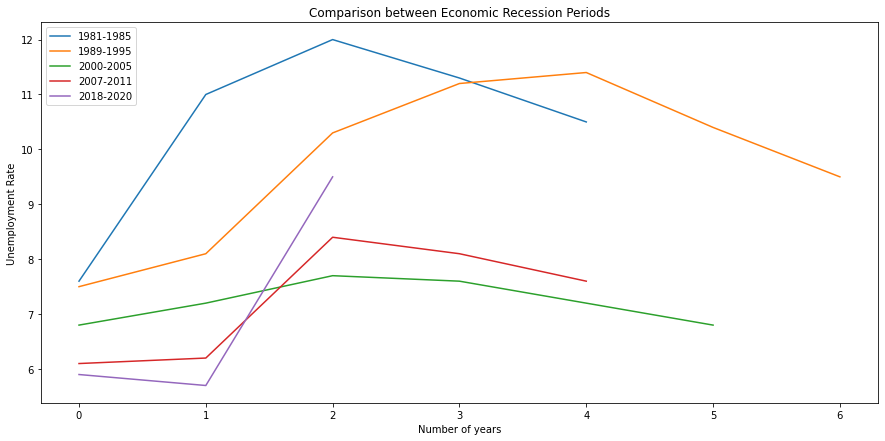

Text(0.5, 1.0, 'Comparison between Economic Recession Periods')

In [0]:
# seems like overall the 1982 recession had the highest unemployment rate followed by the 1990 one. The 2020 recession due to Covid had a the greatest spike in unemployment rate but due to the lowest unemployment rate ever seen over the years, the jump resulted in lower unemployment than the 80 and 90 recessions.
import matplotlib.pyplot as plt 
plt.figure(figsize=(15,7))
plt.plot(_81_85['index'], _81_85.Value, label="1981-1985")
plt.plot(_89_95['index'], _89_95.Value, label="1989-1995")
plt.plot(_00_05['index'], _00_05.Value, label="2000-2005")
plt.plot(_07_11['index'], _07_11.Value, label="2007-2011")
plt.plot(_18_20['index'], _18_20.Value, label="2018-2020")
plt.legend(loc="upper left")
plt.xlabel('Number of years')
plt.ylabel('Unemployment Rate')
plt.title("Comparison between Economic Recession Periods")

In [0]:
def percentage_rate(old, new):
  return ((new - old) / new) * 100

In [0]:
%sql
SELECT `year`, AVG(`Value`)
FROM tb_Cleaned_df
WHERE `Province` LIKE 'Canada'
And `Labour_Force` Like 'Unemployment rate'
and Sex like 'Both sexes'
and Industry like 'Total, all industries'
and Age like '15 years and over'
And year >= 1979 and year <= 1988
GROUP BY year
Order by year 

year avg(Value) 1979 7.5 1980 7.5 1981 7.6 1982 11.0 1983 12.0 1984 11.3 1985 10.5 1986 9.6 1987 8.8 1988 7.8

In [0]:
# -- We have the lowest unemployment rate value being 7.5 in 1980, the value then increased slightly to 7.6 in 1981.
# -- In 1982 after the recession hit the overall unemployment rate increased to 11 and peaked in 1983 at 12

In [0]:
filtered_df = df[(df['Labour_Force'] == 'Unemployment rate')&
                (df['Industry'] == 'Total, all industries') &
                (df['Sex'] == 'Both sexes') &
                 (df['Age'] == '15 years and over') &
                (df['Province'] == 'Canada')]

filtered_df.year[filtered_df.year == 1982].item()

print("The percentge rate difference between the year 1981 and 1982 is %f%%" %(percentage_rate(filtered_df.Value[filtered_df.year == 1981].item(), filtered_df.Value[filtered_df.year == 1982].item())))
print("The percentge rate difference between the year 1981 and peak recession in 1983 is %f%%" %(percentage_rate(filtered_df.Value[filtered_df.year == 1981].item(), filtered_df.Value[filtered_df.year == 1983].item())))

The percentge rate difference between the year 1981 and 1982 is 30.909091%
The percentge rate difference between the year 1981 and peak recession in 1983 is 36.666667%

In [0]:
%sql
SELECT `year`, `Labour_Force`, Sex, Industry, Age, AVG(`Value`)
FROM tb_Cleaned_df
WHERE `Province` LIKE 'Canada'
And `Labour_Force` Like 'Unemployment rate'
and Sex like 'Both sexes'
and Industry like 'Total, all industries'
and Age like '15 years and over'
And year >= 1982
and Value <= 6.8
GROUP BY year, `Labour_Force`, Sex, Industry, Age
Order by year 
-- we see that we have to wait approximately until ~2006 to get back to the pre 1982 unemployment rate recession levels. 
-- That's 24 years

year Labour_Force Sex Industry Age avg(Value) 2000 Unemployment rate Both sexes Total, all industries 15 years and over 6.8 2005 Unemployment rate Both sexes Total, all industries 15 years and over 6.8 2006 Unemployment rate Both sexes Total, all industries 15 years and over 6.3 2007 Unemployment rate Both sexes Total, all industries 15 years and over 6.1 2008 Unemployment rate Both sexes Total, all industries 15 years and over 6.2 2017 Unemployment rate Both sexes Total, all industries 15 years and over 6.4 2018 Unemployment rate Both sexes Total, all industries 15 years and over 5.9 2019 Unemployment rate Both sexes Total, all industries 15 years and over 5.7

In [0]:
%sql
SELECT `year`, AVG(`Value`)
FROM tb_Cleaned_df
WHERE `Province` LIKE 'Canada'
And `Labour_Force` Like 'Unemployment rate'
and Sex like 'Both sexes'
and Industry like 'Total, all industries'
and Age like '15 years and over'
And year >= 1988 and year <= 1998
GROUP BY year
Order by year 
 -- We have the lowest unemployment rate value being 7.50 in 1989, the value then increased to 8.1 in 1990.
-- In 1991 unemployment increased more and reached 10.3. Unemployment rate peaked in 1993 at 11.4

year avg(Value) 1988 7.8 1989 7.5 1990 8.1 1991 10.3 1992 11.2 1993 11.4 1994 10.4 1995 9.5 1996 9.6 1997 9.1 1998 8.3

In [0]:
print("The percentge rate difference between the year 1989 and 1990 is %f%%" %(percentage_rate(filtered_df.Value[filtered_df.year == 1989].item(), filtered_df.Value[filtered_df.year == 1990].item())))
print("The percentge rate difference between the year 1989 and 1991 is %f%%" %(percentage_rate(filtered_df.Value[filtered_df.year == 1989].item(), filtered_df.Value[filtered_df.year == 1991].item())))
print("The percentge rate difference between the year 1989 and 1992 is %f%%" %(percentage_rate(filtered_df.Value[filtered_df.year == 1989].item(), filtered_df.Value[filtered_df.year == 1992].item())))
print("The percentge rate difference between the year 1989 and peak recession in 1993 is %f%%" %(percentage_rate(filtered_df.Value[filtered_df.year == 1981].item(), filtered_df.Value[filtered_df.year == 1983].item())))

The percentge rate difference between the year 1989 and 1990 is 7.407407%
The percentge rate difference between the year 1989 and 1991 is 27.184466%
The percentge rate difference between the year 1989 and 1992 is 33.035714%
The percentge rate difference between the year 1989 and peak recession in 1993 is 36.666667%

In [0]:
%sql
SELECT `year`, `Labour_Force`, Sex, Industry, Age, AVG(`Value`)
FROM tb_Cleaned_df
WHERE `Province` LIKE 'Canada'
And `Labour_Force` Like 'Unemployment rate'
and Sex like 'Both sexes'
and Industry like 'Total, all industries'
and Age like '15 years and over'
And year >= 1990
and Value <= 7.3
GROUP BY year, `Labour_Force`, Sex, Industry, Age
Order by year 
-- we see that we have to wait approximately until ~2000 to get back to the pre 1989 unemployment rate recession levels. 
-- That's 11 years. We have to consider that this second recession we are able to analyze was still affected by the previous recession in 1982, in fact the unemployment 1991 rate levels prior to the recession were higher than the 1982 ante recessin.
-- we also see that in the early 2000s a third recession hit but levels were still lower than 1990 levels
-- in total it took 10 years to get to pre recession unemployment rates

year Labour_Force Sex Industry Age avg(Value) 2000 Unemployment rate Both sexes Total, all industries 15 years and over 6.8 2001 Unemployment rate Both sexes Total, all industries 15 years and over 7.2 2004 Unemployment rate Both sexes Total, all industries 15 years and over 7.2 2005 Unemployment rate Both sexes Total, all industries 15 years and over 6.8 2006 Unemployment rate Both sexes Total, all industries 15 years and over 6.3 2007 Unemployment rate Both sexes Total, all industries 15 years and over 6.1 2008 Unemployment rate Both sexes Total, all industries 15 years and over 6.2 2012 Unemployment rate Both sexes Total, all industries 15 years and over 7.3 2013 Unemployment rate Both sexes Total, all industries 15 years and over 7.1 2014 Unemployment rate Both sexes Total, all industries 15 years and over 6.9 2015 Unemployment rate Both sexes Total, all industries 15 years and over 6.9 2016 Unemployment rate Both sexes Total, all industries 15 years and over 7.1 2017 Unemployment rate Both sexes Total, all industries 15 years and over 6.4 2018 Unemployment rate Both sexes Total, all industries 15 years and over 5.9 2019 Unemployment rate Both sexes Total, all industries 15 years and over 5.7

In [0]:
%sql
SELECT `year`, AVG(`Value`)
FROM tb_Cleaned_df
WHERE `Province` LIKE 'Canada'
And `Labour_Force` Like 'Unemployment rate'
and Sex like 'Both sexes'
and Industry like 'Total, all industries'
and Age like '15 years and over'
And year >= 1999 and year <= 2006
GROUP BY year
Order by year 
-- We have the lowest unemployment rate value, still lowering after the 1990 recession, being 6.80 in 2000, the value then increased to 7.2 in 2001.
-- In 2002 unemployment reached its peak at 7.7. 

year avg(Value) 1999 7.6 2000 6.8 2001 7.2 2002 7.7 2003 7.6 2004 7.2 2005 6.8 2006 6.3

In [0]:
print("The percentge rate difference between the year 2000 and 2001 is %f%%" %(percentage_rate(filtered_df.Value[filtered_df.year == 2000].item(), filtered_df.Value[filtered_df.year == 2001].item())))
print("The percentge rate difference between the year 2000 and peak recession in 2002 is %f%%" %(percentage_rate(filtered_df.Value[filtered_df.year == 2000].item(), filtered_df.Value[filtered_df.year == 2002].item())))

The percentge rate difference between the year 2000 and 2001 is 5.555556%
The percentge rate difference between the year 2000 and peak recession in 2002 is 11.688312%

In [0]:
%sql
SELECT `year`, `Labour_Force`, Sex, Industry, Age, AVG(`Value`)
FROM tb_Cleaned_df
WHERE `Province` LIKE 'Canada'
And `Labour_Force` Like 'Unemployment rate'
and Sex like 'Both sexes'
and Industry like 'Total, all industries'
and Age like '15 years and over'
And year > 2000
and Value <= 6.8
GROUP BY year, `Labour_Force`, Sex, Industry, Age
Order by year 
-- unemployment reached ante recession levels in 2005 with 6.8, which is the same rate as before the recession but keeps decreasing after that
-- overall it took 5 years to recover

year Labour_Force Sex Industry Age avg(Value) 2005 Unemployment rate Both sexes Total, all industries 15 years and over 6.8 2006 Unemployment rate Both sexes Total, all industries 15 years and over 6.3 2007 Unemployment rate Both sexes Total, all industries 15 years and over 6.1 2008 Unemployment rate Both sexes Total, all industries 15 years and over 6.2 2017 Unemployment rate Both sexes Total, all industries 15 years and over 6.4 2018 Unemployment rate Both sexes Total, all industries 15 years and over 5.9 2019 Unemployment rate Both sexes Total, all industries 15 years and over 5.7

In [0]:
%sql
SELECT year, avg(Value)
FROM tb_Cleaned_df
WHERE `Province` LIKE 'Canada'
And `Labour_Force` Like 'Unemployment rate'
and Sex like 'Both sexes'
and Industry like 'Total, all industries'
and Age like '15 years and over'
And year >= 2006 and year <= 2012
GROUP BY year
Order by year 
-- in 2006 unemployment rate was at 6.1 the lowest since the 1980 recession. Unemployment spikes up in 2009 to 8.4 and later decreases the following years

year avg(Value) 2006 6.3 2007 6.1 2008 6.2 2009 8.4 2010 8.1 2011 7.6 2012 7.3

In [0]:
print("The percentge rate difference between the year 2007 and 2008 is %f%%" %(percentage_rate(filtered_df.Value[filtered_df.year == 2007].item(), filtered_df.Value[filtered_df.year == 2008].item())))
print("The percentge rate difference between the year 2007 and peak recession in 2009 is %f%%" %(percentage_rate(filtered_df.Value[filtered_df.year == 2007].item(), filtered_df.Value[filtered_df.year == 2009].item())))

The percentge rate difference between the year 2007 and 2008 is 1.612903%
The percentge rate difference between the year 2007 and peak recession in 2009 is 27.380952%

In [0]:
%sql
SELECT `year`, `Labour_Force`, Sex, Industry, Age, AVG(`Value`)
FROM tb_Cleaned_df
WHERE `Province` LIKE 'Canada'
And `Labour_Force` Like 'Unemployment rate'
and Sex like 'Both sexes'
and Industry like 'Total, all industries'
and Age like '15 years and over'
And year > 2007
and Value <= 6.1
GROUP BY year, `Labour_Force`, Sex, Industry, Age
Order by year 
 -- only recently in 2018 has the unemployment rate recovered to before recession levels. With 5.9 being the lowest unemployment has ever been up to 2018.
-- again 10 years to recover from the 2008 recession

year Labour_Force Sex Industry Age avg(Value) 2018 Unemployment rate Both sexes Total, all industries 15 years and over 5.9 2019 Unemployment rate Both sexes Total, all industries 15 years and over 5.7

In [0]:
%sql
SELECT year, avg(Value)
FROM tb_Cleaned_df
WHERE `Province` LIKE 'Canada'
And `Labour_Force` Like 'Unemployment rate'
and Sex like 'Both sexes'
and Industry like 'Total, all industries'
and Age like '15 years and over'
And year >= 2018 and year <= 2020
GROUP BY year
Order by year 

year avg(Value) 2018 5.9 2019 5.7 2020 9.5

In [0]:
print("The percentge rate difference between the year 2019 and peak recession in 2020 is %f%%" %(percentage_rate(filtered_df.Value[filtered_df.year == 2019].item(), filtered_df.Value[filtered_df.year == 2020].item())))

The percentge rate difference between the year 2019 and peak recession in 2020 is 40.000000%

F.  Prediction of Unemployment Rates

1.  Using Time series

In [0]:
labour = Cleaned_df.filter((Cleaned_df['Industry']=='Total, all industries')& (Cleaned_df['Sex']=='Both sexes')& (Cleaned_df['Age']=='15 years and over') )

labour = labour.select(col('year'),
                    col('Province'),
                    col('Labour_Force'),
                    col('Value'))
unemp= labour.filter(labour['Province'] == ('Canada')).filter(labour['Labour_Force'] == ('Unemployment rate') )

In [0]:
unemployment = Cleaned_df.select(col('year'), 
                               col('Province'),  
                               col('Sex'), 
                               col('Age'), 
                               col('Labour_Force'),
                               col('Industry'), 
                               col('Unit'),
                               col('Value')).filter(Cleaned_df['Province'] == ('Canada')).filter(Cleaned_df['Sex'] == ('Both sexes')).filter(Cleaned_df['Age'] == ('15 years and over')).filter(Cleaned_df['Labour_Force'] == ('Unemployment')).filter(Cleaned_df['Industry'] == ('Total, all industries'))
 
unemployment = unemployment.select(col('year'),  
                               col('Value'))

In [0]:
unemp.cache()

Out[40]: DataFrame[year: int, Province: string, Labour_Force: string, Value: double]

In [0]:
# preparing data for time series analysis
# unemp = unemp.groupby('year').avg('Value').sort('year')
unemp_pd = unemp.toPandas().set_index('year')
unemp_pd.rename({'avg(Value)':'Value'},axis=1, inplace=True)
#unemp_pd.head()

In [0]:
short= unemp_pd.Value.rolling(window = 5)
long = unemp_pd.Value.rolling(window = 10)
 
unemp_pd['sma_short'] = short.mean()
unemp_pd['sma_long'] = long.mean()

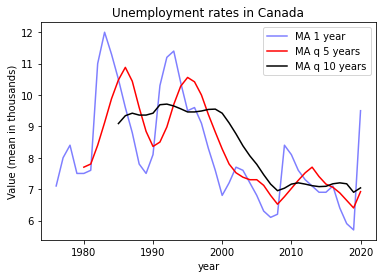

In [0]:
plt.plot(unemp_pd.index, unemp_pd.Value, color = 'blue', alpha = 0.5, label = 'MA 1 year');
plt.plot(unemp_pd.index, unemp_pd.sma_short, color = 'red', label = 'MA q 5 years');
plt.plot(unemp_pd.index, unemp_pd.sma_long, color = 'black', label = 'MA q 10 years')
plt.xlabel('year')
plt.ylabel('Value (mean in thousands)')
plt.title('Unemployment rates in Canada')
plt.legend();
# shows 1 year/ 5 year/ 10 year trends in Labour value

In [0]:
unemp_pd.Value.autocorr()

Out[45]: 0.7881623114807838

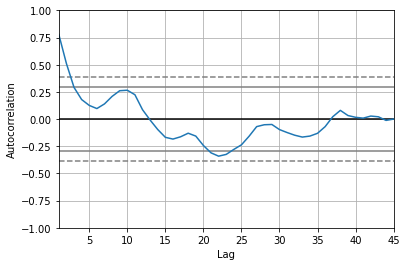

In [0]:
pd.plotting.autocorrelation_plot(unemp_pd.Value);
# there is significant autocorrelation for unemployment until a lag of 2 years

Out[47]:

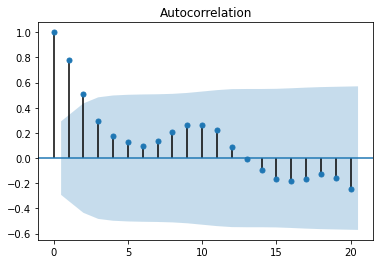

<Figure size 432x288 with 1 Axes>

In [0]:
tsaplots.plot_acf(unemp_pd.Value, lags = 20)

Out[48]:

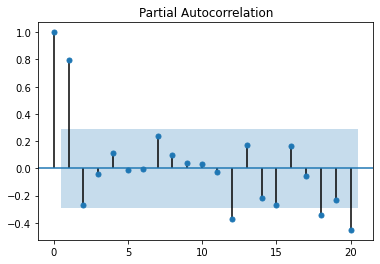

<Figure size 432x288 with 1 Axes>

In [0]:
tsaplots.plot_pacf(unemp_pd.Value, lags = 20)
# (+) significant partial autocorrelation to lag1

In [0]:
import datetime
unemp_pd2 = unemp.toPandas()
unemp_pd2['year'] =pd.to_datetime(unemp_pd2['year'])
unemp_pd2.set_index('year')
unemp_pd2.rename({'avg(Value)':'Value'},axis=1, inplace=True)
# did not do early conversion to datetime because found it is lost as an index

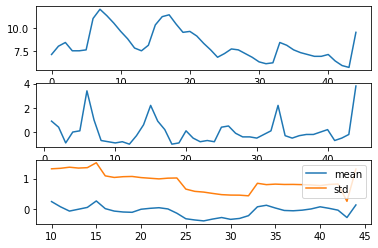

In [0]:
fig, (ax1, ax2, ax3)=plt.subplots(3,1)
unemp_pd2.Value.plot(ax=ax1)
unemp_pd2.Value.diff().plot(ax=ax2, label = 'difference')
unemp_pd2.Value.diff().rolling(10).mean().plot(ax=ax3, label = 'mean')
unemp_pd2.Value.diff().rolling(10).std().plot(ax = ax3, label = 'std')
plt.legend();
# relatively stationary std -> no need to transform values

In [0]:
# preparing for ARIMA forecasting
n = np.int(len(unemp_pd2) * 0.7)
train, test = unemp_pd2.iloc[:n], unemp_pd2.iloc[n:]

In [0]:
# using baseline order 1,1,1
import warnings
warnings.filterwarnings('ignore')
arima = ARIMA(train.Value.dropna().astype(float), order = (1,1,1))
arima_fit = arima.fit(disp=1, maxiter=100)
#arima_fit.summary()

pred, err, conf = arima_fit.forecast()
print('Predicted value: ', pred)
print('Std of prediction: ', err)
print('CI: ', conf)

te = test.Value.iloc[0]
error = pred - te
print('Actual Value: ', te)
print('Absolute error: ', np.abs(error))
print('Relative error: %1.2f%%' %(np.abs(error) / te * 100))
# trialing of other model parameters based on pacf and acf did not yield a better result

Predicted value: [6.08710049]
Std of prediction: [0.87556859]
CI: [[4.37101759 7.80318339]]
Actual Value: 6.1
Absolute error: [0.01289951]
Relative error: 0.21%

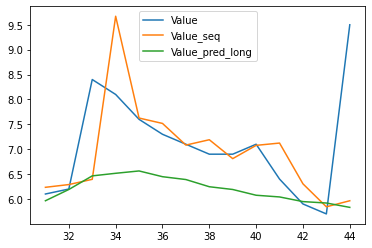

In [0]:
# getting sequential predictions
trains = list(train.Value.dropna().astype(float))
pred_short = []

for i in range(len(test)):
   arima = ARIMA(trains, order = (3,1,2))
   arima_fit = arima.fit(disp = 1, maxiter = 500)
   pred_short.append(arima_fit.forecast()[0][0])
   trains.append(test['Value'].iloc [i] )
  
test['Value_seq'] = pred_short

# getting long-term predictions
pred_long, _, _ = arima_fit.forecast(steps = len(test))
test['Value_pred_long'] = pred_long
test[['Value', 'Value_seq', 'Value_pred_long']].plot();
# order 312 provides a better fit for long-term prediction than 111

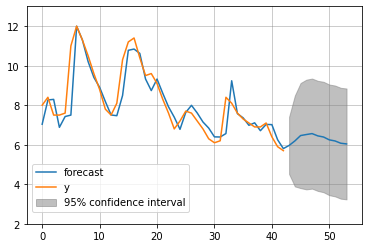

In [0]:
arima_fit.plot_predict(1,54)
plt.ylim(2,13)
plt.legend(bbox_to_anchor=(0.5,0.3))
plt.grid(color='gray', alpha = 0.5);
# predicting for the next 10 years: unemployment rates could be a value in the range from 10 - 21% by 2031 (95% CI).

2.Predicting Unemployment rates/ recession using FBProphet

In [0]:
Cleaned_df.createOrReplaceTempView("data")

In [0]:
# need to run this and intall pystan to be able to use Prophet
%pip install pystan==2.19.1.1

Python interpreter will be restarted.
Collecting pystan==2.19.1.1
 Downloading pystan-2.19.1.1-cp38-cp38-manylinux1_x86_64.whl (62.6 MB)
Requirement already satisfied: Cython!=0.25.1,>=0.22 in /databricks/python3/lib/python3.8/site-packages (from pystan==2.19.1.1) (0.29.21)
Requirement already satisfied: numpy>=1.7 in /databricks/python3/lib/python3.8/site-packages (from pystan==2.19.1.1) (1.19.2)
Installing collected packages: pystan
Successfully installed pystan-2.19.1.1
WARNING: You are using pip version 20.2.4; however, version 21.0.1 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-7f3ae74d-8665-4e71-b97c-2cb44bfdec02/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.

In [0]:
# need to run this to use prophet
%pip install fbprophet

Python interpreter will be restarted.
Collecting fbprophet
 Downloading fbprophet-0.7.1.tar.gz (64 kB)
Requirement already satisfied: Cython>=0.22 in /databricks/python3/lib/python3.8/site-packages (from fbprophet) (0.29.21)
Collecting cmdstanpy==0.9.5
 Downloading cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
Requirement already satisfied: pystan>=2.14 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-7f3ae74d-8665-4e71-b97c-2cb44bfdec02/lib/python3.8/site-packages (from fbprophet) (2.19.1.1)
Requirement already satisfied: numpy>=1.15.4 in /databricks/python3/lib/python3.8/site-packages (from fbprophet) (1.19.2)
Requirement already satisfied: pandas>=1.0.4 in /databricks/python3/lib/python3.8/site-packages (from fbprophet) (1.1.3)
Requirement already satisfied: matplotlib>=2.0.0 in /databricks/python3/lib/python3.8/site-packages (from fbprophet) (3.2.2)
Collecting LunarCalendar>=0.0.9
 Downloading LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
Collecting convertdate>=2.1.2
 Downloading convertdate-2.3.2-py3-none-any.whl (47 kB)
Collecting holidays>=0.10.2
 Downloading holidays-0.11.1-py3-none-any.whl (133 kB)
Collecting setuptools-git>=1.2
 Downloading setuptools_git-1.2-py2.py3-none-any.whl (10 kB)
Requirement already satisfied: python-dateutil>=2.8.0 in /databricks/python3/lib/python3.8/site-packages (from fbprophet) (2.8.1)
Collecting tqdm>=4.36.1
 Downloading tqdm-4.60.0-py2.py3-none-any.whl (75 kB)
Requirement already satisfied: pytz>=2017.2 in /databricks/python3/lib/python3.8/site-packages (from pandas>=1.0.4->fbprophet) (2020.5)
Requirement already satisfied: cycler>=0.10 in /databricks/python3/lib/python3.8/site-packages (from matplotlib>=2.0.0->fbprophet) (0.10.0)
Requirement already satisfied: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib>=2.0.0->fbprophet) (2.4.7)
Requirement already satisfied: kiwisolver>=1.0.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib>=2.0.0->fbprophet) (1.3.0)
Collecting ephem>=3.7.5.3
 Downloading ephem-3.7.7.1-cp38-cp38-manylinux2010_x86_64.whl (1.2 MB)
Collecting pymeeus<=1,>=0.3.13
 Downloading PyMeeus-0.5.11.tar.gz (5.4 MB)
Collecting korean-lunar-calendar
 Downloading korean_lunar_calendar-0.2.1-py3-none-any.whl (8.0 kB)
Requirement already satisfied: six in /usr/local/lib/python3.8/site-packages (from holidays>=0.10.2->fbprophet) (1.15.0)
Collecting hijri-converter
 Downloading hijri_converter-2.1.1-py3-none-any.whl (14 kB)
Building wheels for collected packages: fbprophet, pymeeus
 Building wheel for fbprophet (setup.py): started
 Building wheel for fbprophet (setup.py): finished with status 'error'
 ERROR: Command errored out with exit status 1:
 command: /local_disk0/.ephemeral_nfs/envs/pythonEnv-7f3ae74d-8665-4e71-b97c-2cb44bfdec02/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-y0yh756n/fbprophet/setup.py'"'"'; __file__='"'"'/tmp/pip-install-y0yh756n/fbprophet/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-4azal900
 cwd: /tmp/pip-install-y0yh756n/fbprophet/
 Complete output (44 lines):
 running bdist_wheel
 running build
 running build_py
 creating build
 creating build/lib
 creating build/lib/fbprophet
 creating build/lib/fbprophet/stan_model
 Traceback (most recent call last):
 File "<string>", line 1, in <module>
 File "/tmp/pip-install-y0yh756n/fbprophet/setup.py", line 122, in <module>
 setup(
 File "/databricks/python/lib/python3.8/site-packages/setuptools/__init__.py", line 153, in setup
 return distutils.core.setup(**attrs)
 File "/usr/local/lib/python3.8/distutils/core.py", line 148, in setup
 dist.run_commands()
 File "/usr/local/lib/python3.8/distutils/dist.py", line 966, in run_commands
 self.run_command(cmd)
 File "/usr/local/lib/python3.8/distutils/dist.py", line 985, in run_command
 cmd_obj.ru

In [0]:
def askTheOracle(df, interval, periods, daily, weekly, yearly, frequency, xLabel, yLabel):
  # instantiate the model and set parameters
  model = Prophet(
    interval_width=interval,
    growth='linear',
    daily_seasonality=daily,
    weekly_seasonality=weekly,
    yearly_seasonality=yearly,
    seasonality_mode='multiplicative'
  )
 
  # fit the model to historical data
  model.fit(df)
 
  future_pd = model.make_future_dataframe(
    periods=periods,
    freq=frequency,
    include_history=True
  )
 
  # predict over the dataset
  forecast_pd = model.predict(future_pd)
  predict_fig = model.plot(forecast_pd, xlabel=xLabel, ylabel=yLabel)
  display(predict_fig)

In [0]:
unemployment = Cleaned_df.select(col('year'), 
                               col('Province'),  
                               col('Sex'), 
                               col('Age'), 
                               col('Labour_Force'),
                               col('Industry'), 
                               col('Unit'),
                               col('Value')).filter(Cleaned_df['Province'] == ('Canada')).filter(Cleaned_df['Sex'] == ('Both sexes')).filter(Cleaned_df['Age'] == ('15 years and over')).filter(Cleaned_df['Labour_Force'] == ('Unemployment')).filter(Cleaned_df['Industry'] == ('Total, all industries'))
 
unemployment = unemployment.select(col('year'),  
                               col('Value'))
unemployment.persist()
unemploymentRate = Cleaned_df.select(col('year'), 
                               col('Province'),  
                               col('Sex'), 
                               col('Age'), 
                               col('Labour_Force'),
                               col('Industry'), 
                               col('Unit'),
                               col('Value')).filter(Cleaned_df['Province'] == ('Canada')).filter(Cleaned_df['Sex'] == ('Both sexes')).filter(Cleaned_df['Age'] == ('15 years and over')).filter(Cleaned_df['Labour_Force'] == ('Unemployment rate')).filter(Cleaned_df['Industry'] == ('Total, all industries'))
 
unemploymentRate = unemploymentRate.select(col('year'),  
                               col('Value'))

In [0]:
# changing the names of the x and y columns to use with prophet
unemployment_pd = unemploymentRate.toPandas()
unemployment_pd.rename(columns={'year':'ds','Value':'y'}, inplace=True)
unemployment_pd.reset_index(inplace=True)

In [0]:
unemployment_pd.drop(columns=['index'], inplace=True)

In [0]:
 unemployment_pd.ds = pd.to_datetime(unemployment_pd.ds, format='%Y')

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p

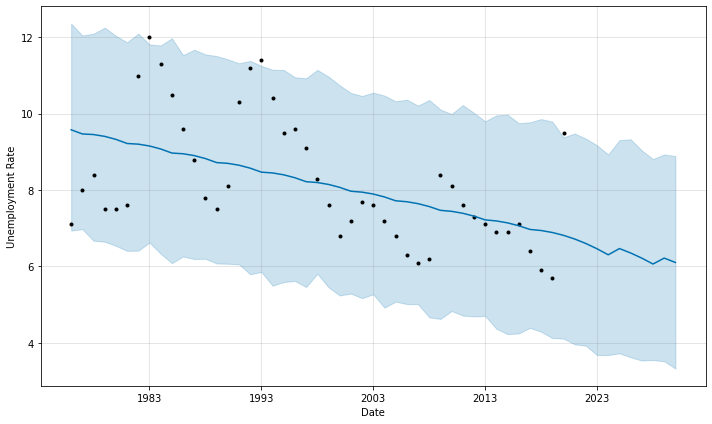

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

In [0]:
from fbprophet import Prophet
askTheOracle(unemployment_pd, 0.95, 10, False, False, True, 'y', 'Date', 'Unemployment Rate')

In [0]:
unemployment_by1000_pd = unemployment.toPandas()
unemployment_by1000_pd.rename(columns={'year':'ds','Value':'y'}, inplace=True)
unemployment_by1000_pd.ds = pd.to_datetime(unemployment_pd.ds, format='%Y')

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

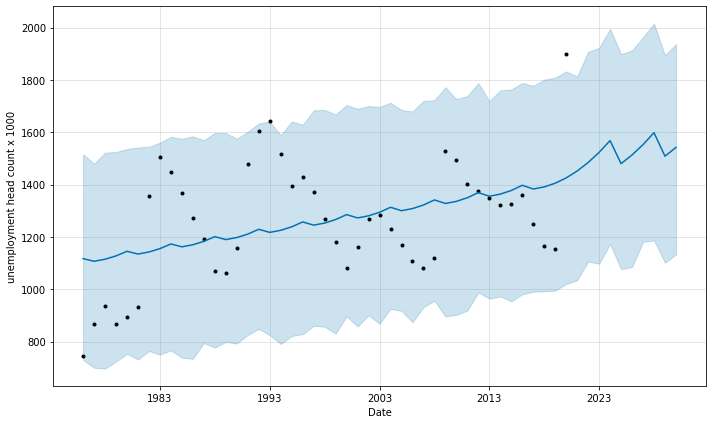

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

In [0]:
askTheOracle(unemployment_by1000_pd, 0.95, 10, False, False, True, 'y', 'Date', 'unemployment head count x 1000')

In [0]:
#labour data file by monht was too big even compressed so had to split it inot two files which I'll later merge
url1 = 'https://github.com/thefabscientist/Waterloo-DS3-Group-1-Project/blob/main/labour_part1.csv.gz?raw=true'
url2 = 'https://github.com/thefabscientist/Waterloo-DS3-Group-1-Project/blob/main/labour_part2.csv.gz?raw=true'
url3 = 'https://github.com/thefabscientist/Waterloo-DS3-Group-1-Project/blob/main/labour_part3.csv.gz?raw=true'
url4 = 'https://github.com/thefabscientist/Waterloo-DS3-Group-1-Project/blob/main/labour_part4.csv.gz?raw=true'
part1 = pd.read_csv(url1,compression='gzip')
part2 = pd.read_csv(url2,compression='gzip')
part3 = pd.read_csv(url3,compression='gzip')
part4 = pd.read_csv(url4,compression='gzip')

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p

In [0]:
merged = part1.append(part2, ignore_index=True)
merged = merged.append(part3, ignore_index=True)

merged = merged.append(part4, ignore_index=True)
merged['Labour force characteristics'].unique()

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p

In [0]:
spark_monthly_df = spark.createDataFrame(merged)
display(spark_monthly_df)

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p

Unnamed: 0 REF_DATE GEO DGUID Labour force characteristics Sex Age group Statistics Data type UOM UOM_ID SCALAR_FACTOR SCALAR_ID VECTOR COORDINATE VALUE STATUS SYMBOL TERMINATED DECIMALS 0 1976-01 Canada 2016A000011124 Population Both sexes 15 years and over Estimate Seasonally adjusted Persons 249 thousands 3 v2062809 1.1.1.1.1.1 16852.4 null null null 1 1 1976-01 Canada 2016A000011124 Population Both sexes 15 years and over Estimate Unadjusted Persons 249 thousands 3 v2064888 1.1.1.1.1.2 16852.4 null null null 1 2 1976-01 Canada 2016A000011124 Population Both sexes 15 to 64 years Estimate Seasonally adjusted Persons 249 thousands 3 v21580997 1.1.1.8.1.1 15015.9 null null null 1 3 1976-01 Canada 2016A000011124 Population Both sexes 15 to 64 years Estimate Unadjusted Persons 249 thousands 3 v21580998 1.1.1.8.1.2 15015.9 null null null 1 4 1976-01 Canada 2016A000011124 Population Both sexes 15 to 24 years Estimate Seasonally adjusted Persons 249 thousands 3 v2062836 1.1.1.2.1.1 4509.9 null null null 1 5 1976-01 Canada 2016A000011124 Population Both sexes 15 to 24 years Estimate Unadjusted Persons 249 thousands 3 v2064915 1.1.1.2.1.2 4509.9 null null null 1 6 1976-01 Canada 2016A000011124 Population Both sexes 15 to 19 years Estimate Seasonally adjusted Persons 249 thousands 3 v2062863 1.1.1.3.1.1 2330.0 null null null 1 7 1976-01 Canada 2016A000011124 Population Both sexes 15 to 19 years Estimate Unadjusted Persons 249 thousands 3 v2064942 1.1.1.3.1.2 2330.0 null null null 1 8 1976-01 Canada 2016A000011124 Population Both sexes 20 to 24 years Estimate Seasonally adjusted Persons 249 thousands 3 v2062890 1.1.1.4.1.1 2179.8 null null null 1 9 1976-01 Canada 2016A000011124 Population Both sexes 20 to 24 years Estimate Unadjusted Persons 249 thousands 3 v2064969 1.1.1.4.1.2 2179.8 null null null 1 10 1976-01 Canada 2016A000011124 Population Both sexes 25 years and over Estimate Seasonally adjusted Persons 249 thousands 3 v2062917 1.1.1.5.1.1 12342.5 null null null 1 11 1976-01 Canada 2016A000011124 Population Both sexes 25 years and over Estimate Unadjusted Persons 249 thousands 3 v2064996 1.1.1.5.1.2 12342.5 null null null 1 12 1976-01 Canada 2016A000011124 Population Both sexes 25 to 54 years Estimate Seasonally adjusted Persons 249 thousands 3 v2062944 1.1.1.6.1.1 8619.1 null null null 1 13 1976-01 Canada 2016A000011124 Population Both sexes 25 to 54 years Estimate Unadjusted Persons 249 thousands 3 v2065023 1.1.1.6.1.2 8619.1 null null null 1 14 1976-01 Canada 2016A000011124 Population Both sexes 55 years and over Estimate Seasonally adjusted Persons 249 thousands 3 v2062971 1.1.1.7.1.1 3723.4 null null null 1 15 1976-01 Canada 2016A000011124 Population Both sexes 55 years and over Estimate Unadjusted Persons 249 thousands 3 v2065050 1.1.1.7.1.2 3723.4 null null null 1 16 1976-01 Canada 2016A000011124 Population Both sexes 55 to 64 years Estimate Seasonally adjusted Persons 249 thousands 3 v101884802 1.1.1.9.1.1 1886.9 null null null 1 17 1976-01 Canada 2016A000011124 Population Both sexes 55 to 64 years Estimate Unadjusted Persons 249 thousands 3 v101884803 1.1.1.9.1.2 1886.9 null null null 1 18 1976-01 Canada 2016A000011124 Population Males 15 years and over Estimate Seasonally adjusted Persons 249 thousands 3 v2062818 1.1.2.1.1.1 8334.7 null null null 1 19 1976-01 Canada 2016A000011124 Population Males 15 years and over Estimate Unadjusted Persons 249 thousands 3 v2064897 1.1.2.1.1.2 8334.7 null null null 1 20 1976-01 Canada 2016A000011124 Population Males 15 to 64 years Estimate Seasonally adjusted Persons 249 thousands 3 v21580999 1.1.2.8.1.1 7513.0 null null null 1 21 1976-01 Canada 2016A000011124 Population Males 15 to 64 years Estimate Unadjusted Persons 249 thousands 3 v21581000 1.1.2.8.1.2 7513.0 null null null 1 22 1976-01 Canada 2016A000011124 Population Males 15 to 24 years Estimate Seasonally adjusted Persons 249 thousands 3 v2062845 1.1.2.2.1.1 2273.5 null null null 1 23 1976-01 Canada 2016A000011124 Population M

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

In [0]:
spark_monthly_df = spark_monthly_df.drop('Unnamed: 0', 'DGUID', 'UOM_ID', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'STATUS' , 'SYMBOL', 'TERMINATED', 'DECIMALS')
display(spark_monthly_df)

REF_DATE GEO Labour force characteristics Sex Age group Statistics Data type UOM SCALAR_FACTOR VALUE 1976-01 Canada Population Both sexes 15 years and over Estimate Seasonally adjusted Persons thousands 16852.4 1976-01 Canada Population Both sexes 15 years and over Estimate Unadjusted Persons thousands 16852.4 1976-01 Canada Population Both sexes 15 to 64 years Estimate Seasonally adjusted Persons thousands 15015.9 1976-01 Canada Population Both sexes 15 to 64 years Estimate Unadjusted Persons thousands 15015.9 1976-01 Canada Population Both sexes 15 to 24 years Estimate Seasonally adjusted Persons thousands 4509.9 1976-01 Canada Population Both sexes 15 to 24 years Estimate Unadjusted Persons thousands 4509.9 1976-01 Canada Population Both sexes 15 to 19 years Estimate Seasonally adjusted Persons thousands 2330.0 1976-01 Canada Population Both sexes 15 to 19 years Estimate Unadjusted Persons thousands 2330.0 1976-01 Canada Population Both sexes 20 to 24 years Estimate Seasonally adjusted Persons thousands 2179.8 1976-01 Canada Population Both sexes 20 to 24 years Estimate Unadjusted Persons thousands 2179.8 1976-01 Canada Population Both sexes 25 years and over Estimate Seasonally adjusted Persons thousands 12342.5 1976-01 Canada Population Both sexes 25 years and over Estimate Unadjusted Persons thousands 12342.5 1976-01 Canada Population Both sexes 25 to 54 years Estimate Seasonally adjusted Persons thousands 8619.1 1976-01 Canada Population Both sexes 25 to 54 years Estimate Unadjusted Persons thousands 8619.1 1976-01 Canada Population Both sexes 55 years and over Estimate Seasonally adjusted Persons thousands 3723.4 1976-01 Canada Population Both sexes 55 years and over Estimate Unadjusted Persons thousands 3723.4 1976-01 Canada Population Both sexes 55 to 64 years Estimate Seasonally adjusted Persons thousands 1886.9 1976-01 Canada Population Both sexes 55 to 64 years Estimate Unadjusted Persons thousands 1886.9 1976-01 Canada Population Males 15 years and over Estimate Seasonally adjusted Persons thousands 8334.7 1976-01 Canada Population Males 15 years and over Estimate Unadjusted Persons thousands 8334.7 1976-01 Canada Population Males 15 to 64 years Estimate Seasonally adjusted Persons thousands 7513.0 1976-01 Canada Population Males 15 to 64 years Estimate Unadjusted Persons thousands 7513.0 1976-01 Canada Population Males 15 to 24 years Estimate Seasonally adjusted Persons thousands 2273.5 1976-01 Canada Population Males 15 to 24 years Estimate Unadjusted Persons thousands 2273.5 1976-01 Canada Population Males 15 to 19 years Estimate Seasonally adjusted Persons thousands 1183.6 1976-01 Canada Population Males 15 to 19 years Estimate Unadjusted Persons thousands 1183.6 1976-01 Canada Population Males 20 to 24 years Estimate Seasonally adjusted Persons thousands 1089.9 1976-01 Canada Population Males 20 to 24 years Estimate Unadjusted Persons thousands 1089.9 1976-01 Canada Population Males 25 years and over Estimate Seasonally adjusted Persons thousands 6061.2 1976-01 Canada Population Males 25 years and over Estimate Unadjusted Persons thousands 6061.2 1976-01 Canada Population Males 25 to 54 years Estimate Seasonally adjusted Persons thousands 4325.5 1976-01 Canada Population Males 25 to 54 years Estimate Unadjusted Persons thousands 4325.5 1976-01 Canada Population Males 55 years and over Estimate Seasonally adjusted Persons thousands 1735.7 1976-01 Canada Population Males 55 years and over Estimate Unadjusted Persons thousands 1735.7 1976-01 Canada Population Males 55 to 64 years Estimate Seasonally adjusted Persons thousands 914.0 1976-01 Canada Population Males 55 to 64 years Estimate Unadjusted Persons thousands 914.0 1976-01 Canada Population Females 15 years and over Estimate Seasonally adjusted Persons thousands 8517.7 1976-01 Canada Population Females 15 years and over Estimate Unadjusted Persons thousands 8517.7 1976-01 Canada Population Females 15 to 64 years Estimate Seasonally adjusted Persons thousa

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

In [0]:
#Rename columns
spark_monthly_df = spark_monthly_df.select(col('REF_DATE').alias('Date'),
                   col('GEO').alias('Province'),
                   col('Labour force characteristics').alias('LC'),
                   col('Sex'),
                   col('Age group').alias('Age'),
                   col('Statistics'),
                   col('Data type').alias('Data'),
                   col('UOM').alias('Unit'),
                   col('SCALAR_FACTOR').alias('Scale'),
                   col('VALUE').alias('Value'))

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

In [0]:
spark_monthly_df.persist()

Out[26]: DataFrame[Date: string, Province: string, LC: string, Sex: string, Age: string, Statistics: string, Data: string, Unit: string, Scale: string, Value: double]INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

In [0]:
unemployment_monthly = spark_monthly_df.select(col('Date'), 
                               col('Province'),  
                               col('LC'),
                               col('Sex'), 
                               col('Age'), 
                               col('Statistics'), 
                               col('Data'), 
                               col('Unit'),
                               col('Scale'),
                               col('Value')).filter(spark_monthly_df['Province'] == ('Canada')).filter(spark_monthly_df['LC'] == ('Unemployment')).filter(spark_monthly_df['Sex'] == ('Both sexes')).filter(spark_monthly_df['Age'] == ('15 years and over')).filter(spark_monthly_df['Statistics'] == ('Estimate')).filter(spark_monthly_df['Data'] == ('Seasonally adjusted'))

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

In [0]:
unemployment_monthly = unemployment_monthly.select(col('Date'),  col('Value'))
monthly_unemployment_pd = unemployment_monthly.toPandas()
monthly_unemployment_pd.rename(columns={'Date':'ds','Value':'y'}, inplace=True)

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p

ds 
 y 
 
 
 
 
 0 
 1976-01 
 733.0 
 
 
 1 
 1976-02 
 730.0 
 
 
 2 
 1976-03 
 691.5 
 
 
 3 
 1976-04 
 713.1 
 
 
 4 
 1976-05 
 720.0 
 
 
 ... 
 ... 
 ... 
 
 
 534 
 2020-07 
 2183.6 
 
 
 535 
 2020-08 
 2046.9 
 
 
 536 
 2020-09 
 1832.6 
 
 
 537 
 2020-10 
 1816.8 
 
 
 538 
 2020-11 
 1735.2 
 
 
 
 539 rows × 2 columns

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p

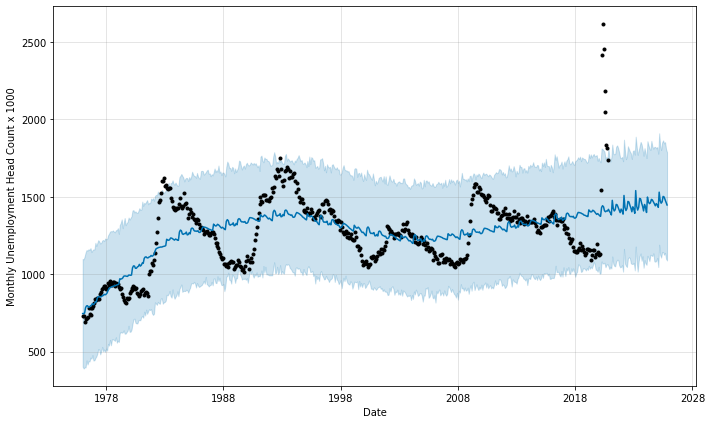

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

In [0]:
askTheOracle(monthly_unemployment_pd, 0.95, 60, False, False, True, 'm', 'Date', 'Monthly Unemployment Head Count x 1000')

In [0]:
unemployment_rate_monthly = spark_monthly_df.select(col('Date'), 
                               col('Province'),  
                               col('LC'),
                               col('Sex'), 
                               col('Age'), 
                               col('Statistics'), 
                               col('Data'), 
                               col('Unit'),
                               col('Scale'),
                               col('Value')).filter(spark_monthly_df['Province'] == ('Canada')).filter(spark_monthly_df['LC'] == ('Unemployment rate')).filter(spark_monthly_df['Sex'] == ('Both sexes')).filter(spark_monthly_df['Age'] == ('15 years and over')).filter(spark_monthly_df['Statistics'] == ('Estimate')).filter(spark_monthly_df['Data'] == ('Seasonally adjusted'))

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

In [0]:
unemployment_rate_monthly = unemployment_rate_monthly.select(col('Date'),  col('Value'))
monthly_unemployment_rate_pd = unemployment_rate_monthly.toPandas()
monthly_unemployment_rate_pd.rename(columns={'Date':'ds','Value':'y'}, inplace=True)

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p

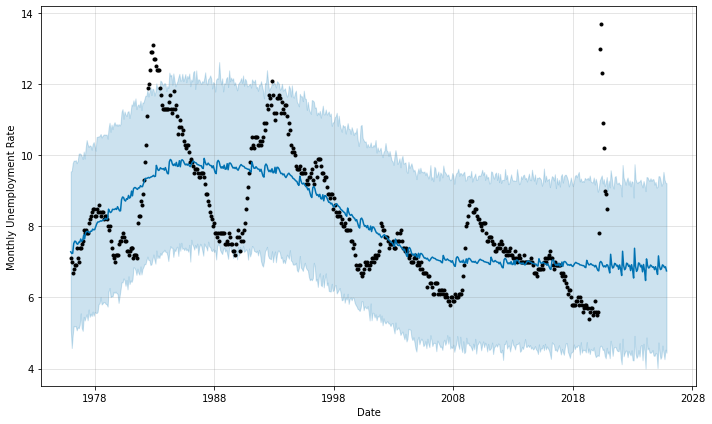

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

In [0]:
askTheOracle(monthly_unemployment_rate_pd, 0.95, 60, False, False, True, 'm', 'Date', 'Monthly Unemployment Rate')

In [0]:
quarterly_unemployment_pd =  monthly_unemployment_rate_pd.set_index('ds')
quarterly_unemployment_pd.index = pd.to_datetime(quarterly_unemployment_pd.index)

quarterly_unemployment_pd = quarterly_unemployment_pd.resample('Q').mean()
quarterly_unemployment_pd.reset_index(inplace=True)

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

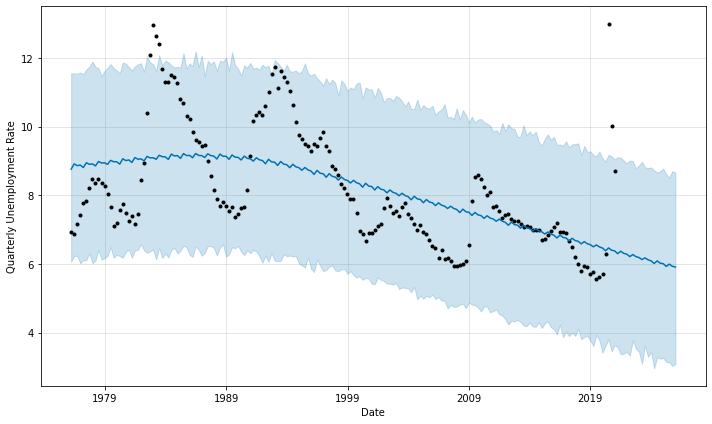

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

In [0]:
askTheOracle(quarterly_unemployment_pd, 0.95, 20, False, False, True, 'q', 'Date', 'Quarterly Unemployment Rate')

3.Prediction of Unemployment rates using Machine Learning Methods:

a.  Linear Regression Analysis

In [0]:
#linear regression, get top 5 most full-time employed industries (stand-in for most important) in previous year and their unemployment rate in previous year
#http://www.silota.com/docs/recipes/sql-top-n-group.html

#inner query is to rank industries in each year & region by number of full-time employees, ignoring aggregate categories
#outer query selects top 5 industries (5 as a nice round number, didn't want to include too many industries or else time to run regression would increase substantially)
#did not take actual employment numbers, as those would just be increasing over time
top_5=spark.sql("select Year,Province,Classification,value_rank from (select Year,Province,Value,Classification,row_number() over (partition by (Province,Year) order by Value desc) as value_rank from spdf where Province in ('Canada','Ontario') and LF_Char like 'Full-time employment' and Age like '15 years and over' and Sex like 'Both sexes' and Classification not in ('Total, all industries','Goods-producing sector','Services-producing sector','Unclassified industries')) ranks where value_rank <=5")
display(top_5)

Year Province Classification value_rank 1976 Canada Manufacturing [31-33] 1 1976 Canada Wholesale and retail trade [41, 44-45] 2 1976 Canada Health care and social assistance [62] 3 1976 Canada Construction [23] 4 1976 Canada Public administration [91] 5 1977 Canada Manufacturing [31-33] 1 1977 Canada Wholesale and retail trade [41, 44-45] 2 1977 Canada Construction [23] 3 1977 Canada Health care and social assistance [62] 4 1977 Canada Public administration [91] 5 1978 Canada Manufacturing [31-33] 1 1978 Canada Wholesale and retail trade [41, 44-45] 2 1978 Canada Health care and social assistance [62] 3 1978 Canada Construction [23] 4 1978 Canada Public administration [91] 5 1979 Canada Manufacturing [31-33] 1 1979 Canada Wholesale and retail trade [41, 44-45] 2 1979 Canada Health care and social assistance [62] 3 1979 Canada Construction [23] 4 1979 Canada Public administration [91] 5 1980 Canada Manufacturing [31-33] 1 1980 Canada Wholesale and retail trade [41, 44-45] 2 1980 Canada Health care and social assistance [62] 3 1980 Canada Public administration [91] 4 1980 Canada Construction [23] 5 1981 Canada Manufacturing [31-33] 1 1981 Canada Wholesale and retail trade [41, 44-45] 2 1981 Canada Health care and social assistance [62] 3 1981 Canada Public administration [91] 4 1981 Canada Construction [23] 5 1982 Canada Manufacturing [31-33] 1 1982 Canada Wholesale and retail trade [41, 44-45] 2 1982 Canada Health care and social assistance [62] 3 1982 Canada Public administration [91] 4 1982 Canada Finance, insurance, real estate, rental and leasing [52, 53] 5 1983 Canada Manufacturing [31-33] 1 1983 Canada Wholesale and retail trade [41, 44-45] 2 1983 Canada Health care and social assistance [62] 3 1983 Canada Public administration [91] 4 1983 Canada Finance, insurance, real estate, rental and leasing [52, 53] 5 1984 Canada Manufacturing [31-33] 1 1984 Canada Wholesale and retail trade [41, 44-45] 2 1984 Canada Health care and social assistance [62] 3 1984 Canada Public administration [91] 4 1984 Canada Finance, insurance, real estate, rental and leasing [52, 53] 5 1985 Canada Manufacturing [31-33] 1 1985 Canada Wholesale and retail trade [41, 44-45] 2 1985 Canada Health care and social assistance [62] 3 1985 Canada Public administration [91] 4 1985 Canada Finance, insurance, real estate, rental and leasing [52, 53] 5 1986 Canada Manufacturing [31-33] 1 1986 Canada Wholesale and retail trade [41, 44-45] 2 1986 Canada Health care and social assistance [62] 3 1986 Canada Public administration [91] 4 1986 Canada Finance, insurance, real estate, rental and leasing [52, 53] 5 1987 Canada Manufacturing [31-33] 1 1987 Canada Wholesale and retail trade [41, 44-45] 2 1987 Canada Durables [321, 327, 331-339] 3 1987 Canada Retail trade [44-45] 4 1987 Canada Non-durables [311-316, 322-326] 5 1988 Canada Manufacturing [31-33] 1 1988 Canada Wholesale and retail trade [41, 44-45] 2 1988 Canada Durables [321, 327, 331-339] 3 1988 Canada Retail trade [44-45] 4 1988 Canada Non-durables [311-316, 322-326] 5 1989 Canada Manufacturing [31-33] 1 1989 Canada Wholesale and retail trade [41, 44-45] 2 1989 Canada Retail trade [44-45] 3 1989 Canada Durables [321, 327, 331-339] 4 1989 Canada Non-durables [311-316, 322-326] 5 1990 Canada Manufacturing [31-33] 1 1990 Canada Wholesale and retail trade [41, 44-45] 2 1990 Canada Retail trade [44-45] 3 1990 Canada Durables [321, 327, 331-339] 4 1990 Canada Health care and social assistance [62] 5 1991 Canada Manufacturing [31-33] 1 1991 Canada Wholesale and retail trade [41, 44-45] 2 1991 Canada Retail trade [44-45] 3 1991 Canada Durables [321, 327, 331-339] 4 1991 Canada Health care and social assistance [62] 5 1992 Canada Manufacturing [31-33] 1 1992 Canada Wholesale and retail trade [41, 44-45] 2 1992 Canada Retail trade [44-45] 3 1992 Canada Health care and social assistance [62] 4 1992 Canada Durables [321, 327, 331-339] 5 1993 Canada Manufacturing [31-33] 1 1993 Canada Wholesale and retail trade [41, 4

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

In [0]:
#select unemployment rates
unemp_rate=spark.sql("select Year,Province,Classification,Value from spdf where Province in ('Canada','Ontario') and LF_Char like 'Unemployment rate' and Age like '15 years and over' and Sex like 'Both sexes'")
display(unemp_rate)

Year Province Classification Value 1976 Canada Total, all industries 7.1 1976 Canada Goods-producing sector 7.1 1976 Canada Agriculture [111-112, 1100, 1151-1152] 3.3 1976 Canada Forestry, fishing, mining, quarrying, oil and gas [21, 113-114, 1153, 2100] 8.2 1976 Canada Utilities [22] 3.3 1976 Canada Construction [23] 11.2 1976 Canada Manufacturing [31-33] 6.5 1976 Canada Services-producing sector 5.2 1976 Canada Wholesale and retail trade [41, 44-45] 5.6 1976 Canada Transportation and warehousing [48-49] 5.1 1976 Canada Finance, insurance, real estate, rental and leasing [52, 53] 3.3 1976 Canada Professional, scientific and technical services [54] 4.5 1976 Canada Business, building and other support services [55, 56] 8.3 1976 Canada Educational services [61] 3.5 1976 Canada Health care and social assistance [62] 3.9 1976 Canada Information, culture and recreation [51, 71] 5.7 1976 Canada Accommodation and food services [72] 10.0 1976 Canada Other services (except public administration) [81] 5.5 1976 Canada Public administration [91] 4.5 1976 Ontario Total, all industries 6.1 1976 Ontario Goods-producing sector 5.8 1976 Ontario Agriculture [111-112, 1100, 1151-1152] 4.6 1976 Ontario Forestry, fishing, mining, quarrying, oil and gas [21, 113-114, 1153, 2100] 4.8 1976 Ontario Utilities [22] null 1976 Ontario Construction [23] 8.9 1976 Ontario Manufacturing [31-33] 5.3 1976 Ontario Services-producing sector 4.5 1976 Ontario Wholesale and retail trade [41, 44-45] 5.0 1976 Ontario Transportation and warehousing [48-49] 4.5 1976 Ontario Finance, insurance, real estate, rental and leasing [52, 53] 2.8 1976 Ontario Professional, scientific and technical services [54] 4.1 1976 Ontario Business, building and other support services [55, 56] 6.9 1976 Ontario Educational services [61] 3.0 1976 Ontario Health care and social assistance [62] 3.7 1976 Ontario Information, culture and recreation [51, 71] 5.3 1976 Ontario Accommodation and food services [72] 9.0 1976 Ontario Other services (except public administration) [81] 4.9 1976 Ontario Public administration [91] 3.2 1977 Canada Total, all industries 8.0 1977 Canada Goods-producing sector 8.0 1977 Canada Agriculture [111-112, 1100, 1151-1152] 3.4 1977 Canada Forestry, fishing, mining, quarrying, oil and gas [21, 113-114, 1153, 2100] 9.7 1977 Canada Utilities [22] 3.0 1977 Canada Construction [23] 12.9 1977 Canada Manufacturing [31-33] 7.1 1977 Canada Services-producing sector 5.8 1977 Canada Wholesale and retail trade [41, 44-45] 6.5 1977 Canada Transportation and warehousing [48-49] 5.5 1977 Canada Finance, insurance, real estate, rental and leasing [52, 53] 3.8 1977 Canada Professional, scientific and technical services [54] 4.4 1977 Canada Business, building and other support services [55, 56] 10.6 1977 Canada Educational services [61] 3.5 1977 Canada Health care and social assistance [62] 4.0 1977 Canada Information, culture and recreation [51, 71] 6.2 1977 Canada Accommodation and food services [72] 11.3 1977 Canada Other services (except public administration) [81] 6.3 1977 Canada Public administration [91] 4.9 1977 Ontario Total, all industries 6.9 1977 Ontario Goods-producing sector 6.5 1977 Ontario Agriculture [111-112, 1100, 1151-1152] 5.0 1977 Ontario Forestry, fishing, mining, quarrying, oil and gas [21, 113-114, 1153, 2100] 5.4 1977 Ontario Utilities [22] null 1977 Ontario Construction [23] 11.3 1977 Ontario Manufacturing [31-33] 5.7 1977 Ontario Services-producing sector 5.0 1977 Ontario Wholesale and retail trade [41, 44-45] 5.7 1977 Ontario Transportation and warehousing [48-49] 5.4 1977 Ontario Finance, insurance, real estate, rental and leasing [52, 53] 3.0 1977 Ontario Professional, scientific and technical services [54] 3.6 1977 Ontario Business, building and other support services [55, 56] 9.7 1977 Ontario Educational services [61] 2.9 1977 Ontario Health care and social assistance [62] 3.6 1977 Ontario Information, culture and recreation [51, 71] 5.5 1977 Ontario Acco

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

In [0]:
#join the two previous dataframes together
top_5_unemp_rate=top_5.join(unemp_rate,on=['Year','Province','Classification'],how="left").drop("Classification") #drop the actual industries, only the ranks matter
#removed industries because it would have needed a great deal of categorical encoding, exploding the number of columns
display(top_5_unemp_rate)

Year Province value_rank Value 2010 Canada 2 6.8 1994 Canada 1 7.2 2015 Canada 3 4.8 1976 Ontario 3 3.7 1977 Ontario 3 3.4 2007 Canada 1 6.0 2008 Canada 1 4.3 1991 Canada 1 10.0 2015 Canada 1 4.4 1981 Ontario 5 3.3 1990 Ontario 2 6.2 1976 Canada 4 11.2 2012 Canada 4 5.0 2014 Canada 2 2.1 2011 Ontario 3 2.1 1987 Ontario 5 5.6 1978 Canada 5 5.6 1993 Canada 5 8.3 2004 Ontario 3 4.4 1999 Ontario 3 4.2 1991 Canada 5 3.5 2008 Canada 3 1.7 2012 Ontario 5 5.0 1984 Canada 3 4.9 2011 Canada 3 2.1 2017 Canada 5 7.7 1995 Ontario 2 4.8 1989 Canada 2 6.0 1992 Canada 1 9.5 2019 Canada 4 4.1 1999 Ontario 4 4.4 2016 Ontario 2 4.0 1988 Canada 4 6.3 1992 Canada 5 9.2 1983 Ontario 5 5.0 2017 Ontario 2 3.3 2017 Ontario 4 2.5 1999 Ontario 2 3.6 2008 Ontario 4 1.6 1976 Canada 5 4.5 1998 Ontario 2 4.3 2014 Ontario 5 4.9 2019 Ontario 5 4.2 1997 Ontario 5 3.5 1994 Ontario 2 6.5 1985 Canada 4 6.7 1994 Canada 4 3.9 1988 Canada 3 5.9 1986 Ontario 3 3.1 2003 Ontario 3 4.9 1976 Canada 3 3.9 2013 Canada 1 4.5 2018 Canada 5 6.6 1990 Canada 4 7.5 1998 Canada 3 5.5 2004 Ontario 1 4.4 1998 Canada 2 5.1 1985 Ontario 3 3.7 1988 Ontario 5 4.4 1989 Ontario 4 4.5 2010 Ontario 4 5.4 2009 Ontario 3 2.1 2013 Ontario 4 3.6 2018 Ontario 3 1.8 2002 Ontario 5 1.8 1996 Ontario 1 6.0 2012 Ontario 3 1.7 1994 Ontario 3 5.8 1997 Ontario 2 4.5 2017 Ontario 5 3.9 1995 Canada 1 6.4 2006 Ontario 3 5.6 2012 Canada 5 7.6 2007 Ontario 1 6.1 2010 Ontario 2 5.1 2020 Ontario 1 7.1 1979 Ontario 1 5.1 2008 Ontario 3 6.5 1980 Canada 3 3.6 1986 Ontario 1 5.5 2002 Canada 2 5.0 2002 Canada 4 5.2 1993 Canada 1 8.7 1981 Ontario 2 5.3 2002 Ontario 3 4.9 2008 Ontario 2 4.3 2011 Ontario 5 4.8 1983 Canada 2 8.3 1990 Canada 2 6.5 1976 Ontario 5 8.9 1997 Ontario 3 5.9 2008 Ontario 5 4.7 2016 Ontario 4 3.1 1992 Ontario 3 9.0 1998 Ontario 4 4.9 1983 Canada 1 10.3 1996 Canada 3 6.2 2020 Ontario 2 6.9 2002 Ontario 4 4.9 1997 Canada 5 3.2 2020 Canada 4 8.2 1983 Ontario 2 7.5 1981 Canada 4 4.5 2003 Ontario 4 1.9 1981 Ontario 4 3.4 1984 Ontario 5 5.1 2000 Canada 2 4.4 1979 Canada 3 4.0 1990 Canada 5 3.1 2005 Canada 3 4.7 2006 Canada 3 4.1 2016 Canada 5 8.7 1997 Ontario 1 4.6 2018 Ontario 4 2.4 1994 Canada 5 6.9 2009 Canada 5 11.0 1987 Ontario 3 4.7 1988 Canada 2 6.0 2006 Canada 2 4.0 1977 Ontario 2 5.7 2004 Canada 3 5.3 2005 Canada 2 4.5 2003 Ontario 5 5.0 1997 Canada 2 5.5 2004 Canada 1 5.6 2004 Ontario 4 2.4 1996 Canada 5 3.6 1993 Canada 3 7.7 2001 Canada 2 4.5 2016 Canada 4 4.4 2019 Canada 1 3.7 2015 Canada 4 4.7 1986 Ontario 2 5.6 1980 Canada 4 4.8 2006 Canada 1 5.7 1981 Canada 3 3.6 1994 Canada 2 6.8 2020 Ontario 4 5.0 2010 Canada 4 5.9 2012 Ontario 4 4.8 2014 Ontario 1 4.5 1999 Canada 5 2.3 2006 Ontario 2 3.9 1990 Canada 3 6.6 2013 Ontario 3 2.1 1978 Canada 2 6.5 2009 Ontario 2 6.4 2012 Ontario 2 4.8 2007 Ontario 5 4.7 2020 Ontario 5 3.4 2000 Canada 3 4.3 1982 Ontario 4 3.7 1989 Ontario 3 4.4 1977 Canada 4 4.0 1995 Canada 3 6.4 1998 Canada 5 2.9 2006 Ontario 1 5.5 2012 Canada 2 5.2 1985 Ontario 5 4.6 2008 Canada 2 6.2 2017 Canada 3 3.7 2020 Ontario 3 4.1 1995 Canada 2 6.3 1986 Canada 4 6.1 2014 Canada 4 4.7 1990 Ontario 1 6.1 1998 Ontario 1 4.4 1977 Canada 1 7.1 1983 Canada 5 4.7 1988 Canada 5 6.7 2017 Canada 1 3.8 1995 Ontario 3 5.8 1981 Canada 2 5.7 1991 Ontario 1 9.2 1982 Canada 1 12.1 2019 Ontario 2 3.2 2006 Canada 5 5.4 2007 Canada 3 1.7 2013 Canada 3 5.2 2014 Canada 3 4.9 1992 Ontario 4 7.1 2013 Ontario 1 4.9 2019 Ontario 1 3.7 2014 Ontario 2 4.3 2003 Canada 2 4.8 1993 Ontario 5 4.1 2011 Ontario 4 5.2 1976 Canada 2 5.6 1992 Canada 3 7.9 2004 Canada 2 4.8 1988 Ontario 3 4.2 1993 Ontario 2 6.8 1980 Canada 2 6.0 1986 Canada 5 4.1 1997 Canada 1 5.6 1977 Canada 5 4.9 2001 Canada 1 6.1 1982 Ontario 3 3.6 2001 Ontario 4 4.0 2011 Canada 1 4.8 1987 Ontario 2 5.1 1987 Ontario 4 5.0 1995 Ontario 4 5.7 1986 Ontario 5 3.8 2007 Ontario 3 6.6 2015 Ontario 5 1.8 1984 Canada 4 7.1 1987 Canada 3 6.4 2019 Canada 2 1.5 1980 Canada 5 12.5 1984 Canada 5 4.4 1994 Canada 3 6.9 1980 Canada 1 6.8 1982 Canada 4 5.7 1990 Can

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

In [0]:
#get yearly total unemployment rates (excluding 1976, since we don't have 1975 data to join on)
unemp_total_shifted = unemp_rate[(unemp_rate["Classification"] == "Total, all industries") & (unemp_rate["Year"] > 1976)].withColumnRenamed("Classification","value_rank").withColumn("Year",col("Year")+lit("-1")) #subtract 1 from all values in year (make it previous year to facilitate joining)
display(unemp_total_shifted)

Year Province value_rank Value 1976.0 Canada Total, all industries 8.0 1976.0 Ontario Total, all industries 6.9 1977.0 Canada Total, all industries 8.4 1977.0 Ontario Total, all industries 7.2 1978.0 Canada Total, all industries 7.5 1978.0 Ontario Total, all industries 6.6 1979.0 Canada Total, all industries 7.5 1979.0 Ontario Total, all industries 6.9 1980.0 Canada Total, all industries 7.6 1980.0 Ontario Total, all industries 6.6 1981.0 Canada Total, all industries 11.0 1981.0 Ontario Total, all industries 9.8 1982.0 Canada Total, all industries 12.0 1982.0 Ontario Total, all industries 10.4 1983.0 Canada Total, all industries 11.3 1983.0 Ontario Total, all industries 9.0 1984.0 Canada Total, all industries 10.5 1984.0 Ontario Total, all industries 7.9 1985.0 Canada Total, all industries 9.6 1985.0 Ontario Total, all industries 7.0 1986.0 Canada Total, all industries 8.8 1986.0 Ontario Total, all industries 6.1 1987.0 Canada Total, all industries 7.8 1987.0 Ontario Total, all industries 5.0 1988.0 Canada Total, all industries 7.5 1988.0 Ontario Total, all industries 5.0 1989.0 Canada Total, all industries 8.1 1989.0 Ontario Total, all industries 6.2 1990.0 Canada Total, all industries 10.3 1990.0 Ontario Total, all industries 9.5 1991.0 Canada Total, all industries 11.2 1991.0 Ontario Total, all industries 10.8 1992.0 Canada Total, all industries 11.4 1992.0 Ontario Total, all industries 10.9 1993.0 Canada Total, all industries 10.4 1993.0 Ontario Total, all industries 9.6 1994.0 Canada Total, all industries 9.5 1994.0 Ontario Total, all industries 8.7 1995.0 Canada Total, all industries 9.6 1995.0 Ontario Total, all industries 9.0 1996.0 Canada Total, all industries 9.1 1996.0 Ontario Total, all industries 8.4 1997.0 Canada Total, all industries 8.3 1997.0 Ontario Total, all industries 7.2 1998.0 Canada Total, all industries 7.6 1998.0 Ontario Total, all industries 6.3 1999.0 Canada Total, all industries 6.8 1999.0 Ontario Total, all industries 5.7 2000.0 Canada Total, all industries 7.2 2000.0 Ontario Total, all industries 6.3 2001.0 Canada Total, all industries 7.7 2001.0 Ontario Total, all industries 7.1 2002.0 Canada Total, all industries 7.6 2002.0 Ontario Total, all industries 6.9 2003.0 Canada Total, all industries 7.2 2003.0 Ontario Total, all industries 6.8 2004.0 Canada Total, all industries 6.8 2004.0 Ontario Total, all industries 6.6 2005.0 Canada Total, all industries 6.3 2005.0 Ontario Total, all industries 6.3 2006.0 Canada Total, all industries 6.1 2006.0 Ontario Total, all industries 6.4 2007.0 Canada Total, all industries 6.2 2007.0 Ontario Total, all industries 6.6 2008.0 Canada Total, all industries 8.4 2008.0 Ontario Total, all industries 9.2 2009.0 Canada Total, all industries 8.1 2009.0 Ontario Total, all industries 8.7 2010.0 Canada Total, all industries 7.6 2010.0 Ontario Total, all industries 7.9 2011.0 Canada Total, all industries 7.3 2011.0 Ontario Total, all industries 7.9 2012.0 Canada Total, all industries 7.1 2012.0 Ontario Total, all industries 7.6 2013.0 Canada Total, all industries 6.9 2013.0 Ontario Total, all industries 7.3 2014.0 Canada Total, all industries 6.9 2014.0 Ontario Total, all industries 6.8 2015.0 Canada Total, all industries 7.1 2015.0 Ontario Total, all industries 6.6 2016.0 Canada Total, all industries 6.4 2016.0 Ontario Total, all industries 6.0 2017.0 Canada Total, all industries 5.9 2017.0 Ontario Total, all industries 5.7 2018.0 Canada Total, all industries 5.7 2018.0 Ontario Total, all industries 5.6 2019.0 Canada Total, all industries 9.5 2019.0 Ontario Total, all industries 9.6

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

In [0]:
top_5_unemp_rate_plus_totals=top_5_unemp_rate.union(unemp_total_shifted) #union to add rows
display(top_5_unemp_rate_plus_totals)

Year Province value_rank Value 2010.0 Canada 2 6.8 1994.0 Canada 1 7.2 2015.0 Canada 3 4.8 1976.0 Ontario 3 3.7 1977.0 Ontario 3 3.4 2007.0 Canada 1 6.0 2008.0 Canada 1 4.3 1991.0 Canada 1 10.0 2015.0 Canada 1 4.4 1981.0 Ontario 5 3.3 1990.0 Ontario 2 6.2 1976.0 Canada 4 11.2 2012.0 Canada 4 5.0 2014.0 Canada 2 2.1 2011.0 Ontario 3 2.1 1987.0 Ontario 5 5.6 1978.0 Canada 5 5.6 1993.0 Canada 5 8.3 2004.0 Ontario 3 4.4 1999.0 Ontario 3 4.2 1991.0 Canada 5 3.5 2008.0 Canada 3 1.7 2012.0 Ontario 5 5.0 1984.0 Canada 3 4.9 2011.0 Canada 3 2.1 2017.0 Canada 5 7.7 1995.0 Ontario 2 4.8 1989.0 Canada 2 6.0 1992.0 Canada 1 9.5 2019.0 Canada 4 4.1 1999.0 Ontario 4 4.4 2016.0 Ontario 2 4.0 1988.0 Canada 4 6.3 1992.0 Canada 5 9.2 1983.0 Ontario 5 5.0 2017.0 Ontario 2 3.3 2017.0 Ontario 4 2.5 1999.0 Ontario 2 3.6 2008.0 Ontario 4 1.6 1976.0 Canada 5 4.5 1998.0 Ontario 2 4.3 2014.0 Ontario 5 4.9 2019.0 Ontario 5 4.2 1997.0 Ontario 5 3.5 1994.0 Ontario 2 6.5 1985.0 Canada 4 6.7 1994.0 Canada 4 3.9 1988.0 Canada 3 5.9 1986.0 Ontario 3 3.1 2003.0 Ontario 3 4.9 1976.0 Canada 3 3.9 2013.0 Canada 1 4.5 2018.0 Canada 5 6.6 1990.0 Canada 4 7.5 1998.0 Canada 3 5.5 2004.0 Ontario 1 4.4 1998.0 Canada 2 5.1 1985.0 Ontario 3 3.7 1988.0 Ontario 5 4.4 1989.0 Ontario 4 4.5 2010.0 Ontario 4 5.4 2009.0 Ontario 3 2.1 2013.0 Ontario 4 3.6 2018.0 Ontario 3 1.8 2002.0 Ontario 5 1.8 1996.0 Ontario 1 6.0 2012.0 Ontario 3 1.7 1994.0 Ontario 3 5.8 1997.0 Ontario 2 4.5 2017.0 Ontario 5 3.9 1995.0 Canada 1 6.4 2006.0 Ontario 3 5.6 2012.0 Canada 5 7.6 2007.0 Ontario 1 6.1 2010.0 Ontario 2 5.1 2020.0 Ontario 1 7.1 1979.0 Ontario 1 5.1 2008.0 Ontario 3 6.5 1980.0 Canada 3 3.6 1986.0 Ontario 1 5.5 2002.0 Canada 2 5.0 2002.0 Canada 4 5.2 1993.0 Canada 1 8.7 1981.0 Ontario 2 5.3 2002.0 Ontario 3 4.9 2008.0 Ontario 2 4.3 2011.0 Ontario 5 4.8 1983.0 Canada 2 8.3 1990.0 Canada 2 6.5 1976.0 Ontario 5 8.9 1997.0 Ontario 3 5.9 2008.0 Ontario 5 4.7 2016.0 Ontario 4 3.1 1992.0 Ontario 3 9.0 1998.0 Ontario 4 4.9 1983.0 Canada 1 10.3 1996.0 Canada 3 6.2 2020.0 Ontario 2 6.9 2002.0 Ontario 4 4.9 1997.0 Canada 5 3.2 2020.0 Canada 4 8.2 1983.0 Ontario 2 7.5 1981.0 Canada 4 4.5 2003.0 Ontario 4 1.9 1981.0 Ontario 4 3.4 1984.0 Ontario 5 5.1 2000.0 Canada 2 4.4 1979.0 Canada 3 4.0 1990.0 Canada 5 3.1 2005.0 Canada 3 4.7 2006.0 Canada 3 4.1 2016.0 Canada 5 8.7 1997.0 Ontario 1 4.6 2018.0 Ontario 4 2.4 1994.0 Canada 5 6.9 2009.0 Canada 5 11.0 1987.0 Ontario 3 4.7 1988.0 Canada 2 6.0 2006.0 Canada 2 4.0 1977.0 Ontario 2 5.7 2004.0 Canada 3 5.3 2005.0 Canada 2 4.5 2003.0 Ontario 5 5.0 1997.0 Canada 2 5.5 2004.0 Canada 1 5.6 2004.0 Ontario 4 2.4 1996.0 Canada 5 3.6 1993.0 Canada 3 7.7 2001.0 Canada 2 4.5 2016.0 Canada 4 4.4 2019.0 Canada 1 3.7 2015.0 Canada 4 4.7 1986.0 Ontario 2 5.6 1980.0 Canada 4 4.8 2006.0 Canada 1 5.7 1981.0 Canada 3 3.6 1994.0 Canada 2 6.8 2020.0 Ontario 4 5.0 2010.0 Canada 4 5.9 2012.0 Ontario 4 4.8 2014.0 Ontario 1 4.5 1999.0 Canada 5 2.3 2006.0 Ontario 2 3.9 1990.0 Canada 3 6.6 2013.0 Ontario 3 2.1 1978.0 Canada 2 6.5 2009.0 Ontario 2 6.4 2012.0 Ontario 2 4.8 2007.0 Ontario 5 4.7 2020.0 Ontario 5 3.4 2000.0 Canada 3 4.3 1982.0 Ontario 4 3.7 1989.0 Ontario 3 4.4 1977.0 Canada 4 4.0 1995.0 Canada 3 6.4 1998.0 Canada 5 2.9 2006.0 Ontario 1 5.5 2012.0 Canada 2 5.2 1985.0 Ontario 5 4.6 2008.0 Canada 2 6.2 2017.0 Canada 3 3.7 2020.0 Ontario 3 4.1 1995.0 Canada 2 6.3 1986.0 Canada 4 6.1 2014.0 Canada 4 4.7 1990.0 Ontario 1 6.1 1998.0 Ontario 1 4.4 1977.0 Canada 1 7.1 1983.0 Canada 5 4.7 1988.0 Canada 5 6.7 2017.0 Canada 1 3.8 1995.0 Ontario 3 5.8 1981.0 Canada 2 5.7 1991.0 Ontario 1 9.2 1982.0 Canada 1 12.1 2019.0 Ontario 2 3.2 2006.0 Canada 5 5.4 2007.0 Canada 3 1.7 2013.0 Canada 3 5.2 2014.0 Canada 3 4.9 1992.0 Ontario 4 7.1 2013.0 Ontario 1 4.9 2019.0 Ontario 1 3.7 2014.0 Ontario 2 4.3 2003.0 Canada 2 4.8 1993.0 Ontario 5 4.1 2011.0 Ontario 4 5.2 1976.0 Canada 2 5.6 1992.0 Canada 3 7.9 2004.0 Canada 2 4.8 1988.0 Ontario 3 4.2 1993.0 Ontario 2 6.8 1980.0 Canada 2 6.0 1986.0 Ca

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

In [0]:
#pivoting to make each industry rank each its own column
pd_top_5_unemp_rate_canada=top_5_unemp_rate_plus_totals.toPandas()
#separate out 2020 as the final evaluation set 
pd_top_5_unemp_rate_can2020=pd_top_5_unemp_rate_canada[(pd_top_5_unemp_rate_canada["Year"] == 2020) & (pd_top_5_unemp_rate_canada["Province"] == "Canada")].pivot(index='Year',columns='value_rank',values='Value')
pd_top_5_unemp_rate_ont2020=pd_top_5_unemp_rate_canada[(pd_top_5_unemp_rate_canada["Year"] == 2020) & (pd_top_5_unemp_rate_canada["Province"] == "Ontario")].pivot(index='Year',columns='value_rank',values='Value')
#now that 2020 is separated, can remove it from training dataframe
pd_top_5_unemp_rate_canada=pd_top_5_unemp_rate_canada[pd_top_5_unemp_rate_canada["Year"] != 2020]
 
pd_top_5_unemp_rate_can=pd_top_5_unemp_rate_canada[pd_top_5_unemp_rate_canada["Province"]=="Canada"].pivot(index='Year',columns='value_rank',values='Value')
 
pd_top_5_unemp_rate_ont=pd_top_5_unemp_rate_canada[pd_top_5_unemp_rate_canada["Province"]=="Ontario"].pivot(index='Year',columns='value_rank',values='Value')
#rename column since spark machine learning doesn't like behaving with spaces in col names
top_5_unemp_rate_canada=spark.createDataFrame(pd_top_5_unemp_rate_can).withColumnRenamed("Total, all industries","unemp_rate_next_year")
top_5_unemp_rate_ontario=spark.createDataFrame(pd_top_5_unemp_rate_ont).withColumnRenamed("Total, all industries","unemp_rate_next_year")
 
#actual to evaluate on
top_5_unemp_can2020=spark.createDataFrame(pd_top_5_unemp_rate_can2020).withColumnRenamed("Total, all industries","unemp_rate_next_year")
top_5_unemp_ont2020=spark.createDataFrame(pd_top_5_unemp_rate_ont2020).withColumnRenamed("Total, all industries","unemp_rate_next_year")
display(top_5_unemp_rate_canada)

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p

1 2 3 4 5 unemp_rate_next_year 6.5 5.6 3.9 11.2 4.5 8.0 7.1 6.5 12.9 4.0 4.9 8.4 6.8 6.5 4.4 14.0 5.6 7.5 5.9 5.7 4.0 12.0 5.4 7.5 6.8 6.0 3.6 4.8 12.5 7.6 6.9 5.7 3.6 4.5 11.3 11.0 12.1 8.2 4.2 5.7 4.8 12.0 10.3 8.3 4.6 6.4 4.7 11.3 8.8 7.5 4.9 7.1 4.4 10.5 8.3 6.9 4.5 6.7 4.9 9.6 7.1 7.0 4.1 6.1 4.1 8.8 7.0 6.2 6.4 6.5 7.7 7.8 6.3 6.0 5.9 6.3 6.7 7.5 6.3 6.0 6.2 5.7 7.0 8.1 7.8 6.5 6.6 7.5 3.1 10.3 10.0 7.8 7.9 10.1 3.5 11.2 9.5 8.0 7.9 4.0 9.2 11.4 8.7 7.6 7.7 4.1 8.3 10.4 7.2 6.8 6.9 3.9 6.9 9.5 6.4 6.3 6.4 6.1 3.5 9.6 7.1 6.0 6.2 6.8 3.6 9.1 5.6 5.5 5.7 5.2 3.2 8.3 5.9 5.1 5.5 5.3 2.9 7.6 5.4 4.8 4.9 4.8 2.3 6.8 4.7 4.4 4.3 4.6 2.1 7.2 6.1 4.5 5.8 4.6 2.2 7.7 6.2 5.0 6.0 5.2 2.2 7.6 6.0 4.8 5.6 5.0 2.2 7.2 5.6 4.8 5.3 2.4 5.1 6.8 5.6 4.5 4.7 2.1 5.2 6.3 5.7 4.0 4.1 1.9 5.4 6.1 6.0 4.1 1.7 4.4 6.0 6.2 4.3 6.2 1.7 4.6 6.7 8.4 5.9 10.0 2.0 6.2 11.0 8.1 5.5 6.8 2.3 5.9 9.6 7.6 4.8 5.6 2.1 5.2 8.3 7.3 4.8 5.2 2.0 5.0 7.6 7.1 4.5 2.0 5.2 4.7 7.9 6.9 4.3 2.1 4.9 4.7 8.0 6.9 4.4 1.8 4.8 4.7 9.0 7.1 4.3 1.8 4.9 4.4 8.7 6.4 3.8 1.7 3.7 4.0 7.7 5.9 3.8 1.7 3.6 4.1 6.6 5.7 3.7 1.5 3.7 4.1 6.8 9.5

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

In [0]:
#no unemp_rate_next_year column for 2020 because that is what we are trying to predict
display(top_5_unemp_can2020)

1 2 3 4 5 7.6 3.5 7.1 8.2 5.0

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

In [0]:
nonFeatureCols = ["unemp_rate_next_year"]
featureCols = [item for item in top_5_unemp_rate_canada.columns if item not in nonFeatureCols]
# VectorAssembler Assembles all of these columns into one single vector. To do this, set the input columns and output column. Then that assembler will be used to transform the prepped data to the final dataset.
from pyspark.ml.feature import VectorAssembler
 
assembler = (VectorAssembler()
  .setInputCols(featureCols)
  .setOutputCol("features"))
 
finalPrepCan = assembler.transform(top_5_unemp_rate_canada)
finalPrepOnt = assembler.transform(top_5_unemp_rate_ontario)
finalPrepCan2020 = assembler.transform(top_5_unemp_can2020)
finalPrepOnt2020 = assembler.transform(top_5_unemp_ont2020)
trainCan, testCan = finalPrepCan.randomSplit([0.7, 0.3])
trainOnt, testOnt = finalPrepOnt.randomSplit([0.7, 0.3])
from pyspark.ml.regression import LinearRegression
 
lrModel = (LinearRegression()
  .setLabelCol("unemp_rate_next_year")
  .setFeaturesCol("features")
  .setElasticNetParam(0.5))
 
print("Printing out the model Parameters:")
print("-"*20)
print(lrModel.explainParams())
print("-"*20)

Printing out the model Parameters:
--------------------
aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 0.5)
epsilon: The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber (default: 1.35)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: unemp_rate_next_year)
loss: The loss function to be optimized. Supported options: squaredError, huber. (default: squaredError)
maxBlockSizeInMB: maximum memory in MB for stacking input data into blocks. Data is stacked within partitions. If more than remaining data size in a partition then it is adjusted to the data size. Default 0.0 represents choosing optimal value, depends on specific algorithm. Must be >= 0. (default: 0.0)
maxIter: max number of iterations (>= 0). (default: 100)
predictionCol: prediction column name. (default: prediction)
regParam: regularization parameter (>= 0). (default: 0.0)
solver: The solver algorithm for optimization. Supported options: auto, normal, l-bfgs. (default: auto)
standardization: whether to standardize the training features before fitting the model. (default: True)
tol: the convergence tolerance for iterative algorithms (>= 0). (default: 1e-06)
weightCol: weight column name. If this is not set or empty, we treat all instance weights as 1.0. (undefined)
--------------------
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

In [0]:
from pyspark.mllib.evaluation import RegressionMetrics
lrFittedCan = lrModel.fit(trainCan)
lrFittedOnt = lrModel.fit(trainOnt)
holdoutCan = (lrFittedCan
  .transform(testCan)
  )
display(holdoutCan)

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p

1 2 3 4 5 unemp_rate_next_year features prediction 6.5 5.6 3.9 11.2 4.5 8.0 Map(vectorType -> dense, length -> 5, values -> List(6.5, 5.6, 3.9, 11.2, 4.5)) 7.9158728660126405 6.8 6.0 3.6 4.8 12.5 7.6 Map(vectorType -> dense, length -> 5, values -> List(6.8, 6.0, 3.6, 4.8, 12.5)) 9.146440767585656 7.1 6.5 12.9 4.0 4.9 8.4 Map(vectorType -> dense, length -> 5, values -> List(7.1, 6.5, 12.9, 4.0, 4.9)) 9.110839344334853 8.8 7.5 4.9 7.1 4.4 10.5 Map(vectorType -> dense, length -> 5, values -> List(8.8, 7.5, 4.9, 7.1, 4.4)) 9.691380801974418 10.3 8.3 4.6 6.4 4.7 11.3 Map(vectorType -> dense, length -> 5, values -> List(10.3, 8.3, 4.6, 6.4, 4.7)) 10.7336529147799 7.8 6.5 6.6 7.5 3.1 10.3 Map(vectorType -> dense, length -> 5, values -> List(7.8, 6.5, 6.6, 7.5, 3.1)) 8.930427914176512 7.1 6.0 6.2 6.8 3.6 9.1 Map(vectorType -> dense, length -> 5, values -> List(7.1, 6.0, 6.2, 6.8, 3.6)) 8.508870396577677 7.2 6.8 6.9 3.9 6.9 9.5 Map(vectorType -> dense, length -> 5, values -> List(7.2, 6.8, 6.9, 3.9, 6.9)) 9.098675845953627 9.5 8.0 7.9 4.0 9.2 11.4 Map(vectorType -> dense, length -> 5, values -> List(9.5, 8.0, 7.9, 4.0, 9.2)) 10.907173012468537 5.9 5.1 5.5 5.3 2.9 7.6 Map(vectorType -> dense, length -> 5, values -> List(5.9, 5.1, 5.5, 5.3, 2.9)) 7.638902944246204 6.1 4.5 5.8 4.6 2.2 7.7 Map(vectorType -> dense, length -> 5, values -> List(6.1, 4.5, 5.8, 4.6, 2.2)) 7.6918171780786 5.7 4.0 4.1 1.9 5.4 6.1 Map(vectorType -> dense, length -> 5, values -> List(5.7, 4.0, 4.1, 1.9, 5.4)) 7.735051233594611 4.8 5.2 2.0 5.0 7.6 7.1 Map(vectorType -> dense, length -> 5, values -> List(4.8, 5.2, 2.0, 5.0, 7.6)) 7.257190709578529 4.8 5.6 2.1 5.2 8.3 7.3 Map(vectorType -> dense, length -> 5, values -> List(4.8, 5.6, 2.1, 5.2, 8.3)) 7.353604082542231

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

In [0]:
rm = RegressionMetrics(holdoutCan.select("prediction", "unemp_rate_next_year").rdd.map(lambda x:  (x[0], x[1])))
 
print("MSE: ", rm.meanSquaredError)
print("MAE: ", rm.meanAbsoluteError)
print("RMSE Squared: ", rm.rootMeanSquaredError)
print("R Squared: ", rm.r2)
print("Explained Variance: ", rm.explainedVariance, "\n")

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
MSE: 0.6578656926906047
MAE: 0.6045827251328696
RMSE Squared: 0.8110892014387843
R Squared: 0.7436598163707311
Explained Variance: 1.2993958084789483 

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

In [0]:
holdoutOnt = (lrFittedOnt
  .transform(testOnt)
  )
display(holdoutOnt)

1 2 3 4 5 unemp_rate_next_year features prediction 5.3 5.9 4.9 4.6 2.9 6.6 Map(vectorType -> dense, length -> 5, values -> List(5.3, 5.9, 4.9, 4.6, 2.9)) 7.990694751386574 5.7 5.7 3.4 3.6 11.3 7.2 Map(vectorType -> dense, length -> 5, values -> List(5.7, 5.7, 3.4, 3.6, 11.3)) 7.492828231915626 5.5 5.6 3.1 2.9 3.8 6.1 Map(vectorType -> dense, length -> 5, values -> List(5.5, 5.6, 3.1, 2.9, 3.8)) 7.746142083486578 6.7 6.6 3.4 4.8 5.1 7.9 Map(vectorType -> dense, length -> 5, values -> List(6.7, 6.6, 3.4, 4.8, 5.1)) 8.461817620269539 4.3 4.3 4.2 4.4 4.4 5.0 Map(vectorType -> dense, length -> 5, values -> List(4.3, 4.3, 4.2, 4.4, 4.4)) 7.054382375093594 5.3 5.1 4.7 5.0 5.6 5.0 Map(vectorType -> dense, length -> 5, values -> List(5.3, 5.1, 4.7, 5.0, 5.6)) 7.599873782565188 8.7 7.3 9.0 7.1 3.8 10.9 Map(vectorType -> dense, length -> 5, values -> List(8.7, 7.3, 9.0, 7.1, 3.8)) 9.713440302639324 3.3 3.0 3.9 4.1 2.1 6.3 Map(vectorType -> dense, length -> 5, values -> List(3.3, 3.0, 3.9, 4.1, 2.1)) 6.4271070007274 4.9 4.9 4.9 1.9 5.0 6.8 Map(vectorType -> dense, length -> 5, values -> List(4.9, 4.9, 4.9, 1.9, 5.0)) 7.313077872041134 5.1 4.6 5.0 4.7 1.8 6.3 Map(vectorType -> dense, length -> 5, values -> List(5.1, 4.6, 5.0, 4.7, 1.8)) 7.576137869778001 5.5 3.9 5.6 4.1 1.7 6.4 Map(vectorType -> dense, length -> 5, values -> List(5.5, 3.9, 5.6, 4.1, 1.7)) 7.47335073405163 6.7 5.1 2.4 5.4 7.1 7.9 Map(vectorType -> dense, length -> 5, values -> List(6.7, 5.1, 2.4, 5.4, 7.1)) 7.853548597934209 3.8 3.3 1.4 2.5 3.9 5.7 Map(vectorType -> dense, length -> 5, values -> List(3.8, 3.3, 1.4, 2.5, 3.9)) 6.392488778915665 4.1 4.3 1.9 2.5 1.8 6.6 Map(vectorType -> dense, length -> 5, values -> List(4.1, 4.3, 1.9, 2.5, 1.8)) 6.93841769813003 4.5 4.3 2.2 3.5 4.9 6.8 Map(vectorType -> dense, length -> 5, values -> List(4.5, 4.3, 2.2, 3.5, 4.9)) 6.955772645798776

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

In [0]:
rm = RegressionMetrics(holdoutOnt.select("prediction", "unemp_rate_next_year").rdd.map(lambda x:  (x[0], x[1])))
 
print("MSE: ", rm.meanSquaredError)
print("MAE: ", rm.meanAbsoluteError)
print("RMSE Squared: ", rm.rootMeanSquaredError)
print("R Squared: ", rm.r2)
print("Explained Variance: ", rm.explainedVariance, "\n")
#the Canadian rate prediction has a much better R-squared than the Ontario rate prediction, the RMSE-squared is also lower
#we have more confidence in the Canadian rate prediction than the Ontario rate prediction

holdoutCan2020 = (lrFittedCan
  .transform(finalPrepCan2020)
  )
display(holdoutCan2020)
# the prediction for the 2021 canada-wide unemployment rate is 8.84%

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
MSE: 1.4075641637883451
MAE: 0.9303401695724136
RMSE Squared: 1.186408093274968
R Squared: 0.2537654645325692
Explained Variance: 1.2182697594273577 

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

1 2 3 4 5 features prediction 7.6 3.5 7.1 8.2 5.0 Map(vectorType -> dense, length -> 5, values -> List(7.6, 3.5, 7.1, 8.2, 5.0)) 8.772423833225902

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

In [0]:
holdoutOnt2020 = (lrFittedOnt
  .transform(finalPrepOnt2020)
  )
display(holdoutOnt2020)
# the prediction for the 2021 ontario-specific unemployment rate is 8.70%

1 2 3 4 5 features prediction 7.1 6.9 4.1 5.0 3.4 Map(vectorType -> dense, length -> 5, values -> List(7.1, 6.9, 4.1, 5.0, 3.4)) 8.808100163855142

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

In [0]:
# a pandas version dataframe
pddf =  dfLabour.toPandas()
pddf.nunique()
# Unique values of each columns
{column : pd.unique(pddf[column].values.ravel('K')) for column in pddf.columns}

Out[7]: {'REF_DATE': array([1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986,
 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
 2020], dtype=int32),
 'GEO': array(['Canada', 'Newfoundland and Labrador', 'Prince Edward Island',
 'Nova Scotia', 'New Brunswick', 'Quebec', 'Ontario', 'Manitoba',
 'Saskatchewan', 'Alberta', 'British Columbia'], dtype=object),
 'DGUID': array(['2016A000011124', '2016A000210', '2016A000211', '2016A000212',
 '2016A000213', '2016A000224', '2016A000235', '2016A000246',
 '2016A000247', '2016A000248', '2016A000259'], dtype=object),
 'Labour force characteristics': array(['Labour force', 'Employment', 'Full-time employment',
 'Part-time employment', 'Unemployment', 'Unemployment rate'],
 dtype=object),
 'North American Industry Classification System (NAICS)': array(['Total, all industries', 'Goods-producing sector',
 'Agriculture [111-112, 1100, 1151-1152]',
 'Forestry, fishing, mining, quarrying, oil and gas [21, 113-114, 1153, 2100]',
 'Utilities [22]', 'Construction [23]', 'Manufacturing [31-33]',
 'Services-producing sector',
 'Wholesale and retail trade [41, 44-45]',
 'Transportation and warehousing [48-49]',
 'Finance, insurance, real estate, rental and leasing [52, 53]',
 'Professional, scientific and technical services [54]',
 'Business, building and other support services [55, 56]',
 'Educational services [61]',
 'Health care and social assistance [62]',
 'Information, culture and recreation [51, 71]',
 'Accommodation and food services [72]',
 'Other services (except public administration) [81]',
 'Public administration [91]', 'Unclassified industries',
 'Forestry and logging and support activities for forestry [113, 1153]',
 'Fishing, hunting and trapping [114]',
 'Mining, quarrying, and oil and gas extraction [21, 2100]',
 'Durables [321, 327, 331-339]', 'Non-durables [311-316, 322-326]',
 'Wholesale trade [41]', 'Retail trade [44-45]',
 'Finance and insurance [52]',
 'Real estate and rental and leasing [53]'], dtype=object),
 'Sex': array(['Both sexes', 'Males', 'Females'], dtype=object),
 'Age group': array(['15 years and over', '15 to 24 years', '25 to 54 years',
 '55 years and over'], dtype=object),
 'UOM': array(['Persons', 'Percentage'], dtype=object),
 'UOM_ID': array([249, 242], dtype=int32),
 'SCALAR_FACTOR': array(['thousands', 'units'], dtype=object),
 'SCALAR_ID': array([3, 0], dtype=int32),
 'VECTOR': array(['v2363353', 'v19668072', 'v19668073', ..., 'v19684827',
 'v19684828', 'v19684829'], dtype=object),
 'COORDINATE': array(['1.1.1.1.1', '1.1.1.1.2', '1.1.1.1.3', ..., '11.6.20.3.2',
 '11.6.20.3.3', '11.6.20.3.4'], dtype=object),
 'VALUE': array([10491.3, 2891.9, 6410.7, ..., 1965.7, 1397. , 1120.7]),
 'STATUS': array([None, 'x'], dtype=object),
 'SYMBOL': array([None], dtype=object),
 'TERMINATED': array([None], dtype=object),
 'DECIMALS': array([1], dtype=int32)}

In [0]:
# Drop columns not needed.
dropped = dfLabour.drop('DGUID','UOM_ID', 'SYMBOL','SCALAR_FACTOR','SCALAR_ID','VECTOR','TERMINATED','DECIMALS','STATUS')
dropped.createOrReplaceTempView('dropped')

In [0]:
%sql
Drop Table transformmed;
--Transform the data Labour force characteristic : expand the column into multiple columns.

In [0]:
%sql 
CREATE TABLE transformmed AS (
  WITH base AS (
    SELECT
      *,
      concat(
        REF_DATE,
        GEO,
        `North American Industry Classification System (NAICS)`,
        Sex,
        `Age group`
      ) AS key
    FROM
      dropped
  ),
  lb AS (
    SELECT
      Value lf,
      key
    FROM
      base
    WHERE
      `Labour force characteristics` = 'Labour force'
  ),
  emp AS (
    SELECT
      Value emp,
      key
    FROM
      base
    WHERE
      `Labour force characteristics` = 'Employment'
  ),
  femp AS (
    SELECT
      Value f_emp,
      key
    FROM
      base
    WHERE
      `Labour force characteristics` = 'Full-time employment'
  ),
  pemp AS (
    SELECT
      Value p_emp,
      key
    FROM
      base
    WHERE
      `Labour force characteristics` = 'Part-time employment'
  ),
  uemp AS (
    SELECT
      Value u_emp,
      key
    FROM
      base
    WHERE
      `Labour force characteristics` = 'Unemployment'
  ),
  uempr AS (
    SELECT
      Value u_emp_rate,
      key
    FROM
      base
    WHERE
      `Labour force characteristics` = 'Unemployment rate'
  ),
  final AS (
    SELECT
      DISTINCT REF_DATE year,
      GEO geo,
      `North American Industry Classification System (NAICS)` industry,
      Sex sex,
      `Age group` age_group,
      key
    FROM
      base
  ),
  transformmed AS (
    SELECT
      *
    FROM
      final
      LEFT JOIN lb USING (key)
      LEFT JOIN emp USING (key)
      LEFT JOIN femp USING (key)
      LEFT JOIN pemp USING (key)
      LEFT JOIN uemp USING (key)
      LEFT JOIN uempr USING (key)
    ORDER BY
      year DESC
  )
  SELECT
    *
  FROM
    transformmed
);

num_affected_rows num_inserted_rows

In [0]:
transform = spark.sql("select * from transformmed")

In [0]:
# We believe historical unemployment rate will also have an impact on current employment rate and after splitting the labor force characteristics, it's easier to add min, max and avg unemployment rate of past 10 years for each year.

#Transformation related to historical dataincomplete, trying to create 3 additional features: min,max,avge of past 10 years unemployment rate

In [0]:
from pyspark.sql import Window
from pyspark.sql import functions as F
w= Window.orderBy(transform.key).rowsBetween(-10, -1)
newdf = transform.withColumn("past_10_years",F.avg(transform.u_emp_rate).over(w))
 
display(newdf.select('key','year','u_emp_rate','past_10_years'))

key year u_emp_rate past_10_years 1976AlbertaAccommodation and food services [72]Both sexes15 to 24 years 1976 10.4 null 1976AlbertaAccommodation and food services [72]Both sexes15 years and over 1976 6.8 10.4 1976AlbertaAccommodation and food services [72]Both sexes25 to 54 years 1976 null 8.6 1976AlbertaAccommodation and food services [72]Both sexes55 years and over 1976 null 8.6 1976AlbertaAccommodation and food services [72]Females15 to 24 years 1976 null 8.6 1976AlbertaAccommodation and food services [72]Females15 years and over 1976 6.5 8.6 1976AlbertaAccommodation and food services [72]Females25 to 54 years 1976 null 7.8999999999999995 1976AlbertaAccommodation and food services [72]Females55 years and over 1976 null 7.8999999999999995 1976AlbertaAccommodation and food services [72]Males15 to 24 years 1976 null 7.8999999999999995 1976AlbertaAccommodation and food services [72]Males15 years and over 1976 null 7.8999999999999995 1976AlbertaAccommodation and food services [72]Males25 to 54 years 1976 null 7.8999999999999995 1976AlbertaAccommodation and food services [72]Males55 years and over 1976 null 6.65 1976AlbertaAgriculture [111-112, 1100, 1151-1152]Both sexes15 to 24 years 1976 null 6.5 1976AlbertaAgriculture [111-112, 1100, 1151-1152]Both sexes15 years and over 1976 1.4 6.5 1976AlbertaAgriculture [111-112, 1100, 1151-1152]Both sexes25 to 54 years 1976 null 3.95 1976AlbertaAgriculture [111-112, 1100, 1151-1152]Both sexes55 years and over 1976 null 3.95 1976AlbertaAgriculture [111-112, 1100, 1151-1152]Females15 to 24 years 1976 null 1.4 1976AlbertaAgriculture [111-112, 1100, 1151-1152]Females15 years and over 1976 null 1.4 1976AlbertaAgriculture [111-112, 1100, 1151-1152]Females25 to 54 years 1976 null 1.4 1976AlbertaAgriculture [111-112, 1100, 1151-1152]Females55 years and over 1976 null 1.4 1976AlbertaAgriculture [111-112, 1100, 1151-1152]Males15 to 24 years 1976 null 1.4 1976AlbertaAgriculture [111-112, 1100, 1151-1152]Males15 years and over 1976 null 1.4 1976AlbertaAgriculture [111-112, 1100, 1151-1152]Males25 to 54 years 1976 null 1.4 1976AlbertaAgriculture [111-112, 1100, 1151-1152]Males55 years and over 1976 null 1.4 1976AlbertaBusiness, building and other support services [55, 56]Both sexes15 to 24 years 1976 null null 1976AlbertaBusiness, building and other support services [55, 56]Both sexes15 years and over 1976 null null 1976AlbertaBusiness, building and other support services [55, 56]Both sexes25 to 54 years 1976 null null 1976AlbertaBusiness, building and other support services [55, 56]Both sexes55 years and over 1976 null null 1976AlbertaBusiness, building and other support services [55, 56]Females15 to 24 years 1976 null null 1976AlbertaBusiness, building and other support services [55, 56]Females15 years and over 1976 null null 1976AlbertaBusiness, building and other support services [55, 56]Females25 to 54 years 1976 null null 1976AlbertaBusiness, building and other support services [55, 56]Females55 years and over 1976 null null 1976AlbertaBusiness, building and other support services [55, 56]Males15 to 24 years 1976 null null 1976AlbertaBusiness, building and other support services [55, 56]Males15 years and over 1976 null null 1976AlbertaBusiness, building and other support services [55, 56]Males25 to 54 years 1976 null null 1976AlbertaBusiness, building and other support services [55, 56]Males55 years and over 1976 null null 1976AlbertaConstruction [23]Both sexes15 to 24 years 1976 9.4 null 1976AlbertaConstruction [23]Both sexes15 years and over 1976 6.0 9.4 1976AlbertaConstruction [23]Both sexes25 to 54 years 1976 4.4 7.7 1976AlbertaConstruction [23]Both sexes55 years and over 1976 null 6.6000000000000005 1976AlbertaConstruction [23]Females15 to 24 years 1976 null 6.6000000000000005 1976AlbertaConstruction [23]Females15 years and over 1976 null 6.6000000000000005 1976AlbertaConstruction [23]Females25 to 54 years 1976 null 6.6000000000000005 1976AlbertaConstruction [23]Females55 years and over 197

3.b.Random Forest Regression

In [0]:
# Check null values 
import pyspark.sql.functions as F
 
print(transform.count())
display(transform.agg(*[F.count(F.when(F.isnull(c), c)).alias(c) for c in transform.columns]))

159192

key year geo industry sex age_group lf emp f_emp p_emp u_emp u_emp_rate 0 0 0 0 0 0 15233 22123 25483 67619 79481 84867

In [0]:
#This will also reduce # of record from 159192 to 64859
transform = transform.dropna()

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer,VectorAssembler, OneHotEncoder
 
# categorical columns
 
catcols = ['geo','industry','sex','age_group']
 
# label = StringIndexer(inputCol="u_emp_rate", outputCol="indexedLabel")
 
indexer = [StringIndexer(inputCol=each, outputCol=each+"_index").fit(transform) for each in catcols]
encoder = OneHotEncoder(inputCols=[each+'_index' for each in catcols], outputCols=[each+"_enc"for each in catcols])
 
numcols = ['lf','year']
  
assembler = (VectorAssembler()
  .setInputCols([each+"_enc" for each in catcols] + numcols)
  .setOutputCol("features"))
 
stages = indexer + [encoder,assembler]
 
pipeline = Pipeline().setStages(stages)
 
final = pipeline.fit(transform).transform(transform)
display(final)

key year geo industry sex age_group lf emp f_emp p_emp u_emp u_emp_rate geo_index industry_index sex_index age_group_index geo_enc industry_enc sex_enc age_group_enc features 1983CanadaTotal, all industriesBoth sexes15 to 24 years 1983 Canada Total, all industries Both sexes 15 to 24 years 3112.4 2513.4 1749.3 764.1 599.0 19.2 0.0 0.0 0.0 2.0 Map(vectorType -> sparse, length -> 10, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 27, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 2, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(2), values -> List(1.0)) Map(vectorType -> sparse, length -> 44, indices -> List(0, 10, 37, 41, 42, 43), values -> List(1.0, 1.0, 1.0, 1.0, 3112.4, 1983.0)) 1983AlbertaOther services (except public administration) [81]Males15 to 24 years 1983 Alberta Other services (except public administration) [81] Males 15 to 24 years 8.9 7.5 5.9 1.5 1.5 16.9 6.0 9.0 1.0 2.0 Map(vectorType -> sparse, length -> 10, indices -> List(6), values -> List(1.0)) Map(vectorType -> sparse, length -> 27, indices -> List(9), values -> List(1.0)) Map(vectorType -> sparse, length -> 2, indices -> List(1), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(2), values -> List(1.0)) Map(vectorType -> sparse, length -> 44, indices -> List(6, 19, 38, 41, 42, 43), values -> List(1.0, 1.0, 1.0, 1.0, 8.9, 1983.0)) 1983Newfoundland and LabradorOther services (except public administration) [81]Both sexes15 to 24 years 1983 Newfoundland and Labrador Other services (except public administration) [81] Both sexes 15 to 24 years 4.1 3.2 2.5 0.7 0.8 19.5 9.0 9.0 0.0 2.0 Map(vectorType -> sparse, length -> 10, indices -> List(9), values -> List(1.0)) Map(vectorType -> sparse, length -> 27, indices -> List(9), values -> List(1.0)) Map(vectorType -> sparse, length -> 2, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(2), values -> List(1.0)) Map(vectorType -> sparse, length -> 44, indices -> List(9, 19, 37, 41, 42, 43), values -> List(1.0, 1.0, 1.0, 1.0, 4.1, 1983.0)) 1983QuebecOther services (except public administration) [81]Females15 to 24 years 1983 Quebec Other services (except public administration) [81] Females 15 to 24 years 30.9 26.6 16.5 10.0 4.4 14.2 2.0 9.0 2.0 2.0 Map(vectorType -> sparse, length -> 10, indices -> List(2), values -> List(1.0)) Map(vectorType -> sparse, length -> 27, indices -> List(9), values -> List(1.0)) Map(vectorType -> sparse, length -> 2, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 3, indices -> List(2), values -> List(1.0)) Map(vectorType -> sparse, length -> 44, indices -> List(2, 19, 41, 42, 43), values -> List(1.0, 1.0, 1.0, 30.9, 1983.0)) 1983CanadaInformation, culture and recreation [51, 71]Males15 years and over 1983 Canada Information, culture and recreation [51, 71] Males 15 years and over 275.0 253.4 215.5 37.9 21.7 7.9 0.0 11.0 1.0 0.0 Map(vectorType -> sparse, length -> 10, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 27, indices -> List(11), values -> List(1.0)) Map(vectorType -> sparse, length -> 2, indices -> List(1), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 44, indices -> List(0, 21, 38, 39, 42, 43), values -> List(1.0, 1.0, 1.0, 1.0, 275.0, 1983.0)) 1983CanadaProfessional, scientific and technical services [54]Males25 to 54 years 1983 Canada Professional, scientific and technical services [54] Males 25 to 54 years 172.5 162.4 157.8 4.6 10.1 5.9 0.0 15.0 1.0 1.0 Map(vectorType -> sparse, length -> 10, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 27, indices -> List(15), values -> List(1.0)) Map(vectorType -> sparse, length -> 2, indices -> List(1), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(1), values -

In [0]:
# Split training and test data
training, test = final.randomSplit([0.7, 0.3])
training.cache()
test.cache()

Out[15]: DataFrame[key: string, year: int, geo: string, industry: string, sex: string, age_group: string, lf: double, emp: double, f_emp: double, p_emp: double, u_emp: double, u_emp_rate: double, geo_index: double, industry_index: double, sex_index: double, age_group_index: double, geo_enc: vector, industry_enc: vector, sex_enc: vector, age_group_enc: vector, features: vector]

In [0]:

#Random Forest Model Training
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.regression  import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
rf = (RandomForestRegressor()
  .setLabelCol("u_emp_rate")
  .setFeaturesCol("features"))
 
paramGrid = (ParamGridBuilder()
  .addGrid(rf.maxDepth, [5,15])
  .addGrid(rf.numTrees, [10,20])
  .build())
 
pipeline2 = Pipeline().setStages([rf])
 
cv = (CrossValidator()
  .setEstimator(pipeline2) 
  .setEstimatorParamMaps(paramGrid)
  .setEvaluator(RegressionEvaluator().setLabelCol("u_emp_rate")))
 
pipelineFitted = cv.fit(training)

/databricks/spark/python/pyspark/ml/util.py:800: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)

In [0]:
holdout = (pipelineFitted.bestModel
  .transform(test)
  .selectExpr("prediction as raw_prediction", 
    "double(round(prediction)) as prediction", 
    "u_emp_rate", 
    "round(u_emp_rate) as rounded_u_emp_rate",       
    """CASE abs(prediction - u_emp_rate) < 1
  WHEN true then 1
  ELSE 0
END as equal"""))
display(holdout)
display(holdout.selectExpr("sum(equal)/sum(1)"))

raw_prediction prediction u_emp_rate rounded_u_emp_rate equal 6.486986332847164 6.0 1.4 1.0 0 8.259994089244088 8.0 6.0 6.0 0 9.91580961732072 10.0 6.9 7.0 0 6.468421435432323 6.0 3.7 4.0 0 6.871873656511295 7.0 4.3 4.0 0 7.680857003607109 8.0 3.9 4.0 0 5.735110122230023 6.0 2.5 3.0 0 9.58832665955036 10.0 7.3 7.0 0 8.436763042533693 8.0 6.1 6.0 0 20.784483108394873 21.0 17.1 17.0 0 4.792220917032 5.0 3.9 4.0 1 4.432188761538101 4.0 3.1 3.0 0 5.266450566259809 5.0 4.0 4.0 0 8.180232838950392 8.0 8.6 9.0 1 18.940669499618032 19.0 16.3 16.0 0 15.574166560048738 16.0 15.0 15.0 1 3.8913562123246477 4.0 4.2 4.0 1 4.450638504688353 4.0 4.7 5.0 1 11.580174497404933 12.0 14.0 14.0 0 6.871873656511295 7.0 7.9 8.0 0 7.503094779716579 8.0 13.4 13.0 0 13.550769732554338 14.0 12.9 13.0 1 7.830554394238684 8.0 7.9 8.0 1 7.2414583235006775 7.0 8.5 9.0 0 10.145388702766812 10.0 10.2 10.0 1 14.07094635762221 14.0 14.4 14.0 1 8.354327913502164 8.0 8.4 8.0 1 6.669446711689521 7.0 5.2 5.0 0 11.903512934095462 12.0 14.9 15.0 0 6.486986332847164 6.0 5.7 6.0 1 9.971480368543729 10.0 9.7 10.0 1 6.486986332847164 6.0 5.8 6.0 1 5.504535092683012 6.0 5.4 5.0 1 11.166839253587705 11.0 10.0 10.0 0 10.889372907433856 11.0 11.3 11.0 1 7.385376341039814 7.0 6.1 6.0 0 5.217705516163654 5.0 2.1 2.0 0 10.64607552083557 11.0 10.8 11.0 1 10.944008305057505 11.0 6.3 6.0 0 6.486986332847164 6.0 2.6 3.0 0 9.953623624863102 10.0 8.3 8.0 0 10.350725929525726 10.0 9.7 10.0 1 9.098168145806175 9.0 7.3 7.0 0 8.649902394680119 9.0 6.0 6.0 0 11.42425469435413 11.0 9.2 9.0 0 4.058486266837163 4.0 2.9 3.0 0 4.028929734986778 4.0 2.4 2.0 0 6.11580116809214 6.0 5.1 5.0 0 4.084276012331956 4.0 2.6 3.0 0 4.739917805172975 5.0 3.8 4.0 1 9.13012109205665 9.0 7.1 7.0 0 9.37291355886834 9.0 8.2 8.0 0 9.195394486160227 9.0 8.2 8.0 1 7.3134223688668625 7.0 7.1 7.0 1 7.431895312589806 7.0 8.0 8.0 1 6.242779051711329 6.0 6.9 7.0 1 14.544818714932092 15.0 13.3 13.0 0 7.393641279942264 7.0 6.9 7.0 1 5.700189405041994 6.0 4.1 4.0 0 4.285627712501137 4.0 3.9 4.0 1 3.1410064330335308 3.0 2.1 2.0 0 3.5735649501615123 4.0 3.6 4.0 1 9.189867226528587 9.0 7.0 7.0 0 3.7717974199200475 4.0 3.1 3.0 1 5.217705516163654 5.0 4.2 4.0 0 5.217705516163654 5.0 4.7 5.0 1 5.1116529415374155 5.0 3.9 4.0 0 12.06638960948998 12.0 12.3 12.0 1 6.871873656511295 7.0 6.5 7.0 1 5.735845025931575 6.0 7.7 8.0 0 6.3145497256819105 6.0 5.7 6.0 1 10.54766458315806 11.0 9.8 10.0 1 5.190572847651982 5.0 2.3 2.0 0 5.217705516163654 5.0 4.5 5.0 1 10.54766458315806 11.0 8.1 8.0 0 6.371655193398377 6.0 4.0 4.0 0 5.190572847651982 5.0 3.1 3.0 0 10.393752909358493 10.0 7.9 8.0 0 11.64883155070602 12.0 10.9 11.0 1 5.1116529415374155 5.0 2.3 2.0 0 5.117894927065944 5.0 2.8 3.0 0 5.117894927065944 5.0 3.1 3.0 0 6.486986332847164 6.0 4.6 5.0 0 5.007882334641587 5.0 2.5 3.0 0 14.028946270394815 14.0 12.4 12.0 0 8.296149342073594 8.0 7.1 7.0 0 6.552596759439625 7.0 5.3 5.0 0 5.190572847651982 5.0 2.3 2.0 0 11.306027839021484 11.0 12.1 12.0 1 5.190572847651982 5.0 2.8 3.0 0 5.866353539895468 6.0 3.6 4.0 0 4.703552862845631 5.0 3.6 4.0 0 9.424535121726429 9.0 6.1 6.0 0 5.606519196912223 6.0 4.0 4.0 0 11.114046043117284 11.0 9.3 9.0 0 7.341519235478462 7.0 3.8 4.0 0 12.60117693677163 13.0 9.1 9.0 0 5.760437992717659 6.0 3.9 4.0 0 6.512493461321976 7.0 4.8 5.0 0 6.234763507553277 6.0 2.3 2.0 0 6.763291904705499 7.0 5.3 5.0 0 6.471105614360236 6.0 4.8 5.0 0 5.7773126726221 6.0 4.2 4.0 0 5.7726485029928245 6.0 5.8 6.0 1 10.875452757568308 11.0 6.8 7.0 0 5.888294509496672 6.0 3.4 3.0 0 6.33716766002972 6.0 3.6 4.0 0 4.847425823464389 5.0 1.9 2.0 0 4.922105006518891 5.0 3.1 3.0 0 7.5236525284895395 8.0 4.7 5.0 0 5.939618605669081 6.0 3.3 3.0 0 7.460029177476348 7.0 4.7 5.0 0 5.291668752629417 5.0 2.9 3.0 0 5.8536907178915705 6.0 4.0 4.0 0 12.477084604685789 12.0 14.1 14.0 0 21.466148396619463 21.0 16.2 16.0 0 13.485345112404678 13.0 14.0 14.0 1 12.503838458523585 13.0 12.2 12.0 1 20.79002753129224 21.0 19.1 19.0 0 13.5926347212791 14.0 12.8 

(sum(equal) / sum(1)) 0.44981546032396963

3.d.  Decision Trees/Ensemble

In [0]:
#Decision Tree Model
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
 
dt = (DecisionTreeRegressor()
      .setLabelCol('u_emp_rate')
      .setFeaturesCol("features"))
 
pipelinedt = Pipeline().setStages([dt])
 
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [5, 10,30])
             .addGrid(dt.maxBins, [10, 20,50])
             .build())
 
cvdt = (CrossValidator()
  .setEstimator(pipelinedt) 
  .setEstimatorParamMaps(paramGrid)
  .setEvaluator(RegressionEvaluator().setLabelCol("u_emp_rate")))
 
pipelineFitteddt = cvdt.fit(training)

In [0]:
holdoutdt = (pipelineFitteddt.bestModel
  .transform(test)
  .selectExpr("prediction as raw_prediction", 
    "double(round(prediction)) as prediction", 
    "u_emp_rate", 
    "round(u_emp_rate) as rounded_u_emp_rate",       
    """CASE abs(prediction - u_emp_rate) < 1
  WHEN true then 1
  ELSE 0
END as equal"""))
display(holdoutdt)
display(holdoutdt.selectExpr("sum(equal)/sum(1)"))

raw_prediction prediction u_emp_rate rounded_u_emp_rate equal 1.0 1.0 1.4 1.0 1 7.7 8.0 6.0 6.0 0 6.7 7.0 6.9 7.0 1 3.6 4.0 3.7 4.0 1 5.099999999999999 5.0 4.3 4.0 1 4.8 5.0 3.9 4.0 1 3.0 3.0 2.5 3.0 1 7.4 7.0 7.3 7.0 1 5.8 6.0 6.1 6.0 1 17.3 17.0 17.1 17.0 1 3.8 4.0 3.9 4.0 1 3.6 4.0 3.1 3.0 1 5.999999999999999 6.0 4.0 4.0 0 8.2 8.0 8.6 9.0 1 19.6 20.0 16.3 16.0 0 14.0 14.0 15.0 15.0 0 3.6999999999999997 4.0 4.2 4.0 1 3.6999999999999997 4.0 4.7 5.0 0 10.2 10.0 14.0 14.0 0 6.8 7.0 7.9 8.0 0 9.3 9.0 13.4 13.0 0 15.799999999999997 16.0 12.9 13.0 0 9.2 9.0 7.9 8.0 0 8.599999999999998 9.0 8.5 9.0 1 10.849999999999998 11.0 10.2 10.0 1 10.9 11.0 14.4 14.0 0 8.3 8.0 8.4 8.0 1 4.4 4.0 5.2 5.0 1 12.3 12.0 14.9 15.0 0 5.799999999999999 6.0 5.7 6.0 1 11.34561403508772 11.0 9.7 10.0 0 7.4 7.0 5.8 6.0 0 4.572727272727272 5.0 5.4 5.0 1 11.699999999999996 12.0 10.0 10.0 0 12.7 13.0 11.3 11.0 0 7.6 8.0 6.1 6.0 0 2.725 3.0 2.1 2.0 1 7.2 7.0 10.8 11.0 0 7.6 8.0 6.3 6.0 0 3.0000000000000004 3.0 2.6 3.0 1 8.5 9.0 8.3 8.0 1 10.1 10.0 9.7 10.0 1 10.1 10.0 7.3 7.0 0 7.099999999999999 7.0 6.0 6.0 0 9.000000000000002 9.0 9.2 9.0 1 2.8499999999999996 3.0 2.9 3.0 1 2.4 2.0 2.4 2.0 1 4.5 5.0 5.1 5.0 1 2.9 3.0 2.6 3.0 1 4.2 4.0 3.8 4.0 1 9.5 10.0 7.1 7.0 0 9.699999999999998 10.0 8.2 8.0 0 9.6 10.0 8.2 8.0 0 7.999999999999999 8.0 7.1 7.0 1 9.1 9.0 8.0 8.0 0 7.800000000000001 8.0 6.9 7.0 1 12.9 13.0 13.3 13.0 1 7.7 8.0 6.9 7.0 1 4.999999999999999 5.0 4.1 4.0 1 4.0 4.0 3.9 4.0 1 2.5000000000000004 3.0 2.1 2.0 1 2.0 2.0 3.6 4.0 0 9.01 9.0 7.0 7.0 0 3.1000000000000005 3.0 3.1 3.0 1 3.133333333333334 3.0 4.2 4.0 0 4.572727272727272 5.0 4.7 5.0 1 4.1 4.0 3.9 4.0 1 11.5 12.0 12.3 12.0 1 6.8 7.0 6.5 7.0 1 8.800000000000002 9.0 7.7 8.0 0 6.6 7.0 5.7 6.0 1 8.0 8.0 9.8 10.0 0 2.5 3.0 2.3 2.0 1 5.335294117647059 5.0 4.5 5.0 1 8.1 8.0 8.1 8.0 1 3.7 4.0 4.0 4.0 1 4.199999999999999 4.0 3.1 3.0 0 8.4 8.0 7.9 8.0 1 12.8 13.0 10.9 11.0 0 2.6 3.0 2.3 2.0 1 3.9 4.0 2.8 3.0 0 3.7 4.0 3.1 3.0 1 4.892857142857143 5.0 4.6 5.0 1 2.9 3.0 2.5 3.0 1 13.8 14.0 12.4 12.0 0 8.400000000000002 8.0 7.1 7.0 0 6.0 6.0 5.3 5.0 1 3.1 3.0 2.3 2.0 1 11.6 12.0 12.1 12.0 1 3.1999999999999993 3.0 2.8 3.0 1 4.499999999999999 4.0 3.6 4.0 1 3.4 3.0 3.6 4.0 1 8.4 8.0 6.1 6.0 0 4.6 5.0 4.0 4.0 1 8.6 9.0 9.3 9.0 1 6.2 6.0 3.8 4.0 0 10.9 11.0 9.1 9.0 0 5.8 6.0 3.9 4.0 0 6.0 6.0 4.8 5.0 0 5.8 6.0 2.3 2.0 0 5.4 5.0 5.3 5.0 1 6.0 6.0 4.8 5.0 0 3.8166666666666664 4.0 4.2 4.0 1 5.0 5.0 5.8 6.0 1 10.9 11.0 6.8 7.0 0 3.8166666666666664 4.0 3.4 3.0 1 3.8166666666666664 4.0 3.6 4.0 1 3.9 4.0 1.9 2.0 0 3.9 4.0 3.1 3.0 1 4.6 5.0 4.7 5.0 1 4.5 5.0 3.3 3.0 0 9.5 10.0 4.7 5.0 0 2.5 3.0 2.9 3.0 1 3.8166666666666664 4.0 4.0 4.0 1 18.3 18.0 14.1 14.0 0 16.7 17.0 16.2 16.0 1 16.899999999999995 17.0 14.0 14.0 0 14.5 15.0 12.2 12.0 0 21.9 22.0 19.1 19.0 0 16.2 16.0 12.8 13.0 0 3.4 3.0 4.5 5.0 0 7.2 7.0 6.7 7.0 1 14.300000000000004 14.0 12.8 13.0 0 8.4 8.0 7.0 7.0 0 6.300000000000001 6.0 5.4 5.0 1 4.0 4.0 3.2 3.0 1 6.0 6.0 6.5 7.0 1 13.3 13.0 11.0 11.0 0 17.9 18.0 16.0 16.0 0 6.6 7.0 6.3 6.0 1 7.461290322580646 7.0 8.0 8.0 1 8.160000000000002 8.0 8.0 8.0 1 4.2 4.0 3.5 4.0 1 14.8 15.0 14.8 15.0 1 16.4 16.0 17.2 17.0 1 7.4 7.0 7.8 8.0 1 4.199999999999999 4.0 5.5 6.0 0 4.199999999999999 4.0 5.3 5.0 0 9.5 10.0 8.8 9.0 1 6.700000000000001 7.0 6.3 6.0 1 12.8 13.0 10.7 11.0 0 8.9 9.0 8.7 9.0 1 18.7 19.0 16.9 17.0 0 11.6 12.0 10.3 10.0 0 7.500000000000001 8.0 8.0 8.0 1 12.9 13.0 9.8 10.0 0 10.599999999999994 11.0 8.8 9.0 0 13.8 14.0 16.7 17.0 0 12.7 13.0 17.9 18.0 0 18.0 18.0 15.3 15.0 0 18.1 18.0 15.5 16.0 0 4.5 5.0 3.4 3.0 0 10.5 11.0 8.1 8.0 0 15.2 15.0 10.0 10.0 0 10.7 11.0 10.5 11.0 1 7.1 7.0 5.9 6.0 0 9.0 9.0 6.8 7.0 0 16.0 16.0 12.4 12.0 0 12.2 12.0 9.3 9.0 0 6.9 7.0 8.3 8.0 0 9.7 10.0 8.2 8.0 0 15.5 16.0 11.3 11.0 0 5.5 6.0 4.3 4.0 0 11.34561403508772 11.0 11.0 11.0 1 3.9 4.0 3.8 4.0 1 5.9 6.0 6.8 7.0 1 6.4 6.0 5.1 5.0 0 14.4 14.0 12.3 12.0 0 3.1 3.0 3.8 4.0 1 16.8 17.0 16.3 16.0 1 5.200000000000001 5.0 4.8 5.0 1 9.8 10.0 8.9

(sum(equal) / sum(1)) 0.6197457453352471

In [0]:
final.createOrReplaceTempView('final')

What are the differences in the distribution of unemployment rates in the past economic disturbances? (with regards to age/ sex/ location/ type of previous employment/ industry)

In [0]:
%sql
SELECT
  year,
  age_group,  
  avg(u_emp_rate),
  avg(u_emp_rate) = sum(u_emp_rate) u_rate_check_if_is_unqiue_record
FROM
  final
where
  sex = 'Both sexes'
  and geo = 'Canada'
  and industry = 'Total, all industries'
group by
  year,
  age_group 
  
ORDER BY year

year age_group avg(u_emp_rate) u_rate_check_if_is_unqiue_record 1976 15 years and over 7.1 true 1976 55 years and over 3.9 true 1976 25 to 54 years 5.3 true 1976 15 to 24 years 12.4 true 1977 55 years and over 4.8 true 1977 25 to 54 years 6.0 true 1977 15 to 24 years 13.8 true 1977 15 years and over 8.0 true 1978 15 years and over 8.4 true 1978 25 to 54 years 6.4 true 1978 55 years and over 5.1 true 1978 15 to 24 years 14.0 true 1979 15 to 24 years 12.7 true 1979 15 years and over 7.5 true 1979 55 years and over 4.4 true 1979 25 to 54 years 5.8 true 1980 25 to 54 years 5.8 true 1980 15 to 24 years 12.8 true 1980 15 years and over 7.5 true 1980 55 years and over 4.3 true 1981 55 years and over 4.2 true 1981 15 years and over 7.6 true 1981 15 to 24 years 12.8 true 1981 25 to 54 years 6.0 true 1982 25 to 54 years 8.9 true 1982 55 years and over 6.5 true 1982 15 to 24 years 18.2 true 1982 15 years and over 11.0 true 1983 15 years and over 12.0 true 1983 55 years and over 7.6 true 1983 15 to 24 years 19.2 true 1983 25 to 54 years 10.0 true 1984 15 years and over 11.3 true 1984 25 to 54 years 9.8 true 1984 55 years and over 7.3 true 1984 15 to 24 years 17.4 true 1985 55 years and over 7.6 true 1985 15 years and over 10.5 true 1985 25 to 54 years 9.1 true 1985 15 to 24 years 15.8 true 1986 15 to 24 years 14.7 true 1986 55 years and over 6.8 true 1986 25 to 54 years 8.3 true 1986 15 years and over 9.6 true 1987 55 years and over 6.5 true 1987 25 to 54 years 7.7 true 1987 15 to 24 years 13.2 true 1987 15 years and over 8.8 true 1988 55 years and over 5.8 true 1988 15 years and over 7.8 true 1988 25 to 54 years 6.9 true 1988 15 to 24 years 11.5 true 1989 15 to 24 years 10.9 true 1989 55 years and over 5.7 true 1989 15 years and over 7.5 true 1989 25 to 54 years 6.8 true 1990 15 to 24 years 12.3 true 1990 55 years and over 5.5 true 1990 25 to 54 years 7.3 true 1990 15 years and over 8.1 true 1991 15 years and over 10.3 true 1991 15 to 24 years 15.8 true 1991 55 years and over 7.6 true 1991 25 to 54 years 9.2 true 1992 15 to 24 years 17.2 true 1992 55 years and over 8.6 true 1992 15 years and over 11.2 true 1992 25 to 54 years 10.0 true 1993 25 to 54 years 10.3 true 1993 15 to 24 years 17.2 true 1993 55 years and over 9.3 true 1993 15 years and over 11.4 true 1994 55 years and over 8.6 true 1994 15 years and over 10.4 true 1994 15 to 24 years 15.9 true 1994 25 to 54 years 9.4 true 1995 15 to 24 years 14.8 true 1995 15 years and over 9.5 true 1995 25 to 54 years 8.5 true 1995 55 years and over 7.7 true 1996 15 to 24 years 15.4 true 1996 55 years and over 7.2 true 1996 25 to 54 years 8.6 true 1996 15 years and over 9.6 true 1997 55 years and over 6.9 true 1997 25 to 54 years 7.8 true 1997 15 years and over 9.1 true 1997 15 to 24 years 16.3 true 1998 55 years and over 6.2 true 1998 15 to 24 years 15.1 true 1998 15 years and over 8.3 true 1998 25 to 54 years 7.1 true 1999 15 years and over 7.6 true 1999 25 to 54 years 6.4 true 1999 15 to 24 years 14.1 true 1999 55 years and over 5.5 true 2000 15 to 24 years 12.7 true 2000 25 to 54 years 5.7 true 2000 15 years and over 6.8 true 2000 55 years and over 5.1 true 2001 55 years and over 5.5 true 2001 25 to 54 years 6.2 true 2001 15 to 24 years 12.9 true 2001 15 years and over 7.2 true 2002 55 years and over 5.8 true 2002 15 years and over 7.7 true 2002 25 to 54 years 6.6 true 2002 15 to 24 years 13.6 true 2003 15 years and over 7.6 true 2003 15 to 24 years 13.6 true 2003 25 to 54 years 6.4 true 2003 55 years and over 5.9 true 2004 15 years and over 7.2 true 2004 15 to 24 years 13.4 true 2004 25 to 54 years 6.0 true 2004 55 years and over 5.6 true 2005 15 years and over 6.8 true 2005 55 years and over 5.1 true 2005 15 to 24 years 12.4 true 2005 25 to 54 years 5.8 true 2006 55 years and over 5.2 true 2006 25 to 54 years 5.3 true 2006 15 years and over 6.3 true 2006 15 to 24 years 11.4 true 2007 15 to 24 years 10.9 true 2007 25 to 54 years 5.1 true 2007 55 years and over 4.9 true 2007 15 years and ove

change of unemployement from previouse year

In [0]:
%sql WITH base as (
 SELECT
  year,
  age_group,
  avg(u_emp_rate) u_rate
FROM
  final
where
  sex = 'Both sexes'
  and geo = 'Canada'
  and industry = 'Total, all industries'
group by
  year,
  age_group
)
SELECT
  *, 
  u_rate - LAG(u_rate) OVER (PARTITION BY age_group
    ORDER BY
      year 
  ) AS u_emp_difference
  FROM
  base
ORDER BY
  year 

year age_group u_rate u_emp_difference 1976 25 to 54 years 5.3 null 1976 55 years and over 3.9 null 1976 15 to 24 years 12.4 null 1976 15 years and over 7.1 null 1977 15 years and over 8.0 0.9000000000000004 1977 25 to 54 years 6.0 0.7000000000000002 1977 55 years and over 4.8 0.8999999999999999 1977 15 to 24 years 13.8 1.4000000000000004 1978 55 years and over 5.1 0.2999999999999998 1978 15 to 24 years 14.0 0.1999999999999993 1978 15 years and over 8.4 0.40000000000000036 1978 25 to 54 years 6.4 0.40000000000000036 1979 15 years and over 7.5 -0.9000000000000004 1979 25 to 54 years 5.8 -0.6000000000000005 1979 15 to 24 years 12.7 -1.3000000000000007 1979 55 years and over 4.4 -0.6999999999999993 1980 15 years and over 7.5 0.0 1980 25 to 54 years 5.8 0.0 1980 55 years and over 4.3 -0.10000000000000053 1980 15 to 24 years 12.8 0.10000000000000142 1981 15 to 24 years 12.8 0.0 1981 55 years and over 4.2 -0.09999999999999964 1981 15 years and over 7.6 0.09999999999999964 1981 25 to 54 years 6.0 0.20000000000000018 1982 25 to 54 years 8.9 2.9000000000000004 1982 55 years and over 6.5 2.3 1982 15 to 24 years 18.2 5.399999999999999 1982 15 years and over 11.0 3.4000000000000004 1983 15 years and over 12.0 1.0 1983 25 to 54 years 10.0 1.0999999999999996 1983 15 to 24 years 19.2 1.0 1983 55 years and over 7.6 1.0999999999999996 1984 15 to 24 years 17.4 -1.8000000000000007 1984 55 years and over 7.3 -0.2999999999999998 1984 15 years and over 11.3 -0.6999999999999993 1984 25 to 54 years 9.8 -0.1999999999999993 1985 25 to 54 years 9.1 -0.7000000000000011 1985 15 to 24 years 15.8 -1.5999999999999979 1985 15 years and over 10.5 -0.8000000000000007 1985 55 years and over 7.6 0.2999999999999998 1986 15 years and over 9.6 -0.9000000000000004 1986 25 to 54 years 8.3 -0.7999999999999989 1986 15 to 24 years 14.7 -1.1000000000000014 1986 55 years and over 6.8 -0.7999999999999998 1987 15 to 24 years 13.2 -1.5 1987 55 years and over 6.5 -0.2999999999999998 1987 15 years and over 8.8 -0.7999999999999989 1987 25 to 54 years 7.7 -0.6000000000000005 1988 15 to 24 years 11.5 -1.6999999999999993 1988 55 years and over 5.8 -0.7000000000000002 1988 15 years and over 7.8 -1.0000000000000009 1988 25 to 54 years 6.9 -0.7999999999999998 1989 15 to 24 years 10.9 -0.5999999999999996 1989 25 to 54 years 6.8 -0.10000000000000053 1989 15 years and over 7.5 -0.2999999999999998 1989 55 years and over 5.7 -0.09999999999999964 1990 15 to 24 years 12.3 1.4000000000000004 1990 55 years and over 5.5 -0.20000000000000018 1990 15 years and over 8.1 0.5999999999999996 1990 25 to 54 years 7.3 0.5 1991 15 years and over 10.3 2.200000000000001 1991 55 years and over 7.6 2.0999999999999996 1991 25 to 54 years 9.2 1.8999999999999995 1991 15 to 24 years 15.8 3.5 1992 15 years and over 11.2 0.8999999999999986 1992 15 to 24 years 17.2 1.3999999999999986 1992 25 to 54 years 10.0 0.8000000000000007 1992 55 years and over 8.6 1.0 1993 15 years and over 11.4 0.20000000000000107 1993 25 to 54 years 10.3 0.3000000000000007 1993 55 years and over 9.3 0.7000000000000011 1993 15 to 24 years 17.2 0.0 1994 15 years and over 10.4 -1.0 1994 15 to 24 years 15.9 -1.299999999999999 1994 25 to 54 years 9.4 -0.9000000000000004 1994 55 years and over 8.6 -0.7000000000000011 1995 25 to 54 years 8.5 -0.9000000000000004 1995 15 years and over 9.5 -0.9000000000000004 1995 55 years and over 7.7 -0.8999999999999995 1995 15 to 24 years 14.8 -1.0999999999999996 1996 15 years and over 9.6 0.09999999999999964 1996 15 to 24 years 15.4 0.5999999999999996 1996 25 to 54 years 8.6 0.09999999999999964 1996 55 years and over 7.2 -0.5 1997 15 to 24 years 16.3 0.9000000000000004 1997 15 years and over 9.1 -0.5 1997 25 to 54 years 7.8 -0.7999999999999998 1997 55 years and over 6.9 -0.2999999999999998 1998 15 years and over 8.3 -0.7999999999999989 1998 25 to 54 years 7.1 -0.7000000000000002 1998 55 years and over 6.2 -0.7000000000000002 1998 15 to 24 years 15.1 -1.200000000000001 1999 55 years and over 5.5 -0.70000000000000

Unemployemment rate by year

In [0]:
%sql
 SELECT
  year,
  industry,
  max(avg(u_emp_rate)) OVER (PARTITION BY industry) - min(avg(u_emp_rate)) OVER (PARTITION BY industry) AS a_condition_that_to_reduce_number_of_group_shows_in_plot,
  avg(u_emp_rate) u_rate
FROM
  final
where
  sex = 'Both sexes'
  and geo = 'Canada'
  and age_group = '15 years and over'
  and u_emp_rate is not null
 
group by
  year,
  industry

year industry a_condition_that_to_reduce_number_of_group_shows_in_plot u_rate 1981 Accommodation and food services [72] 12.499999999999998 10.9 1983 Accommodation and food services [72] 12.499999999999998 13.9 1987 Accommodation and food services [72] 12.499999999999998 11.9 1979 Accommodation and food services [72] 12.499999999999998 10.8 1982 Accommodation and food services [72] 12.499999999999998 13.7 1980 Accommodation and food services [72] 12.499999999999998 10.0 1977 Accommodation and food services [72] 12.499999999999998 11.3 1978 Accommodation and food services [72] 12.499999999999998 11.7 1986 Accommodation and food services [72] 12.499999999999998 12.1 1985 Accommodation and food services [72] 12.499999999999998 13.3 1984 Accommodation and food services [72] 12.499999999999998 13.5 1976 Accommodation and food services [72] 12.499999999999998 10.0 2011 Accommodation and food services [72] 12.499999999999998 7.2 2019 Accommodation and food services [72] 12.499999999999998 5.6 2009 Accommodation and food services [72] 12.499999999999998 8.7 2020 Accommodation and food services [72] 12.499999999999998 17.9 2018 Accommodation and food services [72] 12.499999999999998 5.4 2010 Accommodation and food services [72] 12.499999999999998 7.7 2017 Accommodation and food services [72] 12.499999999999998 5.8 2015 Accommodation and food services [72] 12.499999999999998 6.7 2016 Accommodation and food services [72] 12.499999999999998 6.5 2012 Accommodation and food services [72] 12.499999999999998 7.1 2013 Accommodation and food services [72] 12.499999999999998 6.6 2014 Accommodation and food services [72] 12.499999999999998 6.3 2008 Accommodation and food services [72] 12.499999999999998 7.2 2003 Accommodation and food services [72] 12.499999999999998 8.7 2007 Accommodation and food services [72] 12.499999999999998 7.0 2006 Accommodation and food services [72] 12.499999999999998 7.1 2004 Accommodation and food services [72] 12.499999999999998 7.6 2005 Accommodation and food services [72] 12.499999999999998 7.5 2001 Accommodation and food services [72] 12.499999999999998 7.0 1997 Accommodation and food services [72] 12.499999999999998 8.7 2002 Accommodation and food services [72] 12.499999999999998 7.7 1999 Accommodation and food services [72] 12.499999999999998 7.8 2000 Accommodation and food services [72] 12.499999999999998 7.1 1998 Accommodation and food services [72] 12.499999999999998 7.8 1995 Accommodation and food services [72] 12.499999999999998 9.3 1994 Accommodation and food services [72] 12.499999999999998 10.4 1992 Accommodation and food services [72] 12.499999999999998 12.5 1996 Accommodation and food services [72] 12.499999999999998 9.3 1993 Accommodation and food services [72] 12.499999999999998 11.1 1991 Accommodation and food services [72] 12.499999999999998 12.3 1988 Accommodation and food services [72] 12.499999999999998 9.8 1989 Accommodation and food services [72] 12.499999999999998 9.9 1990 Accommodation and food services [72] 12.499999999999998 10.0 1977 Agriculture [111-112, 1100, 1151-1152] 3.5 3.4 1981 Agriculture [111-112, 1100, 1151-1152] 3.5 4.6 1984 Agriculture [111-112, 1100, 1151-1152] 3.5 6.6 1978 Agriculture [111-112, 1100, 1151-1152] 3.5 4.0 1982 Agriculture [111-112, 1100, 1151-1152] 3.5 6.2 1979 Agriculture [111-112, 1100, 1151-1152] 3.5 4.0 1986 Agriculture [111-112, 1100, 1151-1152] 3.5 6.3 1976 Agriculture [111-112, 1100, 1151-1152] 3.5 3.3 1983 Agriculture [111-112, 1100, 1151-1152] 3.5 6.8 1980 Agriculture [111-112, 1100, 1151-1152] 3.5 4.1 1987 Agriculture [111-112, 1100, 1151-1152] 3.5 5.8 1985 Agriculture [111-112, 1100, 1151-1152] 3.5 6.6 2019 Agriculture [111-112, 1100, 1151-1152] 3.5 4.4 2011 Agriculture [111-112, 1100, 1151-1152] 3.5 5.9 2018 Agriculture [111-112, 1100, 1151-1152] 3.5 4.0 2010 Agriculture [111-112, 1100, 1151-1152] 3.5 5.7 2020 Agriculture [111-112, 1100, 1151-1152] 3.5 5.1 2009 Agriculture [111-112, 1100, 1151-1152] 3.5 5.4 2013 Agriculture [111-112, 1100, 1151-1152]

Change of unemployment rate. Industries are put into two groups based on the condition that 'The difference of min & max unemployment rate across all time' > 5 or <= 5. This grouping is to reduce the series groups for better readibility as well as to separate industries with 'stable' unemployment rate from the rest. 'Statble' is naively defined as change of unemployment rate is no bigger than 5%.

In [0]:
%sql
WITH base as (
 SELECT
  year,
  industry,
  max(avg(u_emp_rate)) OVER (PARTITION BY industry) - min(avg(u_emp_rate)) OVER (PARTITION BY industry) AS a_condition_that_to_reduce_number_of_group_shows_in_plot,
  avg(u_emp_rate) u_rate
FROM
  final
where
  sex = 'Both sexes'
  and geo = 'Canada'
  and age_group = '15 years and over'
  and u_emp_rate is not null
 
group by
  year,
  industry
)
SELECT
  *, 
  u_rate - LAG(u_rate) OVER (PARTITION BY industry
    ORDER BY
      year 
  ) AS u_emp_difference
  FROM
  base
  WHERE a_condition_that_to_reduce_number_of_group_shows_in_plot > 5
ORDER BY
  year 

year industry a_condition_that_to_reduce_number_of_group_shows_in_plot u_rate u_emp_difference 1976 Business, building and other support services [55, 56] 9.8 8.3 null 1976 Goods-producing sector 7.5 7.1 null 1976 Information, culture and recreation [51, 71] 8.2 5.7 null 1976 Construction [23] 13.1 11.2 null 1976 Manufacturing [31-33] 8.5 6.5 null 1976 Other services (except public administration) [81] 6.6000000000000005 5.5 null 1976 Accommodation and food services [72] 12.499999999999998 10.0 null 1976 Forestry, fishing, mining, quarrying, oil and gas [21, 113-114, 1153, 2100] 7.6 8.2 null 1976 Public administration [91] 5.3 4.5 null 1976 Total, all industries 6.3 7.1 null 1977 Total, all industries 6.3 8.0 0.9000000000000004 1977 Accommodation and food services [72] 12.499999999999998 11.3 1.3000000000000007 1977 Information, culture and recreation [51, 71] 8.2 6.2 0.5 1977 Business, building and other support services [55, 56] 9.8 10.6 2.299999999999999 1977 Construction [23] 13.1 12.9 1.700000000000001 1977 Forestry, fishing, mining, quarrying, oil and gas [21, 113-114, 1153, 2100] 7.6 9.7 1.5 1977 Goods-producing sector 7.5 8.0 0.9000000000000004 1977 Manufacturing [31-33] 8.5 7.1 0.5999999999999996 1977 Other services (except public administration) [81] 6.6000000000000005 6.3 0.7999999999999998 1977 Public administration [91] 5.3 4.9 0.40000000000000036 1978 Construction [23] 13.1 14.0 1.0999999999999996 1978 Goods-producing sector 7.5 8.1 0.09999999999999964 1978 Accommodation and food services [72] 12.499999999999998 11.7 0.3999999999999986 1978 Information, culture and recreation [51, 71] 8.2 6.6 0.39999999999999947 1978 Manufacturing [31-33] 8.5 6.8 -0.2999999999999998 1978 Forestry, fishing, mining, quarrying, oil and gas [21, 113-114, 1153, 2100] 7.6 9.5 -0.1999999999999993 1978 Public administration [91] 5.3 5.6 0.6999999999999993 1978 Other services (except public administration) [81] 6.6000000000000005 6.5 0.20000000000000018 1978 Total, all industries 6.3 8.4 0.40000000000000036 1978 Business, building and other support services [55, 56] 9.8 10.4 -0.1999999999999993 1979 Accommodation and food services [72] 12.499999999999998 10.8 -0.8999999999999986 1979 Business, building and other support services [55, 56] 9.8 8.7 -1.700000000000001 1979 Total, all industries 6.3 7.5 -0.9000000000000004 1979 Forestry, fishing, mining, quarrying, oil and gas [21, 113-114, 1153, 2100] 7.6 7.9 -1.5999999999999996 1979 Construction [23] 13.1 12.0 -2.0 1979 Goods-producing sector 7.5 7.0 -1.0999999999999996 1979 Information, culture and recreation [51, 71] 8.2 6.0 -0.5999999999999996 1979 Manufacturing [31-33] 8.5 5.9 -0.8999999999999995 1979 Other services (except public administration) [81] 6.6000000000000005 6.3 -0.20000000000000018 1979 Public administration [91] 5.3 5.4 -0.1999999999999993 1980 Construction [23] 13.1 12.5 0.5 1980 Forestry, fishing, mining, quarrying, oil and gas [21, 113-114, 1153, 2100] 7.6 7.7 -0.20000000000000018 1980 Goods-producing sector 7.5 7.6 0.5999999999999996 1980 Information, culture and recreation [51, 71] 8.2 6.7 0.7000000000000002 1980 Manufacturing [31-33] 8.5 6.8 0.8999999999999995 1980 Public administration [91] 5.3 4.8 -0.6000000000000005 1980 Total, all industries 6.3 7.5 0.0 1980 Other services (except public administration) [81] 6.6000000000000005 5.8 -0.5 1980 Accommodation and food services [72] 12.499999999999998 10.0 -0.8000000000000007 1980 Business, building and other support services [55, 56] 9.8 8.6 -0.09999999999999964 1981 Construction [23] 13.1 11.3 -1.1999999999999993 1981 Forestry, fishing, mining, quarrying, oil and gas [21, 113-114, 1153, 2100] 7.6 8.7 0.9999999999999991 1981 Goods-producing sector 7.5 7.5 -0.09999999999999964 1981 Manufacturing [31-33] 8.5 6.9 0.10000000000000053 1981 Other services (except public administration) [81] 6.6000000000000005 6.0 0.20000000000000018 1981 Public administration [91] 5.3 4.5 -0.2999999999999998 1981 Accommodation and food servi

In [0]:
%sql
WITH base as (
 SELECT
  year,
  industry,
  max(avg(u_emp_rate)) OVER (PARTITION BY industry) - min(avg(u_emp_rate)) OVER (PARTITION BY industry) AS a_condition_that_to_reduce_number_of_group_shows_in_plot,
  avg(u_emp_rate) u_rate
FROM
  final
where
  sex = 'Both sexes'
  and geo = 'Canada'
  and age_group = '15 years and over'
  and u_emp_rate is not null
 
group by
  year,
  industry
)
SELECT
  *, 
  u_rate - LAG(u_rate) OVER (PARTITION BY industry
    ORDER BY
      year 
  ) AS u_emp_difference
  FROM
  base
  WHERE a_condition_that_to_reduce_number_of_group_shows_in_plot <= 5
ORDER BY
  year 

year industry a_condition_that_to_reduce_number_of_group_shows_in_plot u_rate u_emp_difference 1976 Utilities [22] 3.6999999999999997 3.3 null 1976 Health care and social assistance [62] 3.4000000000000004 3.9 null 1976 Wholesale and retail trade [41, 44-45] 4.6000000000000005 5.6 null 1976 Professional, scientific and technical services [54] 4.5 4.5 null 1976 Agriculture [111-112, 1100, 1151-1152] 3.5 3.3 null 1976 Educational services [61] 3.7 3.5 null 1976 Services-producing sector 4.3 5.2 null 1976 Finance, insurance, real estate, rental and leasing [52, 53] 3.3000000000000003 3.3 null 1976 Transportation and warehousing [48-49] 4.699999999999999 5.1 null 1977 Agriculture [111-112, 1100, 1151-1152] 3.5 3.4 0.10000000000000009 1977 Wholesale and retail trade [41, 44-45] 4.6000000000000005 6.5 0.9000000000000004 1977 Educational services [61] 3.7 3.5 0.0 1977 Transportation and warehousing [48-49] 4.699999999999999 5.5 0.40000000000000036 1977 Finance, insurance, real estate, rental and leasing [52, 53] 3.3000000000000003 3.8 0.5 1977 Health care and social assistance [62] 3.4000000000000004 4.0 0.10000000000000009 1977 Professional, scientific and technical services [54] 4.5 4.4 -0.09999999999999964 1977 Services-producing sector 4.3 5.8 0.5999999999999996 1978 Educational services [61] 3.7 3.3 -0.20000000000000018 1978 Finance, insurance, real estate, rental and leasing [52, 53] 3.3000000000000003 3.5 -0.2999999999999998 1978 Health care and social assistance [62] 3.4000000000000004 4.4 0.40000000000000036 1978 Professional, scientific and technical services [54] 4.5 5.1 0.6999999999999993 1978 Services-producing sector 4.3 6.0 0.20000000000000018 1978 Transportation and warehousing [48-49] 4.699999999999999 5.6 0.09999999999999964 1978 Utilities [22] 3.6999999999999997 3.2 -0.09999999999999964 1978 Wholesale and retail trade [41, 44-45] 4.6000000000000005 6.5 0.0 1978 Agriculture [111-112, 1100, 1151-1152] 3.5 4.0 0.6000000000000001 1979 Utilities [22] 3.6999999999999997 3.1 -0.10000000000000009 1979 Wholesale and retail trade [41, 44-45] 4.6000000000000005 5.7 -0.7999999999999998 1979 Transportation and warehousing [48-49] 4.699999999999999 5.0 -0.5999999999999996 1979 Agriculture [111-112, 1100, 1151-1152] 3.5 4.0 0.0 1979 Services-producing sector 4.3 5.5 -0.5 1979 Educational services [61] 3.7 3.2 -0.09999999999999964 1979 Finance, insurance, real estate, rental and leasing [52, 53] 3.3000000000000003 3.1 -0.3999999999999999 1979 Health care and social assistance [62] 3.4000000000000004 4.0 -0.40000000000000036 1979 Professional, scientific and technical services [54] 4.5 4.6 -0.5 1980 Finance, insurance, real estate, rental and leasing [52, 53] 3.3000000000000003 3.1 0.0 1980 Health care and social assistance [62] 3.4000000000000004 3.6 -0.3999999999999999 1980 Services-producing sector 4.3 5.3 -0.20000000000000018 1980 Transportation and warehousing [48-49] 4.699999999999999 4.5 -0.5 1980 Wholesale and retail trade [41, 44-45] 4.6000000000000005 6.0 0.2999999999999998 1980 Professional, scientific and technical services [54] 4.5 3.8 -0.7999999999999998 1980 Agriculture [111-112, 1100, 1151-1152] 3.5 4.1 0.09999999999999964 1980 Educational services [61] 3.7 3.0 -0.20000000000000018 1981 Educational services [61] 3.7 3.0 0.0 1981 Finance, insurance, real estate, rental and leasing [52, 53] 3.3000000000000003 3.2 0.10000000000000009 1981 Health care and social assistance [62] 3.4000000000000004 3.6 0.0 1981 Transportation and warehousing [48-49] 4.699999999999999 5.1 0.5999999999999996 1981 Wholesale and retail trade [41, 44-45] 4.6000000000000005 5.7 -0.2999999999999998 1981 Services-producing sector 4.3 5.3 0.0 1981 Agriculture [111-112, 1100, 1151-1152] 3.5 4.6 0.5 1981 Professional, scientific and technical services [54] 4.5 4.0 0.20000000000000018 1982 Educational services [61] 3.7 3.9 0.8999999999999999 1982 Finance, insurance, real estate, rental and leasing [52, 53] 3.3000000000000003 4.8 1.5999999999999996 19

In [0]:
%sql
 SELECT
  year,
  sex,
  max(avg(u_emp_rate)) OVER (PARTITION BY sex) - min(avg(u_emp_rate)) OVER (PARTITION BY sex) AS a_condition_that_to_reduce_number_of_group_shows_in_plot,
  avg(u_emp_rate) u_rate
FROM
  final
where
  industry = 'Total, all industries'
  and geo = 'Canada'
  and age_group = '15 years and over'
  and u_emp_rate is not null
 
group by
  year,
  sex

year sex a_condition_that_to_reduce_number_of_group_shows_in_plot u_rate 1981 Both sexes 6.3 7.6 1980 Both sexes 6.3 7.5 1982 Both sexes 6.3 11.0 1986 Both sexes 6.3 9.6 1985 Both sexes 6.3 10.5 1976 Both sexes 6.3 7.1 1984 Both sexes 6.3 11.3 1977 Both sexes 6.3 8.0 1978 Both sexes 6.3 8.4 1987 Both sexes 6.3 8.8 1979 Both sexes 6.3 7.5 1983 Both sexes 6.3 12.0 2009 Both sexes 6.3 8.4 2011 Both sexes 6.3 7.6 2018 Both sexes 6.3 5.9 2019 Both sexes 6.3 5.7 2020 Both sexes 6.3 9.5 2010 Both sexes 6.3 8.1 2015 Both sexes 6.3 6.9 2016 Both sexes 6.3 7.1 2013 Both sexes 6.3 7.1 2014 Both sexes 6.3 6.9 2012 Both sexes 6.3 7.3 2017 Both sexes 6.3 6.4 2004 Both sexes 6.3 7.2 2006 Both sexes 6.3 6.3 2008 Both sexes 6.3 6.2 2003 Both sexes 6.3 7.6 2007 Both sexes 6.3 6.1 2005 Both sexes 6.3 6.8 2002 Both sexes 6.3 7.7 1998 Both sexes 6.3 8.3 2001 Both sexes 6.3 7.2 1997 Both sexes 6.3 9.1 2000 Both sexes 6.3 6.8 1999 Both sexes 6.3 7.6 1994 Both sexes 6.3 10.4 1991 Both sexes 6.3 10.3 1996 Both sexes 6.3 9.6 1995 Both sexes 6.3 9.5 1992 Both sexes 6.3 11.2 1993 Both sexes 6.3 11.4 1988 Both sexes 6.3 7.8 1990 Both sexes 6.3 8.1 1989 Both sexes 6.3 7.5 1981 Females 6.3 8.3 1985 Females 6.3 10.6 1978 Females 6.3 9.5 1982 Females 6.3 10.7 1983 Females 6.3 11.6 1976 Females 6.3 8.2 1979 Females 6.3 8.7 1980 Females 6.3 8.3 1986 Females 6.3 9.8 1984 Females 6.3 11.3 1987 Females 6.3 9.2 1977 Females 6.3 9.2 2018 Females 6.3 5.6 2011 Females 6.3 7.1 2009 Females 6.3 7.1 2019 Females 6.3 5.3 2020 Females 6.3 9.4 2010 Females 6.3 7.3 2016 Females 6.3 6.3 2017 Females 6.3 5.9 2013 Females 6.3 6.6 2012 Females 6.3 6.9 2015 Females 6.3 6.3 2014 Females 6.3 6.4 2006 Females 6.3 6.1 2007 Females 6.3 5.7 2008 Females 6.3 5.7 2004 Females 6.3 6.9 2003 Females 6.3 7.2 2005 Females 6.3 6.5 1997 Females 6.3 8.9 1999 Females 6.3 7.3 2001 Females 6.3 6.9 2002 Females 6.3 7.1 1998 Females 6.3 8.0 2000 Females 6.3 6.7 1991 Females 6.3 9.7 1994 Females 6.3 9.8 1996 Females 6.3 9.3 1992 Females 6.3 10.2 1995 Females 6.3 9.1 1993 Females 6.3 10.7 1990 Females 6.3 8.1 1988 Females 6.3 8.2 1989 Females 6.3 7.8 1979 Males 6.200000000000001 6.8 1985 Males 6.200000000000001 10.5 1977 Males 6.200000000000001 7.4 1983 Males 6.200000000000001 12.3 1980 Males 6.200000000000001 7.0 1978 Males 6.200000000000001 7.6 1981 Males 6.200000000000001 7.2 1976 Males 6.200000000000001 6.4 1987 Males 6.200000000000001 8.5 1986 Males 6.200000000000001 9.5 1982 Males 6.200000000000001 11.2 1984 Males 6.200000000000001 11.4 2018 Males 6.200000000000001 6.2 2009 Males 6.200000000000001 9.5 2010 Males 6.200000000000001 8.8 2019 Males 6.200000000000001 6.1 2020 Males 6.200000000000001 9.6 2011 Males 6.200000000000001 8.0 2015 Males 6.200000000000001 7.5 2014 Males 6.200000000000001 7.4 2016 Males 6.200000000000001 7.7 2013 Males 6.200000000000001 7.5 2012 Males 6.200000000000001 7.7 2017 Males 6.200000000000001 6.8 2008 Males 6.200000000000001 6.6 2006 Males 6.200000000000001 6.5 2003 Males 6.200000000000001 7.9 2004 Males 6.200000000000001 7.5 2005 Males 6.200000000000001 7.0 2007 Males 6.200000000000001 6.4 2000 Males 6.200000000000001 6.9 1999 Males 6.200000000000001 7.8 2002 Males 6.200000000000001 8.1 2001 Males 6.200000000000001 7.5 1997 Males 6.200000000000001 9.3 1998 Males 6.200000000000001 8.5 1993 Males 6.200000000000001 11.9 1992 Males 6.200000000000001 12.0 1995 Males 6.200000000000001 9.8 1994 Males 6.200000000000001 10.9 1996 Males 6.200000000000001 9.9 1991 Males 6.200000000000001 10.8 1990 Males 6.200000000000001 8.2 1988 Males 6.200000000000001 7.4 1989 Males 6.200000000000001 7.4

In [0]:
%sql
WITH base as (
 SELECT
  year,
  sex,
  max(avg(u_emp_rate)) OVER (PARTITION BY sex) - min(avg(u_emp_rate)) OVER (PARTITION BY sex) AS a_condition_that_to_reduce_number_of_group_shows_in_plot,
  avg(u_emp_rate) u_rate
FROM
  final
where
  industry = 'Total, all industries'
  and geo = 'Canada'
  and age_group = '15 years and over'
  and u_emp_rate is not null
 
group by
  year,
  sex
)
SELECT
  *, 
  u_rate - LAG(u_rate) OVER (PARTITION BY sex
    ORDER BY
      year 
  ) AS u_emp_difference
  FROM
  base
 
ORDER BY
  year 

year sex a_condition_that_to_reduce_number_of_group_shows_in_plot u_rate u_emp_difference 1976 Both sexes 6.3 7.1 null 1976 Males 6.200000000000001 6.4 null 1976 Females 6.3 8.2 null 1977 Females 6.3 9.2 1.0 1977 Both sexes 6.3 8.0 0.9000000000000004 1977 Males 6.200000000000001 7.4 1.0 1978 Males 6.200000000000001 7.6 0.1999999999999993 1978 Both sexes 6.3 8.4 0.40000000000000036 1978 Females 6.3 9.5 0.3000000000000007 1979 Males 6.200000000000001 6.8 -0.7999999999999998 1979 Both sexes 6.3 7.5 -0.9000000000000004 1979 Females 6.3 8.7 -0.8000000000000007 1980 Both sexes 6.3 7.5 0.0 1980 Females 6.3 8.3 -0.3999999999999986 1980 Males 6.200000000000001 7.0 0.20000000000000018 1981 Males 6.200000000000001 7.2 0.20000000000000018 1981 Both sexes 6.3 7.6 0.09999999999999964 1981 Females 6.3 8.3 0.0 1982 Both sexes 6.3 11.0 3.4000000000000004 1982 Females 6.3 10.7 2.3999999999999986 1982 Males 6.200000000000001 11.2 3.999999999999999 1983 Females 6.3 11.6 0.9000000000000004 1983 Both sexes 6.3 12.0 1.0 1983 Males 6.200000000000001 12.3 1.1000000000000014 1984 Males 6.200000000000001 11.4 -0.9000000000000004 1984 Females 6.3 11.3 -0.29999999999999893 1984 Both sexes 6.3 11.3 -0.6999999999999993 1985 Both sexes 6.3 10.5 -0.8000000000000007 1985 Females 6.3 10.6 -0.7000000000000011 1985 Males 6.200000000000001 10.5 -0.9000000000000004 1986 Males 6.200000000000001 9.5 -1.0 1986 Both sexes 6.3 9.6 -0.9000000000000004 1986 Females 6.3 9.8 -0.7999999999999989 1987 Both sexes 6.3 8.8 -0.7999999999999989 1987 Females 6.3 9.2 -0.6000000000000014 1987 Males 6.200000000000001 8.5 -1.0 1988 Both sexes 6.3 7.8 -1.0000000000000009 1988 Females 6.3 8.2 -1.0 1988 Males 6.200000000000001 7.4 -1.0999999999999996 1989 Males 6.200000000000001 7.4 0.0 1989 Females 6.3 7.8 -0.39999999999999947 1989 Both sexes 6.3 7.5 -0.2999999999999998 1990 Females 6.3 8.1 0.2999999999999998 1990 Both sexes 6.3 8.1 0.5999999999999996 1990 Males 6.200000000000001 8.2 0.7999999999999989 1991 Both sexes 6.3 10.3 2.200000000000001 1991 Males 6.200000000000001 10.8 2.6000000000000014 1991 Females 6.3 9.7 1.5999999999999996 1992 Males 6.200000000000001 12.0 1.1999999999999993 1992 Both sexes 6.3 11.2 0.8999999999999986 1992 Females 6.3 10.2 0.5 1993 Males 6.200000000000001 11.9 -0.09999999999999964 1993 Females 6.3 10.7 0.5 1993 Both sexes 6.3 11.4 0.20000000000000107 1994 Females 6.3 9.8 -0.8999999999999986 1994 Males 6.200000000000001 10.9 -1.0 1994 Both sexes 6.3 10.4 -1.0 1995 Both sexes 6.3 9.5 -0.9000000000000004 1995 Females 6.3 9.1 -0.7000000000000011 1995 Males 6.200000000000001 9.8 -1.0999999999999996 1996 Females 6.3 9.3 0.20000000000000107 1996 Both sexes 6.3 9.6 0.09999999999999964 1996 Males 6.200000000000001 9.9 0.09999999999999964 1997 Males 6.200000000000001 9.3 -0.5999999999999996 1997 Both sexes 6.3 9.1 -0.5 1997 Females 6.3 8.9 -0.40000000000000036 1998 Males 6.200000000000001 8.5 -0.8000000000000007 1998 Both sexes 6.3 8.3 -0.7999999999999989 1998 Females 6.3 8.0 -0.9000000000000004 1999 Females 6.3 7.3 -0.7000000000000002 1999 Males 6.200000000000001 7.8 -0.7000000000000002 1999 Both sexes 6.3 7.6 -0.7000000000000011 2000 Both sexes 6.3 6.8 -0.7999999999999998 2000 Females 6.3 6.7 -0.5999999999999996 2000 Males 6.200000000000001 6.9 -0.8999999999999995 2001 Males 6.200000000000001 7.5 0.5999999999999996 2001 Both sexes 6.3 7.2 0.40000000000000036 2001 Females 6.3 6.9 0.20000000000000018 2002 Males 6.200000000000001 8.1 0.5999999999999996 2002 Females 6.3 7.1 0.1999999999999993 2002 Both sexes 6.3 7.7 0.5 2003 Both sexes 6.3 7.6 -0.10000000000000053 2003 Females 6.3 7.2 0.10000000000000053 2003 Males 6.200000000000001 7.9 -0.1999999999999993 2004 Both sexes 6.3 7.2 -0.39999999999999947 2004 Females 6.3 6.9 -0.2999999999999998 2004 Males 6.200000000000001 7.5 -0.40000000000000036 2005 Males 6.200000000000001 7.0 -0.5 2005 Both sexes 6.3 6.8 -0.40000000000000036 2005 Females 6.3 6.5 -0.40000000000000036 2006 Both sexes 6.3 6.3 -0.5 2006 Females 6.3 6.1 -0.4

In [0]:
%sql WITH base as (
  SELECT
    year,
    geo,
    max(avg(u_emp_rate)) OVER (PARTITION BY geo) - min(avg(u_emp_rate)) OVER (PARTITION BY geo) AS a_condition_that_to_reduce_number_of_group_shows_in_plot,
    avg(u_emp_rate) u_rate
  FROM
    final
  where
    sex = 'Both sexes'
    and industry = 'Total, all industries'
    and age_group = '15 years and over'
    and u_emp_rate is not null
  group by
    year,
    geo
)
SELECT
  *
FROM
  base

year geo a_condition_that_to_reduce_number_of_group_shows_in_plot u_rate 1984 Alberta 7.9 11.3 1987 Alberta 7.9 9.6 1983 Alberta 7.9 11.0 1981 Alberta 7.9 3.9 1985 Alberta 7.9 9.8 1978 Alberta 7.9 4.8 1986 Alberta 7.9 9.9 1982 Alberta 7.9 7.7 1977 Alberta 7.9 4.5 1980 Alberta 7.9 3.9 1976 Alberta 7.9 3.9 1979 Alberta 7.9 3.9 2010 Alberta 7.9 6.6 2011 Alberta 7.9 5.5 2019 Alberta 7.9 7.0 2009 Alberta 7.9 6.6 2020 Alberta 7.9 11.4 2018 Alberta 7.9 6.7 2014 Alberta 7.9 4.7 2012 Alberta 7.9 4.7 2017 Alberta 7.9 7.9 2013 Alberta 7.9 4.6 2015 Alberta 7.9 6.1 2016 Alberta 7.9 8.2 2007 Alberta 7.9 3.6 2008 Alberta 7.9 3.6 2004 Alberta 7.9 4.7 2003 Alberta 7.9 5.1 2006 Alberta 7.9 3.5 2005 Alberta 7.9 4.0 1999 Alberta 7.9 5.7 2002 Alberta 7.9 5.3 2000 Alberta 7.9 5.0 2001 Alberta 7.9 4.7 1998 Alberta 7.9 5.6 1997 Alberta 7.9 5.9 1996 Alberta 7.9 6.9 1993 Alberta 7.9 9.6 1991 Alberta 7.9 8.2 1992 Alberta 7.9 9.5 1995 Alberta 7.9 7.8 1994 Alberta 7.9 8.8 1990 Alberta 7.9 6.9 1989 Alberta 7.9 7.2 1988 Alberta 7.9 8.0 1976 British Columbia 10.7 8.4 1984 British Columbia 10.7 15.0 1977 British Columbia 10.7 8.3 1983 British Columbia 10.7 13.9 1982 British Columbia 10.7 12.1 1979 British Columbia 10.7 7.7 1985 British Columbia 10.7 14.3 1987 British Columbia 10.7 12.1 1981 British Columbia 10.7 6.8 1980 British Columbia 10.7 6.7 1978 British Columbia 10.7 8.3 1986 British Columbia 10.7 12.7 2018 British Columbia 10.7 4.7 2011 British Columbia 10.7 7.7 2010 British Columbia 10.7 7.7 2020 British Columbia 10.7 8.9 2009 British Columbia 10.7 7.8 2019 British Columbia 10.7 4.7 2013 British Columbia 10.7 6.6 2016 British Columbia 10.7 6.1 2015 British Columbia 10.7 6.2 2017 British Columbia 10.7 5.2 2012 British Columbia 10.7 6.9 2014 British Columbia 10.7 6.1 2005 British Columbia 10.7 5.9 2006 British Columbia 10.7 4.7 2003 British Columbia 10.7 8.0 2007 British Columbia 10.7 4.3 2004 British Columbia 10.7 7.2 2008 British Columbia 10.7 4.6 1997 British Columbia 10.7 8.5 2000 British Columbia 10.7 7.2 1999 British Columbia 10.7 8.3 2002 British Columbia 10.7 8.5 1998 British Columbia 10.7 8.8 2001 British Columbia 10.7 7.7 1992 British Columbia 10.7 10.1 1994 British Columbia 10.7 9.1 1993 British Columbia 10.7 9.7 1991 British Columbia 10.7 9.9 1996 British Columbia 10.7 8.7 1995 British Columbia 10.7 8.5 1990 British Columbia 10.7 8.4 1989 British Columbia 10.7 9.1 1988 British Columbia 10.7 10.3 1976 Canada 6.3 7.1 1977 Canada 6.3 8.0 1985 Canada 6.3 10.5 1980 Canada 6.3 7.5 1982 Canada 6.3 11.0 1987 Canada 6.3 8.8 1981 Canada 6.3 7.6 1986 Canada 6.3 9.6 1984 Canada 6.3 11.3 1983 Canada 6.3 12.0 1979 Canada 6.3 7.5 1978 Canada 6.3 8.4 2019 Canada 6.3 5.7 2011 Canada 6.3 7.6 2018 Canada 6.3 5.9 2010 Canada 6.3 8.1 2020 Canada 6.3 9.5 2009 Canada 6.3 8.4 2014 Canada 6.3 6.9 2016 Canada 6.3 7.1 2017 Canada 6.3 6.4 2013 Canada 6.3 7.1 2012 Canada 6.3 7.3 2015 Canada 6.3 6.9 2008 Canada 6.3 6.2 2007 Canada 6.3 6.1 2003 Canada 6.3 7.6 2004 Canada 6.3 7.2 2005 Canada 6.3 6.8 2006 Canada 6.3 6.3 2002 Canada 6.3 7.7 1998 Canada 6.3 8.3 1999 Canada 6.3 7.6 2001 Canada 6.3 7.2 1997 Canada 6.3 9.1 2000 Canada 6.3 6.8 1992 Canada 6.3 11.2 1991 Canada 6.3 10.3 1995 Canada 6.3 9.5 1994 Canada 6.3 10.4 1996 Canada 6.3 9.6 1993 Canada 6.3 11.4 1988 Canada 6.3 7.8 1990 Canada 6.3 8.1 1989 Canada 6.3 7.5 1984 Manitoba 5.3 8.6 1985 Manitoba 5.3 8.3 1979 Manitoba 5.3 5.5 1983 Manitoba 5.3 9.5 1981 Manitoba 5.3 6.0 1986 Manitoba 5.3 7.6 1982 Manitoba 5.3 8.5 1980 Manitoba 5.3 5.5 1976 Manitoba 5.3 4.7 1978 Manitoba 5.3 6.5 1987 Manitoba 5.3 7.5 1977 Manitoba 5.3 5.7 2019 Manitoba 5.3 5.3 2020 Manitoba 5.3 8.0 2010 Manitoba 5.3 5.4 2011 Manitoba 5.3 5.5 2009 Manitoba 5.3 5.2 2018 Manitoba 5.3 6.0 2015 Manitoba 5.3 5.6 2016 Manitoba 5.3 6.2 2017 Manitoba 5.3 5.4 2014 Manitoba 5.3 5.4 2012 Manitoba 5.3 5.3 2013 Manitoba 5.3 5.4 2008 Manitoba 5.3 4.2 2005 Manitoba 5.3 4.7 2004 Manitoba 5.3 5.3 2007 Manitoba 5.3 4.5 2006 Manitoba 5.3 4.3 2003 Manitoba 5.3 4.9 2002 Man

In [0]:
%sql
WITH base as (
 SELECT
  year,
  geo,
  max(avg(u_emp_rate)) OVER (PARTITION BY geo) - min(avg(u_emp_rate)) OVER (PARTITION BY geo) AS a_condition_that_to_reduce_number_of_group_shows_in_plot,
  avg(u_emp_rate) u_rate
FROM
  final
where
  sex = 'Both sexes'
  and industry = 'Total, all industries'
  and age_group = '15 years and over'
  and u_emp_rate is not null
 
group by
  year,
  geo
)
SELECT
  *, 
  u_rate - LAG(u_rate) OVER (PARTITION BY geo
    ORDER BY
      year 
  ) AS u_emp_difference
  FROM
  base
 
ORDER BY
  year 

year geo a_condition_that_to_reduce_number_of_group_shows_in_plot u_rate u_emp_difference 1976 Ontario 5.9 6.1 null 1976 British Columbia 10.7 8.4 null 1976 Manitoba 5.3 4.7 null 1976 Prince Edward Island 8.8 9.3 null 1976 Quebec 9.1 8.7 null 1976 New Brunswick 7.6 11.0 null 1976 Saskatchewan 4.6000000000000005 3.8 null 1976 Newfoundland and Labrador 8.299999999999999 13.4 null 1976 Alberta 7.9 3.9 null 1976 Canada 6.3 7.1 null 1976 Nova Scotia 6.9 9.2 null 1977 Newfoundland and Labrador 8.299999999999999 15.4 2.0 1977 Alberta 7.9 4.5 0.6000000000000001 1977 Nova Scotia 6.9 10.3 1.1000000000000014 1977 Ontario 5.9 6.9 0.8000000000000007 1977 New Brunswick 7.6 13.3 2.3000000000000007 1977 Quebec 9.1 10.4 1.700000000000001 1977 Prince Edward Island 8.8 9.5 0.1999999999999993 1977 Saskatchewan 4.6000000000000005 4.4 0.6000000000000005 1977 British Columbia 10.7 8.3 -0.09999999999999964 1977 Canada 6.3 8.0 0.9000000000000004 1977 Manitoba 5.3 5.7 1.0 1978 Prince Edward Island 8.8 9.7 0.1999999999999993 1978 Quebec 9.1 11.0 0.5999999999999996 1978 Saskatchewan 4.6000000000000005 4.8 0.39999999999999947 1978 Alberta 7.9 4.8 0.2999999999999998 1978 Canada 6.3 8.4 0.40000000000000036 1978 British Columbia 10.7 8.3 0.0 1978 Manitoba 5.3 6.5 0.7999999999999998 1978 New Brunswick 7.6 12.4 -0.9000000000000004 1978 Newfoundland and Labrador 8.299999999999999 15.9 0.5 1978 Nova Scotia 6.9 10.5 0.1999999999999993 1978 Ontario 5.9 7.2 0.2999999999999998 1979 Canada 6.3 7.5 -0.9000000000000004 1979 Manitoba 5.3 5.5 -1.0 1979 New Brunswick 7.6 10.9 -1.5 1979 Newfoundland and Labrador 8.299999999999999 14.8 -1.0999999999999996 1979 Ontario 5.9 6.6 -0.6000000000000005 1979 Prince Edward Island 8.8 11.6 1.9000000000000004 1979 Quebec 9.1 9.7 -1.3000000000000007 1979 Alberta 7.9 3.9 -0.8999999999999999 1979 Saskatchewan 4.6000000000000005 4.2 -0.5999999999999996 1979 British Columbia 10.7 7.7 -0.6000000000000005 1979 Nova Scotia 6.9 10.0 -0.5 1980 British Columbia 10.7 6.7 -1.0 1980 Canada 6.3 7.5 0.0 1980 Newfoundland and Labrador 8.299999999999999 13.3 -1.5 1980 New Brunswick 7.6 11.1 0.1999999999999993 1980 Nova Scotia 6.9 9.7 -0.3000000000000007 1980 Ontario 5.9 6.9 0.3000000000000007 1980 Prince Edward Island 8.8 10.5 -1.0999999999999996 1980 Quebec 9.1 10.0 0.3000000000000007 1980 Saskatchewan 4.6000000000000005 4.3 0.09999999999999964 1980 Alberta 7.9 3.9 0.0 1980 Manitoba 5.3 5.5 0.0 1981 Nova Scotia 6.9 10.0 0.3000000000000007 1981 Ontario 5.9 6.6 -0.3000000000000007 1981 Saskatchewan 4.6000000000000005 4.5 0.20000000000000018 1981 Quebec 9.1 10.5 0.5 1981 Alberta 7.9 3.9 0.0 1981 Prince Edward Island 8.8 11.3 0.8000000000000007 1981 British Columbia 10.7 6.8 0.09999999999999964 1981 Manitoba 5.3 6.0 0.5 1981 Canada 6.3 7.6 0.09999999999999964 1981 New Brunswick 7.6 11.6 0.5 1981 Newfoundland and Labrador 8.299999999999999 13.5 0.1999999999999993 1982 Alberta 7.9 7.7 3.8000000000000003 1982 Manitoba 5.3 8.5 2.5 1982 New Brunswick 7.6 14.0 2.4000000000000004 1982 Nova Scotia 6.9 12.8 2.8000000000000007 1982 British Columbia 10.7 12.1 5.3 1982 Ontario 5.9 9.8 3.200000000000001 1982 Prince Edward Island 8.8 12.6 1.299999999999999 1982 Canada 6.3 11.0 3.4000000000000004 1982 Saskatchewan 4.6000000000000005 6.3 1.7999999999999998 1982 Newfoundland and Labrador 8.299999999999999 16.2 2.6999999999999993 1982 Quebec 9.1 14.0 3.5 1983 New Brunswick 7.6 14.9 0.9000000000000004 1983 Manitoba 5.3 9.5 1.0 1983 Newfoundland and Labrador 8.299999999999999 18.1 1.9000000000000021 1983 Nova Scotia 6.9 13.4 0.5999999999999996 1983 Ontario 5.9 10.4 0.5999999999999996 1983 Prince Edward Island 8.8 12.2 -0.40000000000000036 1983 Quebec 9.1 14.2 0.1999999999999993 1983 British Columbia 10.7 13.9 1.8000000000000007 1983 Canada 6.3 12.0 1.0 1983 Saskatchewan 4.6000000000000005 7.7 1.4000000000000004 1983 Alberta 7.9 11.0 3.3 1984 British Columbia 10.7 15.0 1.0999999999999996 1984 Canada 6.3 11.3 -0.6999999999999993 1984 Manitoba 5.3 8.6 -0.9000000000000004 1984 N